In [1]:
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice, chain, count, product, repeat
from contextlib import nullcontext
from typing import Iterable

import coba as cb
import warnings

import time
import csv
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.feature_selection import  mutual_info_classif, f_classif, GenericUnivariateSelect
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

import torch
from parameterfree import COCOB

from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier

from concurrent.futures import ProcessPoolExecutor

try:
    torch.set_num_threads(3)
    torch.set_num_interop_threads(3)
except RuntimeError:
    pass

c0 = "#444"
c1 = "#0072B2"
c2 = "#E69F00"
c3 = "#009E73"
c4 = "#56B4E9"
c5 = "#D55E00"
c6 = "#F0E442"
c7 = "#CC79A7"
c8 = "#000000"
c9 = "#332288"

torch.set_default_device('cpu')
plt.rc('font', **{'size': 20})

In [247]:
def add_day_columns(df, timestamp_col, participant_df):
    return add_rel_day(add_start_day(add_day(df, timestamp_col), participant_df))

def add_day(df, timestamp_col):
    df = df.copy()
    df["Day"] = (df[timestamp_col]/(60*60*24)).apply(np.floor)
    return df

def add_start_day(df, participant_df):
    participant_df = participant_df.copy()
    participant_df["StartDay"] = (participant_df["DataStartStampUtc"]/(60*60*24)).apply(np.floor)
    return pd.merge(df, participant_df[['ParticipantId',"StartDay"]])

def add_rel_day(df):
    df = df.copy()
    df["RelDay"] = df["Day"]-df["StartDay"]
    return df

def scale(df, group_col, scale_col, scaler, postfix):
    for gid in set(df[group_col]):
        df.loc[df[group_col]==gid,[scale_col+postfix]] = scaler.fit_transform(df.loc[df[group_col]==gid,[scale_col]])

def drop_all1_ends(df):

    drop = df.copy()
    keep = df.copy()
    
    drop = drop[drop["State Anxiety"]!= 1]
    drop = drop.groupby("ParticipantId")["RelDay"].max().reset_index()
    drop = drop.rename(columns={"RelDay":"Last Day With Anxiety > 1"})
    drop = drop[drop["Last Day With Anxiety > 1"] <= 8 ]

    for pid,day in drop.itertuples(index=False):
        is_not_pid = keep["ParticipantId"] != pid
        is_lt_day  = keep["RelDay"] < day
        keep = keep[is_not_pid | is_lt_day]

    return keep

def get_trimmed_pids(df):
    df = df.copy()
    df = df[~df["ER Interest"].isna()]
    df = df.groupby(["ParticipantId","RelDay"]).size().reset_index(drop=False)
    df = df.groupby(['ParticipantId']).size().reset_index(drop=False).rename(columns={0:"Count"})
    return df.loc[df.Count < 6,'ParticipantId'].tolist()


In [584]:
runs_df = pd.read_csv('../data/Runs.csv')
states_df = pd.read_csv('../data/States.csv')
emotions_df = pd.read_csv('../data/Emotions.csv')
participant_df = pd.read_csv('../data/Participants.csv')

emotions_df = emotions_df[emotions_df["WatchDataQuality"] == "Good"]

emotions_df["ER Interest"] = pd.to_numeric(emotions_df["ER Interest"], errors='coerce')
emotions_df["Phone ER Interest"] = pd.to_numeric(emotions_df["Phone ER Interest"], errors='coerce')
emotions_df["Response Time (min)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60

runs_df = add_day_columns(runs_df, "DeliveredTimestampUtc", participant_df)
states_df = add_day_columns(states_df, "TimestampUtc", participant_df)
emotions_df = add_day_columns(emotions_df, "OpenedTimestampUtc", participant_df)

to_trim = get_trimmed_pids(emotions_df)

runs_df = runs_df[~runs_df["ParticipantId"].isin(to_trim)]
states_df = states_df[~states_df["ParticipantId"].isin(to_trim)]
emotions_df = emotions_df[~emotions_df["ParticipantId"].isin(to_trim)]

runs_df = runs_df[runs_df["RelDay"] < 11]
states_df = states_df[states_df["RelDay"] < 11]
emotions_df = emotions_df[emotions_df["RelDay"] < 11]

emotions_df = drop_all1_ends(emotions_df)

warnings.filterwarnings("ignore", category=UserWarning)
scale(emotions_df, "ParticipantId", "Phone ER Interest", QuantileTransformer(n_quantiles=40), " (quant)")
scale(emotions_df, "ParticipantId", "Phone ER Interest", RobustScaler(), " (robust)")
scale(emotions_df, "ParticipantId", "Phone ER Interest", MinMaxScaler(), " (minmax)")
warnings.resetwarnings()

d = defaultdict(set)
for p in Path("../data/phone").glob("**/*.csv"): d[p.parent.stem].add(p.stem)
sensor_cols = sorted(set.union(*d.values()))
sensor_rows = [[k,*[c in d[k] for c in sensor_cols]] for k in sorted(d.keys())]
sensors_df = pd.DataFrame(sensor_rows,columns=["pid",*sensor_cols])

emotions_df.shape

(3213, 27)

In [588]:
def _cal_freq_list(freq_init, frequency_num, max_radius, min_radius):
    if freq_init == "random":
        # the frequence we use for each block, alpha in ICLR paper
        # freq_list shape: (frequency_num)
        freq_list = np.random.random(size=[frequency_num]) * max_radius
    elif freq_init == "geometric":
        # freq_list = []
        # for cur_freq in range(frequency_num):
        #     base = 1.0/(np.power(max_radius, cur_freq*1.0/(frequency_num-1)))
        #     freq_list.append(base)

        # freq_list = np.asarray(freq_list)

        log_timescale_increment = (np.log(float(max_radius) / float(min_radius)) /
          (frequency_num*1.0 - 1))

        timescales = min_radius * np.exp(
            np.arange(frequency_num).astype(float) * log_timescale_increment)

        freq_list = 1.0/timescales

    return freq_list

class TheoryGridCellSpatialRelationEncoder(torch.nn.Module):
    """
    Given a list of (deltaX,deltaY), encode them using the position encoding function

    """
    def __init__(self, spa_embed_dim, coord_dim = 2, frequency_num = 16, 
        max_radius = 10000,  min_radius = 1000, freq_init = "geometric", ffn = None):
        """
        Args:
            spa_embed_dim: the output spatial relation embedding dimention
            coord_dim: the dimention of space, 2D, 3D, or other
            frequency_num: the number of different sinusoidal with different frequencies/wavelengths
            max_radius: the largest context radius this model can handle
        """
        super(TheoryGridCellSpatialRelationEncoder, self).__init__()
        self.frequency_num = frequency_num
        self.coord_dim = coord_dim 
        self.max_radius = max_radius
        self.min_radius = min_radius
        self.spa_embed_dim = spa_embed_dim
        self.freq_init = freq_init

        # the frequence we use for each block, alpha in ICLR paper
        self.cal_freq_list()
        self.cal_freq_mat()

        # there unit vectors which is 120 degree apart from each other
        self.unit_vec1 = np.asarray([1.0, 0.0])                        # 0
        self.unit_vec2 = np.asarray([-1.0/2.0, np.sqrt(3)/2.0])      # 120 degree
        self.unit_vec3 = np.asarray([-1.0/2.0, -np.sqrt(3)/2.0])     # 240 degree

        self.input_embed_dim = self.cal_input_dim()

        self.ffn = ffn
        
    def cal_freq_list(self):
        self.freq_list = _cal_freq_list(self.freq_init, self.frequency_num, self.max_radius, self.min_radius)

    def cal_freq_mat(self):
        # freq_mat shape: (frequency_num, 1)
        freq_mat = np.expand_dims(self.freq_list, axis = 1)
        # self.freq_mat shape: (frequency_num, 6)
        self.freq_mat = np.repeat(freq_mat, 6, axis = 1)

    def cal_input_dim(self):
        # compute the dimention of the encoded spatial relation embedding
        return int(6 * self.frequency_num)


    def make_input_embeds(self, coords):
        if type(coords) == np.ndarray:
            assert self.coord_dim == np.shape(coords)[2]
            coords = list(coords)
        elif type(coords) == list:
            coords = [[c] for c in coords]
            assert self.coord_dim == len(coords[0][0])
        else:
            raise Exception("Unknown coords data type for GridCellSpatialRelationEncoder")

        
        # (batch_size, num_context_pt, coord_dim)
        coords_mat = np.asarray(coords).astype(float)
        batch_size = coords_mat.shape[0]
        num_context_pt = coords_mat.shape[1]

        # compute the dot product between [deltaX, deltaY] and each unit_vec 
        # (batch_size, num_context_pt, 1)
        angle_mat1 = np.expand_dims(np.matmul(coords_mat, self.unit_vec1), axis = -1)
        # (batch_size, num_context_pt, 1)
        angle_mat2 = np.expand_dims(np.matmul(coords_mat, self.unit_vec2), axis = -1)
        # (batch_size, num_context_pt, 1)
        angle_mat3 = np.expand_dims(np.matmul(coords_mat, self.unit_vec3), axis = -1)

        # (batch_size, num_context_pt, 6)
        angle_mat = np.concatenate([angle_mat1, angle_mat1, angle_mat2, angle_mat2, angle_mat3, angle_mat3], axis = -1)
        # (batch_size, num_context_pt, 1, 6)
        angle_mat = np.expand_dims(angle_mat, axis = -2)
        # (batch_size, num_context_pt, frequency_num, 6)
        angle_mat = np.repeat(angle_mat, self.frequency_num, axis = -2)
        # (batch_size, num_context_pt, frequency_num, 6)
        angle_mat = angle_mat * self.freq_mat
        # (batch_size, num_context_pt, frequency_num*6)
        spr_embeds = np.reshape(angle_mat, (batch_size, num_context_pt, -1))

        # make sinuniod function
        # sin for 2i, cos for 2i+1
        # spr_embeds: (batch_size, num_context_pt, frequency_num*6=input_embed_dim)
        spr_embeds[:, :, 0::2] = np.sin(spr_embeds[:, :, 0::2])  # dim 2i
        spr_embeds[:, :, 1::2] = np.cos(spr_embeds[:, :, 1::2])  # dim 2i+1
        
        return spr_embeds.squeeze().tolist()
        
    def forward(self, coords):
        """
        Given a list of coords (deltaX, deltaY), give their spatial relation embedding
        Args:
            coords: a python list with shape (batch_size, num_context_pt, coord_dim)
        Return:
            sprenc: Tensor shape (batch_size, num_context_pt, spa_embed_dim)
        """
        spr_embeds = self.make_input_embeds(coords)

        # spr_embeds: (batch_size, num_context_pt, input_embed_dim)
        spr_embeds = torch.FloatTensor(spr_embeds) 

        if self.ffn is not None:
            return self.ffn(spr_embeds)
        else:
            return spr_embeds


In [531]:
import torch
import torch.utils
import torch.utils.data
import coba as cb
from typing import Tuple, Optional

def balanced_accuracy_scores(y_true,y_scores):
    from operator import itemgetter
    from itertools import groupby

    nclass = len(set(y_true))
    n0,n1  = len(y_true)-sum(y_true),sum(y_true)
    c0,c1  = 0,n1
    n0,n1  = (n0*nclass or 1), (n1*nclass or 1)

    yield (0,(c0/(n0 or 1)+c1/(n1 or 1)))

    for t,g in groupby(sorted(zip(y_scores,y_true)),key=itemgetter(0)):
        ls = list(map(itemgetter(1),g))
        c0 += len(ls)-sum(ls)
        c1 -= sum(ls)
        yield (t,(c0/n0+c1/n1))

def roc_plot(row,name=None,ax=None):
    from sklearn.metrics import RocCurveDisplay
    lbl = row['labels'].tolist()
    scr = row['scores'].tolist()

    RocCurveDisplay.from_predictions(lbl,scr,name=name,plot_chance_level=True,ax=ax).ax_.set(xlabel="FPR", ylabel="TPR")

def acc_plot(row,name=None,ax=None):
    from matplotlib import pyplot as plt
    from matplotlib import ticker as mtick
    from matplotlib import transforms as mtrans
    
    lbl = row['labels'].tolist()
    scr = row['scores'].tolist()

    X,Y = zip(*balanced_accuracy_scores(lbl,scr))
    z = max(Y)

    ax = ax or plt.figure(figsize=(4.6,4.6)).gca()
    ax.plot(X,Y,label=f"{name} (BAC = {z*100:.2f}%)")
    ax.set_ylabel("Balanced Accuracy")
    ax.set_xlabel("Label Threshold")
    ax.set_aspect((max(X)-min(X))/(max(Y)-min(Y)))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

    ax.axhline(z,alpha=.5)
    trans = mtrans.blended_transform_factory(ax.transAxes,ax.transData)
    ax.annotate(f'{z*100:.2f}%', xy=(1.01, z), xycoords=trans, clip_on=False, va='center')

    if name: ax.legend()

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """
        torch.manual_seed(rng)

        def make_layer(curr_dim,spec) -> Tuple[Optional[torch.nn.Module],int]:
            if isinstance(spec,float):
                return torch.nn.Dropout(spec), curr_dim
            if curr_dim is None and isinstance(spec,int):
                return None, spec
            if isinstance(spec,int):
                return torch.nn.Linear(curr_dim,spec),spec
            if spec == 'r':
                return torch.nn.ReLU(),curr_dim
            if spec == 'l':
                return torch.nn.LayerNorm(curr_dim),curr_dim
            if spec == 'b':
                return torch.nn.BatchNorm1d(curr_dim),curr_dim
            if spec == 's':
                return torch.nn.Sigmoid(),curr_dim
            if isinstance(spec,list):                
                return FeedForward.SkipModule(FeedForward([curr_dim]+spec)),curr_dim
            raise Exception("Bad Layer")

        layers,width = [],None
        for spec in specs:
            layer,width = make_layer(width,spec)
            if layer: layers.append(layer)

        super().__init__(*layers)

class FeedforwardCB(torch.nn.Module):

    def __init__(self, specs, aembed):

        super().__init__()

        self.aembed = torch.nn.Embedding(*aembed) if aembed else lambda x:x
        self.layers = FeedForward(specs)

    def forward(self,context,actions):
        actions = self.aembed(actions)
        context = context.repeat(len(actions),1)
        return self.layers(torch.cat([context,actions],dim=1))

class FeedForwardSquareCb:
    def __init__(self, specs, adim=None, gamma='lambda t: 1000'):
        self.loss   = torch.nn.MSELoss(reduction='none')
        self.fhat    = None
        self.opt     = None
        self.sched   = None
        self._adim   = adim
        self._specs  = specs
        self._params = {'layers': specs, 'gamma':gamma, 'adim':adim}
        self._gamma  = eval(gamma)
        self._rng    = cb.CobaRandom(1)
        self._t      = 1

    @property
    def params(self):
        return self._params
    
    def define(self, context, actions):
        import parameterfree
        torch.manual_seed(1)
        torch.set_num_threads(1)

        cdim   = len(context)
        adim   = self._adim or len(actions[0])
        xdim   = adim+cdim
        aembed = (len(actions),adim) if self._adim else None

        islist = lambda s: isinstance(s,list)
        isneg1 = lambda s: s == -1

        def prep(specs):
            return [ xdim if isneg1(s) else prep(s) if islist(s) else s for s in specs ]

        self.fhat  = FeedforwardCB(prep(self._specs), aembed)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

    def predict(self, context, actions):
        if not self.opt: self.define(context,actions)

        with torch.no_grad():
            mu = len(actions)
            dt = torch.float32

            x    = torch.tensor(context,dtype=dt)
            A    = torch.tensor(actions,dtype=dt) if not self._adim else torch.arange(len(actions))
            yhat = self.fhat.eval()(x,A)

            rvals       = torch.reshape(yhat, (1,-1))
            rmaxs,ridxs = rvals.max(axis=1,keepdim=True)
            rgaps       = rmaxs-rvals

            probs = 1/(mu+self._gamma(self._t)*rgaps)
            probs[range(1),ridxs.squeeze()] += 1-probs.sum(axis=1)

        return self._rng.choicew(actions,probs[0].tolist())

    def learn(self, context, action, reward, score):
        if not self.opt: self.define(context,actions)

        self._t += 1
        dt = torch.float32

        x    = torch.tensor(context ,dtype=dt)
        A    = torch.tensor([action],dtype=dt) if not self._adim else torch.tensor([action.index(1)])
        y    = torch.tensor([reward],dtype=dt)
        yhat = self.fhat.eval()(x,A)[0]
        loss = self.loss(yhat, y).mean()

        self.opt.zero_grad()
        loss.backward()

        self.opt.step()
        if self.sched: self.sched.step()

class RepeatEval:
    def __init__(self, trn_size, val_size):
        assert trn_size == 0 or val_size > 0
        assert trn_size >= 0 and val_size >=0

        self._trn_size = trn_size
        self._val_size = val_size

    @property
    def params(self):
        return {'trn_size': self._trn_size, 'val_size': self._val_size }

    def evaluate(self, env, lrn):
        from coba.pipes import Pipes, IterableSource, Shuffle
        from operator import itemgetter
        from itertools import islice

        first,rows = cb.peek_first(env.read())

        if first is None: return

        trn = IterableSource(list(islice(rows,self._trn_size)))
        val = IterableSource(list(islice(rows,self._val_size)))
        tst = IterableSource(rows)

        trainer   = cb.SequentialCB(eval=None)
        validator = cb.SequentialCB(record='reward',learn=None)
        tester    = cb.SequentialCB()

        if self._trn_size > 0:
            new_val_score = 0
            for i in range(20): #20 to make sure we don't loop forever (though we shouldn't ever hit 20)
                old_val_score = new_val_score
                if isinstance(lrn, FeedForwardSquareCb): lrn._t = 1 #reset exploration to make sure we fairly compare
                list(trainer.evaluate(Pipes.join(trn,Shuffle(i)),lrn))
                new_val_score = sum(map(itemgetter('reward'),validator.evaluate(val,lrn)))
                if new_val_score < old_val_score: break # our latest iteration on train appears to have overfit, stop training

        yield from tester.evaluate(tst,lrn)

class FeedForwardSKC(BaseEstimator):
    def __init__(self, specs = None, trn_size = .5, stop = 4, rng = 1, loss=None):
        self.specs = specs
        self.trn_size = trn_size
        self.fhat = None
        self.opt  = None
        self.loss = loss or torch.nn.CrossEntropyLoss()
        self.stop = stop
        self.rng  = rng

    def get_params(self, deep=True):
        return {"specs": self.specs, "trn_size": self.trn_size, "stop": self.stop, "rng": self.rng, "loss": self.loss}

    def set_params(self,**params):
        return FeedForwardSKC(**{**self.get_params(), **params})

    @property
    def params(self):
        return self.get_params()

    def fit(self,X,Y):
        fhat = FeedForward(self.specs, self.rng)
        opt  = COCOB(fhat.parameters())
        loss = self.loss

        self.fhat = fhat

        if not torch.is_tensor(X):
            X = torch.tensor(X).float()
        if not torch.is_tensor(Y):
            Y = torch.tensor(Y).unsqueeze(1).float()

        trn,val = next(StratifiedShuffleSplit(1, train_size=self.trn_size, random_state=self.rng).split(X,Y))

        trn_X = X[trn]
        trn_y = Y[trn]
        val_X = X[val]
        val_y = Y[val]

        torch.manual_seed(self.rng)
        torch_dataset = torch.utils.data.TensorDataset(trn_X,trn_y)
        torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

        val_losses = []
        trn_losses = []

        with torch.no_grad():
            stop_criteria = 0
            trn_losses.append(loss(fhat(trn_X),trn_y))
            val_losses.append(loss(fhat(val_X),val_y))

        for _ in range(500):
            for _X,_y in torch_loader:
                opt.zero_grad()
                loss(fhat(_X),_y).backward()
                opt.step()

            with torch.no_grad():
                trn_losses.append(loss(fhat(trn_X),trn_y))
                val_losses.append(loss(fhat(val_X),val_y))

                if self.stop == 1:
                    stop_criteria = (stop_criteria+1) if (val_losses[-1] > val_losses[-2]).item() else 0
                    if stop_criteria == 3: break
                if self.stop == 2:
                    if len(val_losses) > 3 and np.mean(val_losses[-4:-1]) < np.mean(val_losses[-3:]):
                        break
                if self.stop == 3:
                    if len(val_losses) > 3 and np.median(val_losses[-4:-1]) < np.median(val_losses[-3:]):
                        break
                if self.stop == 4:
                    if len(val_losses) > 4 and np.median(val_losses[-5:-1]) < np.median(val_losses[-4:]):
                        break

    def iter_fit(self,X,y):
        self.fhat = self.fhat or FeedForward(self.specs, self.rng)
        self.opt  = self.opt or COCOB(self.fhat.parameters())
        
        if not torch.is_tensor(X):
            X = torch.tensor(X).float()
        if not torch.is_tensor(y):
            y = torch.tensor(y).unsqueeze(1).float()

        self.opt.zero_grad()
        self.loss(self.fhat(X),y).backward()
        self.opt.step()

    def predict(self,X):
        self.fhat = self.fhat or FeedForward(self.specs, self.rng)
        with torch.no_grad():
            if not torch.is_tensor(X): 
                X = torch.tensor(X).float()
            return self.fhat(X)

class FeedForwardSKR(BaseEstimator):
    def __init__(self, specs = None, trn_size = .5, stop = 4, rng = 1, loss = None):
        self.specs = specs
        self.trn_size = trn_size
        self.fhat = None
        self.opt  = None
        self.loss = loss or torch.nn.MSELoss()
        self.stop = stop
        self.rng  = rng

    def get_params(self, deep=True):
        return {"specs": self.specs, "trn_size": self.trn_size, "stop": self.stop, "rng": self.rng, "loss": self.loss}

    def set_params(self,**params):
        return FeedForwardSKR(**{**self.get_params(), **params})

    @property
    def params(self):
        return self.get_params()

    def fit(self,X,Y):

        fhat = FeedForward(self.specs, self.rng)
        opt  = COCOB(fhat.parameters())
        loss = self.loss

        self.fhat = fhat

        if not torch.is_tensor(X):
            X = torch.tensor(X).float()
        if not torch.is_tensor(Y):
            Y = torch.tensor(Y).unsqueeze(1).float()

        trn,val = next(StratifiedShuffleSplit(1, train_size=self.trn_size, random_state=self.rng).split(X,Y))

        trn_X = X[trn]
        trn_y = Y[trn]
        val_X = X[val]
        val_y = Y[val]

        torch.manual_seed(self.rng)
        torch_dataset = torch.utils.data.TensorDataset(trn_X,trn_y)
        torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

        val_losses = []
        trn_losses = []

        with torch.no_grad():
            stop_criteria = 0
            trn_losses.append(loss(fhat(trn_X),trn_y))
            val_losses.append(loss(fhat(val_X),val_y))

        for _ in range(500):
            for _X,_y in torch_loader:
                opt.zero_grad()
                loss(fhat(_X),_y).backward()
                opt.step()

            with torch.no_grad():
                trn_losses.append(loss(fhat(trn_X),trn_y))
                val_losses.append(loss(fhat(val_X),val_y))

                if self.stop == 1:
                    stop_criteria = (stop_criteria+1) if (val_losses[-1] > val_losses[-2]).item() else 0
                    if stop_criteria == 3: break
                if self.stop == 2:
                    if len(val_losses) > 3 and np.mean(val_losses[-4:-1]) < np.mean(val_losses[-3:]):
                        break
                if self.stop == 3:
                    if len(val_losses) > 3 and np.median(val_losses[-4:-1]) < np.median(val_losses[-3:]):
                        break
                if self.stop == 4:
                    if len(val_losses) > 4 and np.median(val_losses[-5:-1]) < np.median(val_losses[-4:]):
                        break

    def iter_fit(self,X,y):
        self.fhat = self.fhat or FeedForward(self.specs, self.rng)
        self.opt  = self.opt or COCOB(self.fhat.parameters())

        if not torch.is_tensor(X):
            X = torch.tensor(X).float()
        if not torch.is_tensor(y):
            y = torch.tensor(y).unsqueeze(1).float()

        self.opt.zero_grad()
        self.loss(self.fhat(X),y).backward()
        self.opt.step()

    def predict(self,X):
        self.fhat = self.fhat or FeedForward(self.specs, self.rng)
        with torch.no_grad():
            if not torch.is_tensor(X): 
                X = torch.tensor(X).float()
            return self.fhat(X)

In [ ]:
torch.tensor(2).float()

tensor(2.)

In [ ]:
def wins(file_path, timestamps, window_len=600):

    file = open(file_path) if Path(file_path).exists() else nullcontext()
    rows = islice(csv.reader(file),1,None) if Path(file_path).exists() else [] #type: ignore

    with file:
        for timestamp in timestamps:
            window = []
            for row in rows:
                if float(row[0]) < timestamp-window_len: continue
                if float(row[0]) > timestamp: break
                data = map(float,row[1:])
                window.append(next(data) if len(row) == 2 else tuple(data))
            yield window

def accs(work_item):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Accelerometer.csv", timestamps):
        features.append([0,0,0,1] if not window else [*np.std(window,axis=0),0])
    return features

def lins(work_item):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/LinearAcceleration.csv", timestamps):
        features.append([0,0,0,1] if not window else [*np.std(window,axis=0),0])
    return features

def bats(work_item):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Battery.csv", timestamps):
        features.append([0,0,1] if not window else [np.mean(window),np.std(window),0])
    return features

def peds(work_item):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Pedometer.csv", timestamps, 600):
        features.append([0,0,1] if not window else [np.mean(window),np.std(window),0])
    return features

def locs(work_item):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Location.csv", timestamps):
        #dist = np.linalg.norm(np.diff(window,axis=0),axis=1)
        #np.mean(dist),np.std(dist)
        features.append([0,0,0,1] if not window else [*np.mean(window,axis=0),0])
    return features

def tims(work_item):
    pid,timestamps,tzs = work_item

    features = []
    for timestamp,tz in zip(timestamps,tzs):
        
        if tz == "-04:00":
            timestamp -= 60*60*4
        elif tz == "-05:00":
            timestamp -= 60*60*5
        else:
            print(tz)
            raise Exception()
        time_of_day = (timestamp/(60*60*24)) % 1
        day_of_week = int(timestamp / (60*60*24)) % 7
        features.append([time_of_day,day_of_week])
    return features

def calc_feats(work_items):
    features = []
    for feats in zip(*[f(work_items) for f in [locs,peds,bats,lins,accs,tims]]):
        features.append(list(chain.from_iterable(feats)))
    return features

can_predict = emotions_df[(emotions_df["WatchDataQuality"] == "Good") & ~emotions_df["ER Interest"].isna()].copy()
can_predict = can_predict.sort_values(["ParticipantId","SubmissionTimestampUtc"])

d1 = dict(map(tuple,can_predict.groupby("ParticipantId")["SubmissionTimestampUtc"].apply(list).reset_index().itertuples(index=False)))
d2 = dict(map(tuple,can_predict.groupby("ParticipantId")["LocalTimeZone"].apply(list).reset_index().itertuples(index=False)))

work_items = []
for key in d1.keys():
    work_items.append((key, d1[key], d2[key]))

X = []
Y = (can_predict["ER Interest"]-1).astype(int).tolist()
G = can_predict["ParticipantId"].tolist()

start = time.time()
with ProcessPoolExecutor(max_workers=20) as executor:
    X.extend(chain.from_iterable(executor.map(calc_feats, work_items)))
print(round((time.time()-start),2))


KeyboardInterrupt: 

In [ ]:
def evaluate(X, Y, G, model, params, n_feats=None, scaler=None):

    outer_cv = LeaveOneGroupOut() if G else StratifiedKFold(n_splits=30, shuffle=True, random_state=2)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    X = np.array(X)
    Y = np.array(Y)
    G = np.array(G)

    if scaler:
        for pid in set(G):
            X[pid==G] = scaler.fit_transform(X[pid==G])

    if n_feats and n_feats != X.shape[0]:
        params = {**{"s__score_func": [mutual_info_classif]}, **{f"p__{k}":v for k,v in params.items()}}
        model  = Pipeline([('s',GenericUnivariateSelect(mode='k_best',param=n_feats)), ('p',model)])

    if params:
        inner = GridSearchCV(estimator=model, param_grid=params, scoring='balanced_accuracy', cv=inner_cv, n_jobs=1)
    else:
        inner = model

    preds = cross_val_predict(inner, X, Y, cv=outer_cv, groups=G, n_jobs=5)
    return round(balanced_accuracy_score(Y, preds),3)

skip = lambda w : ['l', 'r', w, 'l', 'r', w]

specs = []
for w in [10]:
    specs.extend([
        [20, w, *skip(w), 10],
        [20, w, *skip(w), *skip(w), 10],
        [20, w, skip(w), skip(w), 10],
    ])

Y = (can_predict["ER Interest"]-1).astype(int).tolist()
G = can_predict["ParticipantId"].tolist()

to_evaluate = [
    (DummyClassifier(), {}, {}),
    *[(FeedForwardSKC(spec), {}, {"scaler":StandardScaler()}) for spec in specs],
    (RandomForestClassifier(5,class_weight='balanced'), {"ccp_alpha": [0.0, 0.005, 0.01, 0.03]}, {"n_feats":10}),
]

for model,params,kwargs in to_evaluate:
    print()
    print(f"{evaluate(X,Y,G,model,params,**kwargs)} -- {model} -- {params}")



0.1 -- DummyClassifier() -- {}

0.098 -- FeedForwardSKC(specs=[20, 10, 'l', 'r', 10, 'l', 'r', 10, 10]) -- {}

0.096 -- FeedForwardSKC(specs=[20, 10, 'l', 'r', 10, 'l', 'r', 10, 'l', 'r', 10, 'l',
                      'r', 10, 10]) -- {}

0.095 -- FeedForwardSKC(specs=[20, 10, ['l', 'r', 10, 'l', 'r', 10],
                      ['l', 'r', 10, 'l', 'r', 10], 10]) -- {}

0.113 -- RandomForestClassifier(class_weight='balanced', n_estimators=5) -- {'ccp_alpha': [0.0, 0.005, 0.01, 0.03]}


In [ ]:
def evaluate(X, Y, G, model, params, n_feats=None, scaler=None):

    outer_cv = LeaveOneGroupOut() if G else StratifiedKFold(n_splits=30, shuffle=True, random_state=2)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    X = np.array(X)
    Y = np.array(Y)
    G = np.array(G)

    if scaler:
        for pid in set(G):
            X[pid==G] = scaler.fit_transform(X[pid==G])

    if n_feats and n_feats != X.shape[0]:
        params = {**{"s__score_func": [mutual_info_classif]}, **{f"p__{k}":v for k,v in params.items()}}
        model  = Pipeline([('s',GenericUnivariateSelect(mode='k_best',param=n_feats)), ('p',model)])

    if params:
        inner = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=inner_cv, n_jobs=1)
    else:
        inner = model

    preds = cross_val_predict(inner, X, Y, cv=outer_cv, groups=G, n_jobs=3)    
    return round(mean_absolute_error(Y, preds),3)

skip = lambda w : ['l', 'r', w, 'l', 'r', w]

specs = []
for w in [10]:

    specs.extend([
        [20, w, *skip(w), 1],
        [20, w, *skip(w), *skip(w), 1],
        [20, w, skip(w), skip(w), 1],
    ])

Y = (can_predict["ER Interest"]-1).astype(int).tolist()
G = can_predict["ParticipantId"].tolist()

to_evaluate = [
    (DummyRegressor(), {}, {}),
    *[(FeedForwardSKR(spec), {}, {"scaler":StandardScaler()}) for spec in specs],
    (RandomForestRegressor(10), {"ccp_alpha": [0.0, 0.005, 0.01, 0.03]}, {"n_feats":10}),
]

for model,params,kwargs in to_evaluate:
    print()
    print(f"{evaluate(X,Y,G,model,params,**kwargs)} -- {model} -- {params}")



2.082 -- DummyRegressor() -- {}

2.024 -- FeedForwardSKR(specs=[20, 10, 'l', 'r', 10, 'l', 'r', 10, 1]) -- {}

2.019 -- FeedForwardSKR(specs=[20, 10, 'l', 'r', 10, 'l', 'r', 10, 'l', 'r', 10, 'l',
                      'r', 10, 1]) -- {}

2.038 -- FeedForwardSKR(specs=[20, 10, ['l', 'r', 10, 'l', 'r', 10],
                      ['l', 'r', 10, 'l', 'r', 10], 1]) -- {}

2.212 -- RandomForestRegressor(n_estimators=10) -- {'ccp_alpha': [0.0, 0.005, 0.01, 0.03]}


In [ ]:
torch.tensor(Y).unsqueeze(1).shape

torch.Size([2127, 1])

In [ ]:
rf = RandomForestClassifier().fit(X,Y)
balanced_accuracy_score(Y,rf.predict(X))

0.9567181870511992

In [ ]:
def evaluate_PR(X, Y, G):

    X = np.array(X)
    Y = np.array(Y)
    G = np.array(G)
    P = []

    for g in set(G):
        skr = FeedForwardSKR(specs=[20, 10, 'l', 'r', 10, 'l', 'r', 10, 'l', 'r', 10, 'l', 'r', 10, 10, 1], trn_size=0.75)

        _X = torch.tensor(StandardScaler().fit_transform(X[G == g])).float()
        _Y = torch.tensor(Y[G == g]).unsqueeze(1).float()

        for x,y in zip(_X, _Y):
            P.append(skr.predict(x).item() if skr.fhat else float('nan'))
            skr.iter_fit(x.unsqueeze(0),y.unsqueeze(1))

    return P

def evaluate_WSPR(X, Y, G):

    X = np.array(X)
    Y = np.array(Y)
    G = np.array(G)
    P = []

    for pid in set(G):
        X[pid==G] = StandardScaler().fit_transform(X[pid==G])

    for g in set(G):
        if sum(G==g) < 30: 
            P.extend([float('nan')]*sum(G==g))
            continue
        
        skr = FeedForwardSKR(specs=[20, 10, 'l', 'r', 10, 'l', 'r', 10, 'l', 'r', 10, 'l', 'r', 10, 10, 1], trn_size=0.75)
        skr.fit(torch.tensor(X[G != g]).float(), torch.tensor(Y[G != g]).unsqueeze(1).float())

        _X = torch.tensor(X[G == g]).float()
        _Y = torch.tensor(Y[G == g]).unsqueeze(1).float()

        for x,y in zip(_X, _Y):
            P.append(skr.predict(x).item() if skr.fhat else float('nan'))
            skr.iter_fit(x.unsqueeze(0),y.unsqueeze(1))

    return P

PR = evaluate_PR(X,Y,G)
WSPR = evaluate_WSPR(X,Y,G)

In [ ]:
def plot(P,Y,G):
    P = np.array(P)
    Y = np.array(Y)
    G = np.array(G)
    R = np.abs(P-Y)
    
    Rs = []

    for g in set(G):
        if sum(G==g) > 30:
            Rs.append(list(R[G==g])[1:])

    return Rs

PRs = plot(PR,Y,G)
WSPRs = plot(WSPR,Y,G)

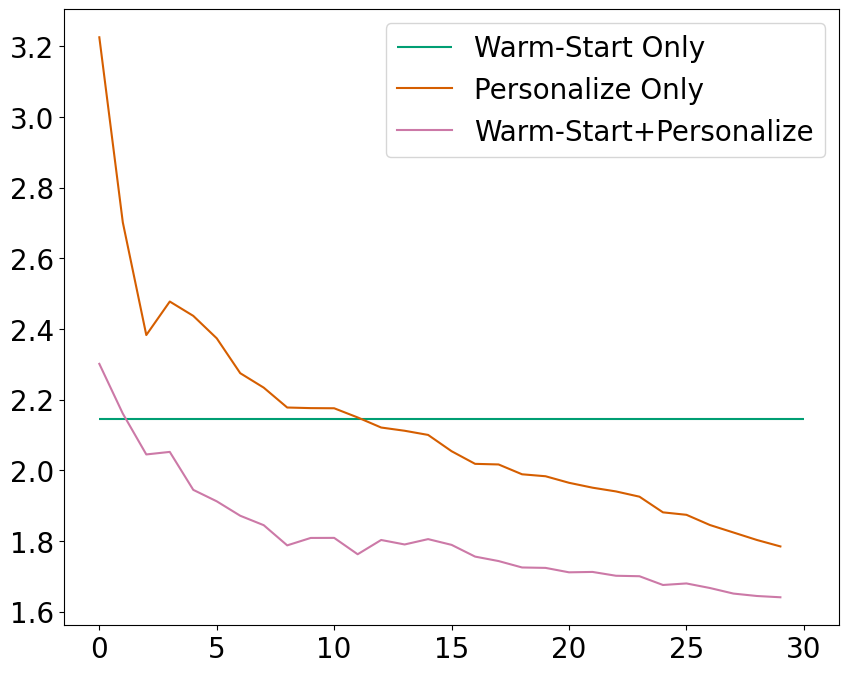

In [ ]:
plt.figure(figsize=(10,8))

plt.hlines([2.144],xmin=0,xmax=30,colors=c3, label="Warm-Start Only")
plt.plot(np.cumsum(list(map(np.mean,zip(*PRs))))/(np.arange(30)+1), color=c5, label="Personalize Only")
plt.plot(np.cumsum(list(map(np.mean,zip(*WSPRs))))/(np.arange(30)+1), color=c7, label="Warm-Start+Personalize")

plt.legend()
plt.show()

In [485]:
import coba as cb

class MyEnvironment:
    def __init__(self, X, Y, g):
        self.interactions = [ {"x": x, "y": y} for x,y in zip(X,Y) ]
        self.params = {'pid': g}
    def read(self):
        return self.interactions

class MyEvaluator:
    def __init__(self, num_threads):
        self.num_threads = num_threads
    def evaluate(self, env: cb.Environment, lrn):
        if self.num_threads: 
            torch.set_num_threads(self.num_threads)
        for row in env.read():
            true_x, true_y = row["x"],row["y"]
            pred_y = lrn.predict(true_x)[0].item()
            lrn.iter_fit(true_x,true_y)
            yield {'pred': pred_y, 'true': true_y}

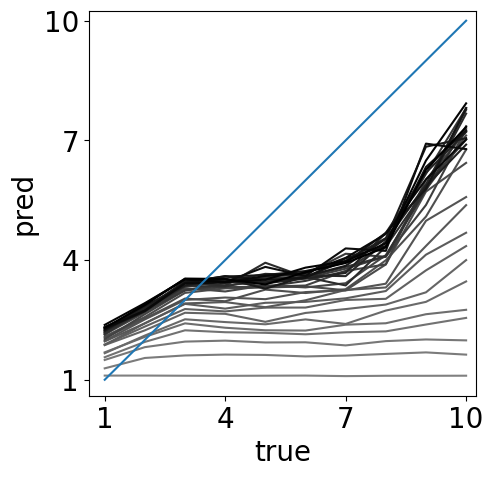

In [ ]:
def make_tasks(X, Y, G):

    X = np.array(X)
    Y = np.array(Y)
    G = np.array(G)

    w = 30
    take = 30
    specs = [20, w, 'l', 'r', w, 'l', 'r', w, 'l', 'r', w, 'l','r', w, 1]
    lrns = [FeedForwardSKR(specs=specs,rng=i,loss=torch.nn.MSELoss()) for i in range(10)]

    for g in set(G):
        X[g==G] = StandardScaler().fit_transform(X[g==G])

    for g in set(G):
        if sum(g==G) < take: continue
        envs = cb.Environments.from_custom(MyEnvironment(X[g==G].tolist(), Y[g==G].tolist(), g)).shuffle(n=30)
        val = MyEvaluator(take,1)

        # uncomment for pretraining
        # lrns = [FeedForwardSKR(specs=specs,rng=i) for i in range(10)]
        # for lrn in lrns: lrn.fit(torch.tensor(X[G != g]).float(), torch.tensor(Y[G != g]).unsqueeze(1).float())

        yield from product(envs, lrns, [val])

result = cb.Experiment(make_tasks(X,Y,G)).run(processes=40,quiet=True)

out = result.interactions.to_pandas().groupby(['index','true'])['pred'].mean().reset_index()
out['true'] += 1
out['pred'] += 1
out.pivot(index='true',columns='index').plot(figsize=(5,5),color=list(map(str,np.linspace(.5,0,30))),legend=False,xlim=[.6,10.25],ylim=[.6,10.25])
plt.plot([1,10],[1,10])
plt.yticks([1,4,7,10])
plt.xticks([1,4,7,10])
plt.ylabel('pred')
plt.show()

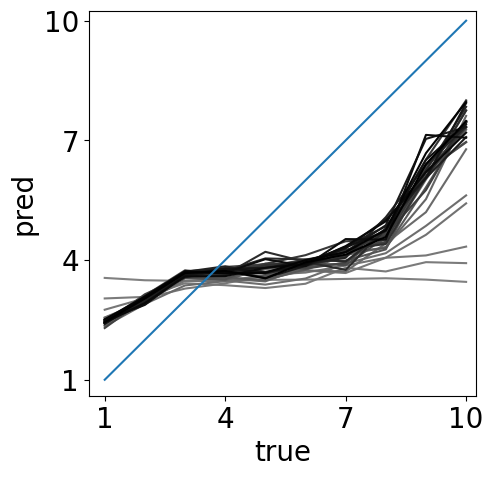

In [ ]:
def make_tasks(X, Y, G):

    X = np.array(X)
    Y = np.array(Y)
    G = np.array(G)

    w = 30
    take = 30
    specs = [20, w, 'l', 'r', w, 'l', 'r', w, 'l', 'r', w, 'l','r', w, 1]
    #lrns = [FeedForwardSKR(specs=specs,rng=i,loss=torch.nn.MSELoss()) for i in range(10)]

    for g in set(G):
        X[g==G] = StandardScaler().fit_transform(X[g==G])

    for g in set(G):    
        if sum(g==G) < take: continue
        envs = cb.Environments.from_custom(MyEnvironment(X[g==G].tolist(), Y[g==G].tolist(), g)).shuffle(n=30)
        val = MyEvaluator(take,1)

        # uncomment for pretraining
        lrns = [FeedForwardSKR(specs=specs,rng=i) for i in range(3)]
        for lrn in lrns: lrn.fit(torch.tensor(X[G != g]).float(), torch.tensor(Y[G != g]).unsqueeze(1).float())

        yield from product(envs, lrns, [val])

result = cb.Experiment(make_tasks(X,Y,G)).run(processes=40,quiet=True)

out = result.interactions.to_pandas().groupby(['index','true'])['pred'].mean().reset_index()
out['true'] += 1
out['pred'] += 1
out.pivot(index='true',columns='index').plot(figsize=(5,5),color=list(map(str,np.linspace(.5,0,30))),legend=False,xlim=[.6,10.25],ylim=[.6,10.25])
plt.plot([1,10],[1,10])
plt.yticks([1,4,7,10])
plt.xticks([1,4,7,10])
plt.ylabel('pred')
plt.show()

pred    Axes(0.125,0.11;0.775x0.77)
dtype: object

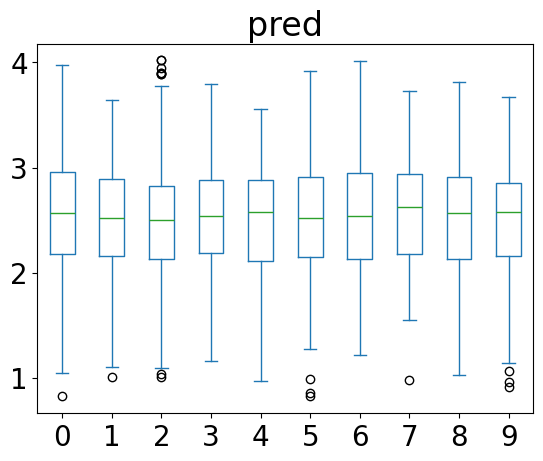

In [ ]:
out = result.interactions.to_pandas()
out[out["index"]==1].plot.box(by="true",column="pred")
#Warm Start

pred    Axes(0.125,0.11;0.775x0.77)
dtype: object

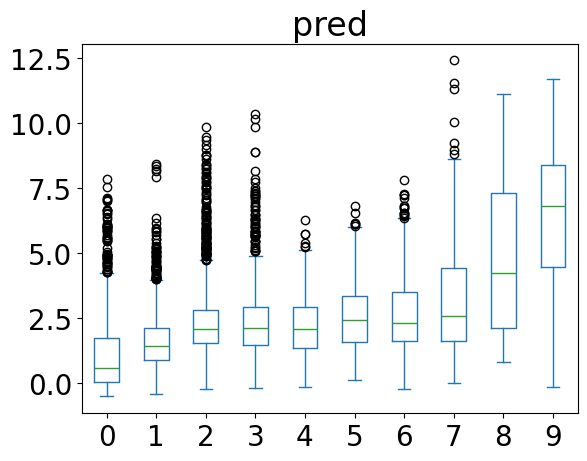

In [ ]:
out = result.interactions.to_pandas()
out[out["index"]==30].plot.box(by="true",column="pred")
#Personalization MEAN ABSOLUTE ERROR

pred    Axes(0.125,0.11;0.775x0.77)
dtype: object

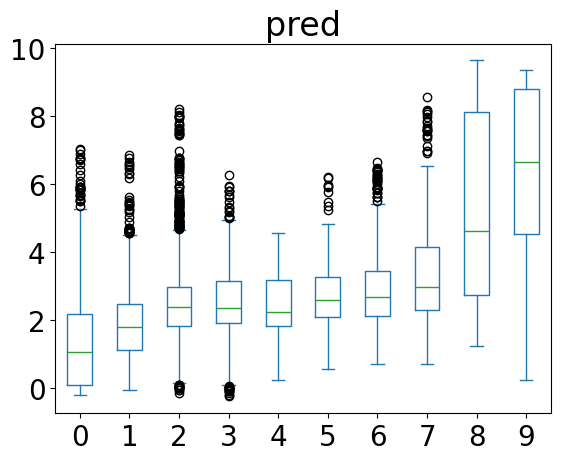

In [ ]:
out = result.interactions.to_pandas()
out[out["index"]==30].plot.box(by="true",column="pred")
#Personalization MEAN SQUARED ERROR

pred    Axes(0.125,0.11;0.775x0.77)
dtype: object

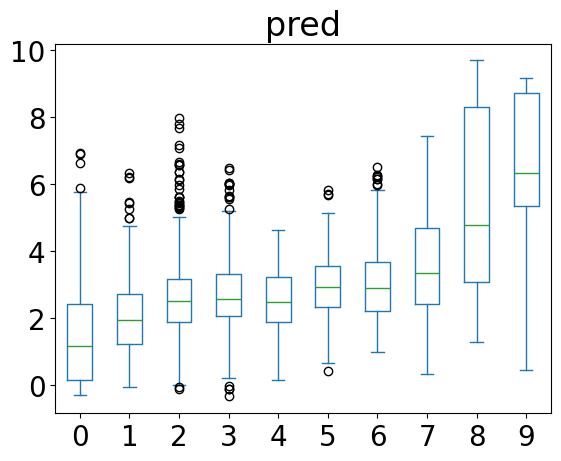

In [ ]:
out = result.interactions.to_pandas()
out[out["index"]==30].plot.box(by="true",column="pred")
#Warm Start + Personalization

err    Axes(0.125,0.11;0.775x0.77)
dtype: object

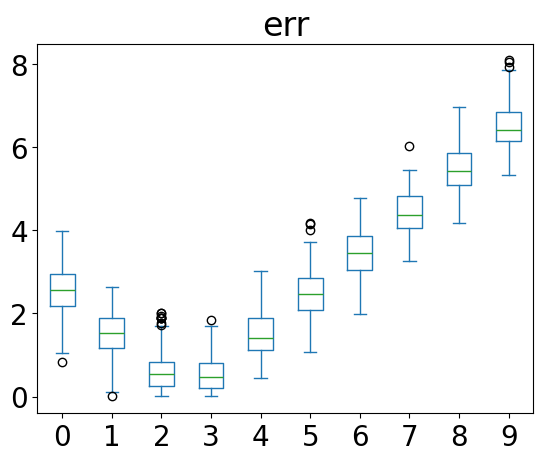

In [ ]:
out = result.interactions.to_pandas()
out["err"] = (out["pred"] - out["true"]).abs()
out[out["index"]==1].plot.box(by="true",column="err")
#Warm Start (errors)

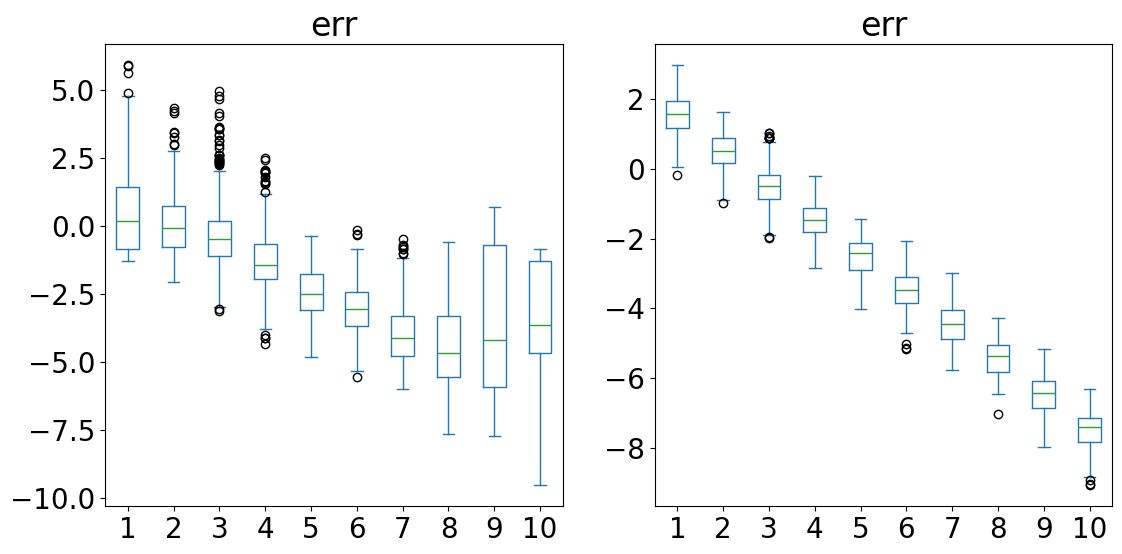

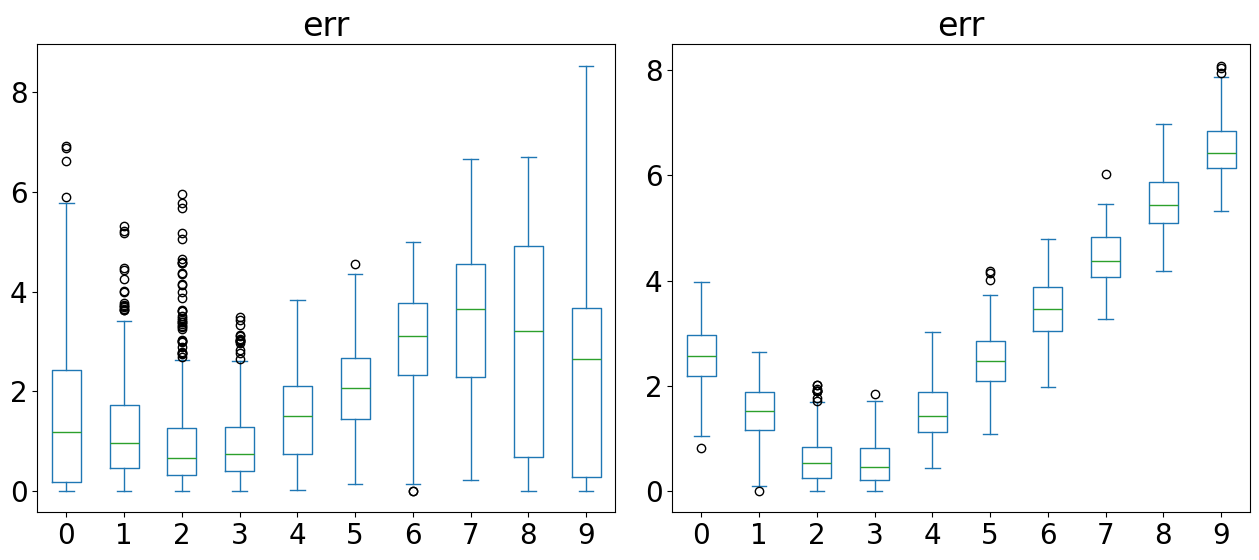

In [ ]:
out = result.interactions.to_pandas()

out["true"] += 1
out["err"] = (out["pred"] - out["true"])
fig,ax = plt.subplots(1,2,figsize=(13,6))
out[out["index"]==30].plot.box(by="true",column="err",ax=ax[0])
out[out["index"]==1].plot.box(by="true",column="err",ax=ax[1])

out = result.interactions.to_pandas()
out["err"] = (out["pred"] - out["true"]).abs()
fig,ax = plt.subplots(1,2,figsize=(13,6))
out[out["index"]==30].plot.box(by="true",column="err",ax=ax[0])
out[out["index"]==1].plot.box(by="true",column="err",ax=ax[1])

plt.tight_layout()
plt.show()

#Warm Start + Personalization (errors)

err    Axes(0.547727,0.11;0.352273x0.77)
dtype: object

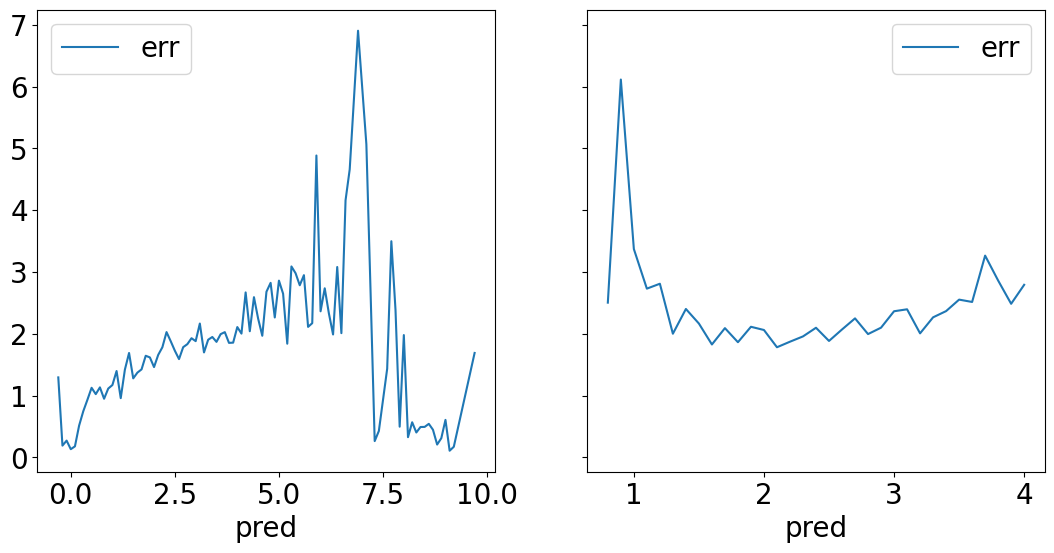

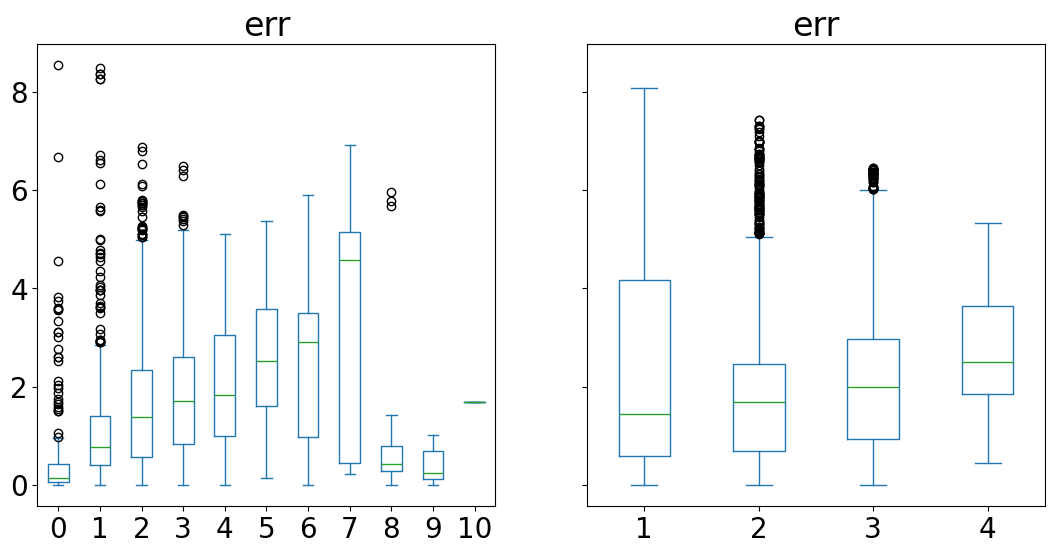

In [ ]:
out = result.interactions.to_pandas()
out["err"] = (out["pred"] - out["true"]).abs()

out["pred"] = out["pred"].round(1)
out = out.groupby(["pred","index"])["err"].mean().reset_index()

fig,ax = plt.subplots(1,2,figsize=(13,6),sharey=True)
out[out["index"]==30].plot(x="pred",y="err",ax=ax[0])
out[out["index"]==1].plot(x="pred",y="err",ax=ax[1])

out = result.interactions.to_pandas()
out["err"] = (out["pred"] - out["true"]).abs()

out["pred"] = out["pred"].round().astype(int)
fig,ax = plt.subplots(1,2,figsize=(13,6),sharey=True)
out[out["index"]==30].plot.box(by="pred",column="err",ax=ax[0])
out[out["index"]==1].plot.box(by="pred",column="err",ax=ax[1])

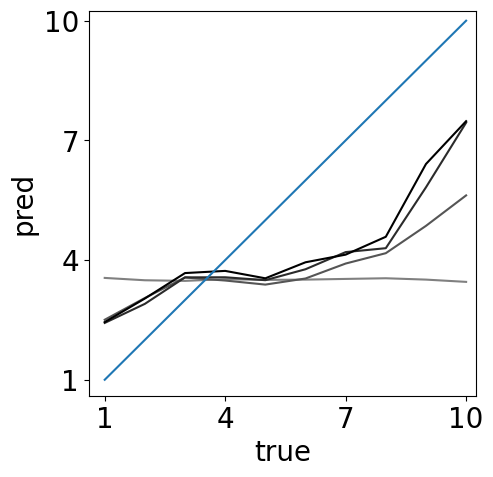

In [ ]:
out = result.interactions.to_pandas().groupby(['index','true'])['pred'].mean().reset_index()
out['true'] += 1
out['pred'] += 1

indexes = [1,5,10,30]
colors = list(map(str,np.linspace(.5,0,len(indexes))))
out = out[out["index"].isin(indexes)]

out.pivot(index='true',columns='index').plot(figsize=(5,5),color=colors,legend=False,xlim=[.6,10.25],ylim=[.6,10.25])

plt.plot([1,10],[1,10])
plt.yticks([1,4,7,10])
plt.xticks([1,4,7,10])
plt.ylabel('pred')
plt.show()

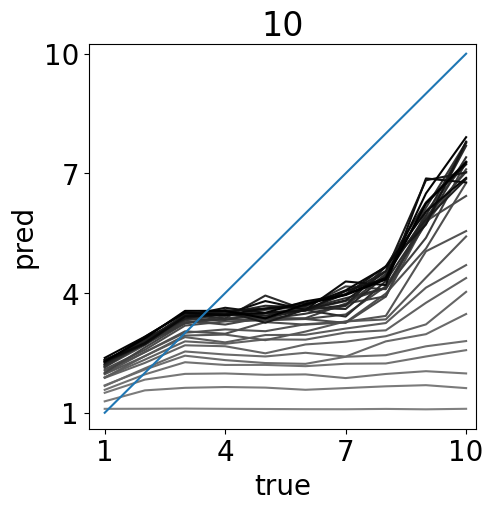

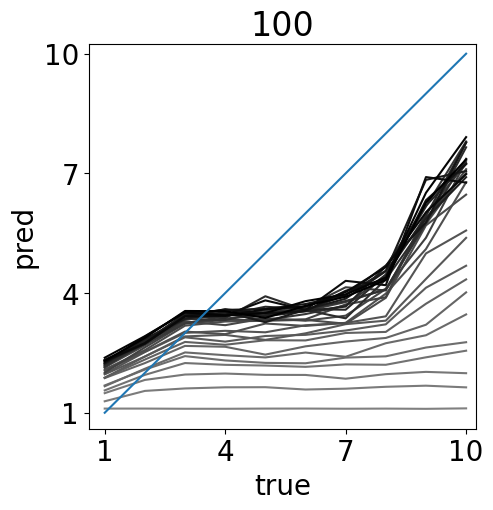

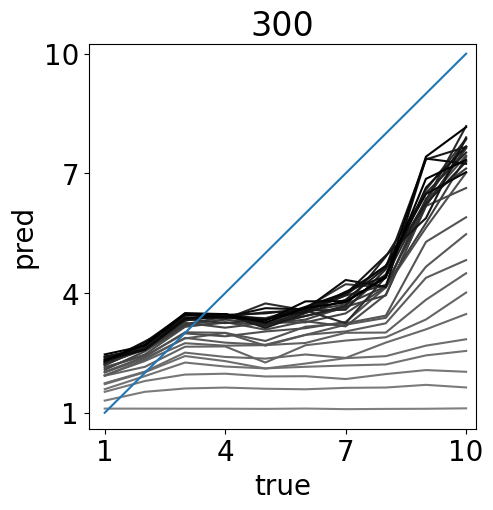

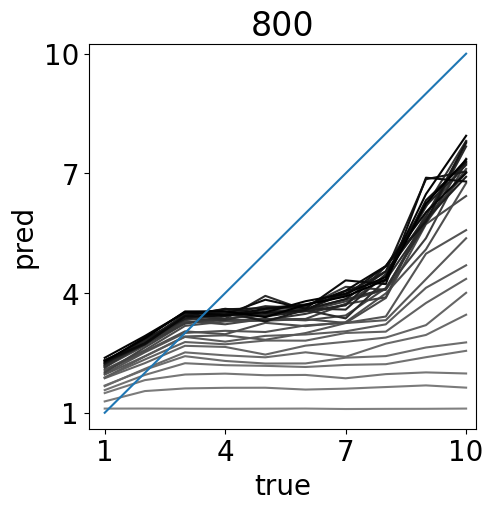

TypeError: 'NoneType' object is not iterable

In [ ]:
def wins(file_path, timestamps, window_len):
    file = open(file_path) if Path(file_path).exists() else nullcontext()
    rows = islice(csv.reader(file),1,None) if Path(file_path).exists() else [] #type: ignore

    with file:
        for timestamp in timestamps:
            window = []
            for row in rows:
                if float(row[0]) < timestamp-window_len: continue
                if float(row[0]) > timestamp: break
                data = map(float,row[1:])
                window.append(next(data) if len(row) == 2 else tuple(data))
            yield window

def accs(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Accelerometer.csv", timestamps, window_len):
        features.append([0,0,0,1] if not window else [*np.std(window,axis=0),0])
    return features

def lins(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/LinearAcceleration.csv", timestamps, window_len):
        features.append([0,0,0,1] if not window else [*np.std(window,axis=0),0])
    return features

def bats(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Battery.csv", timestamps, window_len):
        features.append([0,0,1] if not window else [np.mean(window),np.std(window),0])
    return features

def peds(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Pedometer.csv", timestamps, window_len):
        features.append([0,0,1] if not window else [np.mean(window),np.std(window),0])
    return features

def locs(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Location.csv", timestamps, window_len):
        #dist = np.linalg.norm(np.diff(window,axis=0),axis=1)
        #np.mean(dist),np.std(dist)
        features.append([0,0,0,1] if not window else [*np.mean(window,axis=0),0])
    return features

def tims(work_item, window_len=None):
    pid,timestamps,tzs = work_item

    features = []
    for timestamp,tz in zip(timestamps,tzs):
        
        if tz == "-04:00":
            timestamp -= 60*60*4
        elif tz == "-05:00":
            timestamp -= 60*60*5
        else:
            print(tz)
            raise Exception()
        time_of_day = (timestamp/(60*60*24)) % 1
        day_of_week = int(timestamp / (60*60*24)) % 7
        features.append([time_of_day,day_of_week])
    return features

def calc_feats(work_item_and_len):
    features = []
    
    for feats in zip(*[f(*work_item_and_len) for f in [locs,peds,bats,lins,accs,tims]]):
        features.append(list(chain.from_iterable(feats)))
    return features

def local():

    can_predict = emotions_df[(emotions_df["WatchDataQuality"] == "Good") & ~emotions_df["ER Interest"].isna()].copy()
    can_predict = can_predict.sort_values(["ParticipantId","SubmissionTimestampUtc"])

    d1 = dict(map(tuple,can_predict.groupby("ParticipantId")["SubmissionTimestampUtc"].apply(list).reset_index().itertuples(index=False)))
    d2 = dict(map(tuple,can_predict.groupby("ParticipantId")["LocalTimeZone"].apply(list).reset_index().itertuples(index=False)))

    work_items = []
    for key in d1.keys():
        work_items.append((key, d1[key], d2[key]))

    Y = (can_predict["ER Interest"]-1).astype(int).tolist()
    G = can_predict["ParticipantId"].tolist()

    for wlen in [10, 100]:
        X = []
        with ProcessPoolExecutor(max_workers=20) as executor:
            X.extend(chain.from_iterable(executor.map(calc_feats, zip(work_items,repeat(wlen)))))

        def make_tasks(X, Y, G):
            X = np.array(X)
            Y = np.array(Y)
            G = np.array(G)

            w = 30
            take = 30
            specs = [20, w, 'l', 'r', w, 'l', 'r', w, 'l', 'r', w, 'l','r', w, 1]
            lrns = [FeedForwardSKR(specs=specs,rng=i) for i in range(10)]

            for g in set(G):
                X[g==G] = StandardScaler().fit_transform(X[g==G])

            for g in set(G):    
                if sum(g==G) < take: continue
                envs = cb.Environments.from_custom(MyEnvironment(X[g==G].tolist(), Y[g==G].tolist(), g)).shuffle(n=30)
                val = MyEvaluator(take,1)

                # uncomment for pretraining
                # lrns = [FeedForwardSKR(specs=specs,rng=i) for i in range(10)]
                # for lrn in lrns: lrn.fit(torch.tensor(X[G != g]).float(), torch.tensor(Y[G != g]).unsqueeze(1).float())

                yield from product(envs, lrns, [val])

        result = cb.Experiment(make_tasks(X,Y,G)).run(processes=40,quiet=True)

        out = result.interactions.to_pandas().groupby(['index','true'])['pred'].mean().reset_index()
        out['true'] += 1
        out['pred'] += 1
        out.pivot(index='true',columns='index').plot(figsize=(5,5),color=list(map(str,np.linspace(.5,0,30))),legend=False,xlim=[.6,10.25],ylim=[.6,10.25])
        plt.plot([1,10],[1,10])
        plt.title(f"{wlen}")
        plt.yticks([1,4,7,10])
        plt.xticks([1,4,7,10])
        plt.ylabel('pred')
        plt.show()

local()

In [487]:
def wins(file_path, timestamps, window_len):
    file = open(file_path) if Path(file_path).exists() else nullcontext()
    rows = islice(csv.reader(file),1,None) if Path(file_path).exists() else [] #type: ignore

    with file:
        for timestamp in timestamps:
            window = []
            for row in rows:
                if float(row[0]) < timestamp-window_len: continue
                if float(row[0]) > timestamp: break
                data = map(float,row[1:])
                window.append(next(data) if len(row) == 2 else tuple(data))
            yield window

def miss(miss, not_miss, n_feat):
    features = []
    for m in miss:
        if m: features.append([0]*n_feat+[1])
        else: features.append(not_miss.pop()+[0])
    return features

def accs(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Accelerometer.csv", timestamps, window_len):
        pass
    return features

def lins(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/LinearAcceleration.csv", timestamps, window_len):
        missings.append(not w)
        if not w: continue
        vars = np.var(w,axis=0)
        pcts = np.percentile([np.linalg.norm(w,axis=1)],q=[10,50,90])
        features.append([*vars,*pcts])
    if features: features = StandardScaler().fit_transform(features).tolist()
    return miss(missings,features,6)

def bats(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/Battery.csv", timestamps, window_len):
        missings.append(not w)
        if not w: continue
        w = [float(w)/100 for w in w]
        features.append([np.mean(w),np.std(w)])
    return miss(missings,features,2)

def peds(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/Pedometer.csv", timestamps, window_len):
        missings.append(not w)
        if not w: continue
        features.append([np.mean(w),np.std(w)])
    if features: features = StandardScaler().fit_transform(features).tolist()
    return miss(missings,features,2)

def locs(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/Location.csv", timestamps, window_len):
        missings.append(not w)
        if not w: continue
        features.append([*np.mean(w,axis=0),0])
    return miss(missings,features,2)

def tims(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    hour = 60*60
    day = 24*hour
    for timestamp,tz in zip(timestamps,tzs):

        if tz == "-04:00":
            timestamp -= 4*hour
        elif tz == "-05:00":
            timestamp -= 5*hour

        time_of_day = (timestamp/day) % 1
        day_of_week = (int(timestamp/day)+4) % 7
        is_weekend = day_of_week in [0,6]
        is_weekday = day_of_week in [1,2,3,4,5]
        features.append([time_of_day,int(is_weekend),int(is_weekday)])
    return features

def nulls(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    return [[0]*4 for t in timestamps]

def calc_feats(work_item_and_len):
    features = []
    for feats in zip(*[f(*work_item_and_len) for f in [tims,peds,bats,lins]]):
        features.append(list(chain.from_iterable(feats)))
    return features

def local():

    can_predict = emotions_df[(emotions_df["WatchDataQuality"] == "Good") & ~emotions_df["ER Interest"].isna()].copy()
    can_predict = can_predict.sort_values(["ParticipantId","SubmissionTimestampUtc"])

    d1 = dict(map(tuple,can_predict.groupby("ParticipantId")["SubmissionTimestampUtc"].apply(list).reset_index().itertuples(index=False)))
    d2 = dict(map(tuple,can_predict.groupby("ParticipantId")["LocalTimeZone"].apply(list).reset_index().itertuples(index=False)))

    work_items = []
    for key in d1.keys():
        work_items.append((key, d1[key], d2[key]))

    Y = (can_predict["ER Interest"]-1).astype(float).to_numpy()
    G = can_predict["ParticipantId"].to_numpy()

    # for g in set(G):
    #     Y[g==G] = RobustScaler().fit_transform(np.expand_dims(Y[g==G],axis=1)).squeeze()

    Y = (Y < 2).astype(int)

    for wlen in [300]:
        X = []
        with ProcessPoolExecutor(max_workers=20) as executor:
            X.extend(chain.from_iterable(executor.map(calc_feats, zip(work_items,repeat(wlen)))))
        #X.extend(chain.from_iterable(map(calc_feats, zip(work_items, repeat(wlen)))))

        def make_envs(X, Y, G):
            X, Y, G = np.array(X), np.array(Y), np.array(G)
            return [MyEnvironment(X[g==G].tolist(), Y[g==G].tolist(), g) for g in set(G)]

        vals = MyEvaluator(1)
        envs = cb.Environments.from_custom(*make_envs(X,Y,G)).take(40, True).shuffle(n=100)  # type: ignore
        lrns = [
            #FeedForwardSKR(specs=[16, 1], rng=1, loss=torch.nn.L1Loss()),
            #FeedForwardSKR(specs=[16, 30, 'l', 'r', 1], rng=1, loss=torch.nn.L1Loss()),
            FeedForwardSKC(specs=[16, 1], rng=1, loss=torch.nn.BCEWithLogitsLoss()),
            FeedForwardSKC(specs=[16, 30, 'l', 'r', 1], rng=1, loss=torch.nn.BCEWithLogitsLoss())
        ]

        return cb.Experiment(envs,lrns,vals).run(processes=40, quiet=True) # type: ignore

result = local()

out = result.where(index=30)
out = pd.merge(pd.merge(out.environments.to_pandas(),out.interactions.to_pandas()),out.learners.to_pandas())
out = out.groupby(['pid','specs','true'])['pred'].mean().reset_index()
out = out.groupby(['specs','true'])['pred'].mean().reset_index()

out.pivot(index='true',columns='specs',values='pred').plot(figsize=(10,5),legend=True)
#out['true'] += 1
#out['pred'] += 1
out.pivot(index='true',columns='specs',values='pred').plot(figsize=(10,5),legend=True)
#plt.plot([1,10],[1,10])
plt.show()

2025-04-13 11:30:50 -- pid-3677037 -- Unexpected exception:

  File "/home/mrucker/Projects/coba/coba/experiments/process.py", line 179, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/tmp/ipykernel_3050492/1619492478.py", line 18, in evaluate
    <unknown code, this is likely due to the code being in a Jupyter cell>
  File "/tmp/ipykernel_3050492/2019946071.py", line 279, in predict
    <unknown code, this is likely due to the code being in a Jupyter cell>

  IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

2025-04-13 11:30:50 -- pid-3677037 -- Unexpected exception:

  File "/home/mrucker/Projects/coba/coba/experiments/process.py", line 179, in filter
    yield ["T4", (env_id, lrn_id, val_id), list(SafeEvaluator(val).evaluate(env,lrn))]
  File "/tmp/ipykernel_3050492/1619492478.py", line 18, in evaluate
    <unknown code, this is likely due to the code being in a Jupyter cell>
  File "/tmp/ipy

KeyError: 'true'

In [480]:
((can_predict["ER Interest"]-1).astype(float).to_numpy() < 2).sum()

957

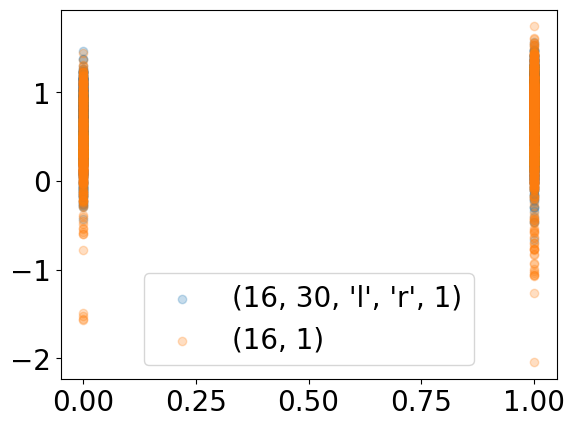

In [473]:
out = result.where(index=30)
out = pd.merge(pd.merge(out.environments.to_pandas(),out.interactions.to_pandas()),out.learners.to_pandas())

for s in set(out["specs"]):
    _out = out[out["specs"]==s]
    plt.scatter(_out["true"],_out["pred"],alpha=.25,label=s)
plt.legend()
plt.show()

23


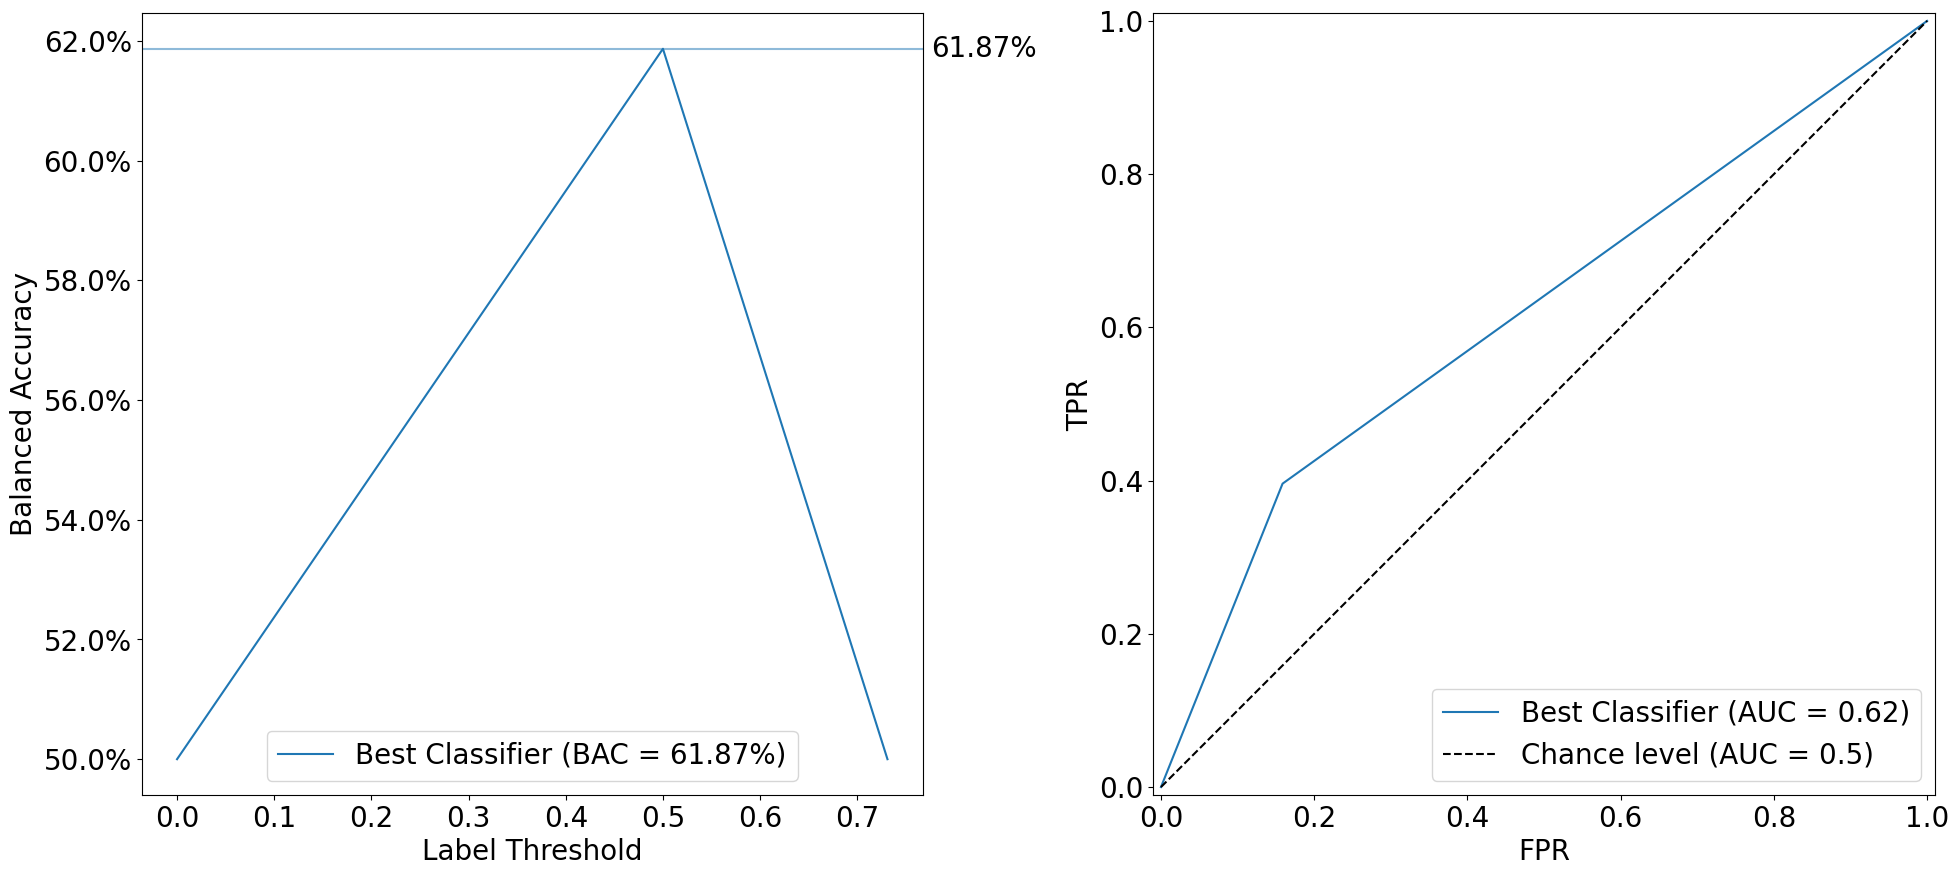

In [ ]:
def wins(file_path, timestamps, window_len):
    file = open(file_path) if Path(file_path).exists() else nullcontext()
    rows = islice(csv.reader(file),1,None) if Path(file_path).exists() else [] #type: ignore

    with file:
        for timestamp in timestamps:
            window = []
            for row in rows:
                if float(row[0]) < timestamp-window_len: continue
                if float(row[0]) > timestamp: break
                data = map(float,row[1:])
                window.append(next(data) if len(row) == 2 else tuple(data))
            yield window

def miss(miss, not_miss, n_feat):
    features = []
    for m in miss:
        if m: features.append([0]*n_feat+[1])
        else: features.append(not_miss.pop()+[0])
    return features

def accs(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    for window in wins(f"../data/phone/{pid}/Accelerometer.csv", timestamps, window_len):
        pass
    return features

def lins(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/LinearAcceleration.csv", timestamps, window_len or 100):
        missings.append(not w)
        if not w: continue
        vars = np.var(w,axis=0)
        pcts = np.percentile([np.linalg.norm(w,axis=1)],q=[10,50,90])
        features.append([*vars,*pcts])
    if features: features = StandardScaler().fit_transform(features).tolist()
    return miss(missings,features,6)

def bats(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/Battery.csv", timestamps, window_len):
        missings.append(not w)
        if not w: continue
        w = [float(w)/100 for w in w]
        features.append([np.mean(w),np.std(w)])
    return miss(missings,features,2)

def peds(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/Pedometer.csv", timestamps, window_len):
        missings.append(not w)
        if not w: continue
        features.append([np.mean(w),np.std(w)])
    if features: features = StandardScaler().fit_transform(features).tolist()
    return miss(missings,features,2)

def locs1(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/Location.csv", timestamps, window_len or 600):
        missings.append(not w)
        if not w: continue
        features.append([*np.mean(w,axis=0)[1:]])
    
    if features: features = TheoryGridCellSpatialRelationEncoder(2,frequency_num=n_freq,max_radius=lmax,min_radius=lmin).make_input_embeds(features)
    return miss(missings,features,n_freq*6)

def locs2(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    missings = []
    features = []
    for w in wins(f"../data/phone/{pid}/Location.csv", timestamps, window_len):
        missings.append(not w)
        if not w: continue
        features.append([*np.mean(w,axis=0)[1:]])
    
    return miss(missings,features,2)

def tims(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    features = []
    hour = 60*60
    day = 24*hour
    for timestamp,tz in zip(timestamps,tzs):

        if tz == "-04:00":
            timestamp -= 4*hour
        elif tz == "-05:00":
            timestamp -= 5*hour

        time_of_day = (timestamp/day) % 1
        day_of_week = (int(timestamp/day)+4) % 7
        is_weekend = day_of_week in [0,6]
        is_weekday = day_of_week in [1,2,3,4,5]
        features.append([time_of_day,int(is_weekend),int(is_weekday)])
    return features

def nulls(work_item, window_len=None):
    pid,timestamps,tzs = work_item
    return [[0]*4 for t in timestamps]

def calc_feats(work_item_and_len):
    features = []
    #for feats in zip(*[f(*work_item_and_len) for f in [tims,peds,bats,lins]]):
    #for feats in zip(*[f(*work_item_and_len) for f in [tims,lins]]):
    for feats in zip(*[f(*work_item_and_len) for f in [locs1,lins,tims]]):
        features.append(list(chain.from_iterable(feats)))
    return features

can_predict = emotions_df[(emotions_df["WatchDataQuality"] == "Good") & ~emotions_df["ER Interest"].isna()].copy()
can_predict = can_predict.sort_values(["ParticipantId","SubmissionTimestampUtc"])

d1 = dict(map(tuple,can_predict.groupby("ParticipantId")["SubmissionTimestampUtc"].apply(list).reset_index().itertuples(index=False)))
d2 = dict(map(tuple,can_predict.groupby("ParticipantId")["LocalTimeZone"].apply(list).reset_index().itertuples(index=False)))

work_items = []
for key in d1.keys():
    work_items.append((key, d1[key], d2[key]))


Y = (can_predict["ER Interest"]-1).astype(float).to_numpy()
Y = (Y < 2).astype(float)

n_freq = 2
lmin = 10
lmax = 100
wlen = 600

#wlen = 100 is best for lins
#wlen = 600 is best for locs1

#X = []
#with ProcessPoolExecutor(max_workers=20) as executor:
#    X.extend(chain.from_iterable(executor.map(calc_feats, zip(work_items,repeat(wlen)))))

print(len(X[0]))

cv    = StratifiedKFold(n_splits=20, shuffle=True, random_state=1)
#model = FeedForwardSKC(specs=[len(X[0]), 10, 'l', 'r', 10, 'l', 'r', 1], trn_size=.5, rng=1, loss=torch.nn.BCEWithLogitsLoss())
#preds = cross_val_predict(model, X, Y, cv=cv, n_jobs=3)[:,0]

model = RandomForestClassifier(max_depth=6)
preds = cross_val_predict(model, X, Y, cv=cv, n_jobs=3)

pd.DataFrame({'pred':preds, "true": Y}).groupby("true")["pred"].mean()

df = pd.DataFrame({'scores':torch.sigmoid(torch.tensor(preds)), "labels": Y})

f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
acc_plot(df,"Best Classifier",ax[0])
roc_plot(df,"Best Classifier",ax[1])
plt.tight_layout()

In [521]:
torch.sigmoid(torch.tensor(preds))

tensor([[0.5287],
        [0.4607],
        [0.3447],
        ...,
        [0.4538],
        [0.4170],
        [0.5278]])

In [500]:
loss = torch.nn.BCEWithLogitsLoss()

pred = torch.tensor([1]).float()
true = torch.tensor([1]).float()

loss(true,pred)

tensor(0.3133)

In [583]:
_X = np.array(X)
_X = _X[_X[:,2] == 0][:,:2]

Counter(map(tuple,_X.round(4)))

#plt.scatter(_X[:,0],_X[:,1])

Counter({(38.0169, -78.5215): 21,
         (38.0339, -78.5078): 19,
         (38.0418, -78.4975): 16,
         (38.0294, -78.5191): 16,
         (38.0295, -78.5052): 15,
         (38.0376, -78.4969): 15,
         (38.0285, -78.5109): 14,
         (38.0419, -78.5038): 13,
         (38.0357, -78.5106): 13,
         (38.026, -78.5096): 12,
         (38.0392, -78.5084): 12,
         (38.0168, -78.521): 11,
         (38.0152, -78.5224): 11,
         (38.0345, -78.5158): 11,
         (38.0168, -78.5215): 11,
         (38.0297, -78.5199): 11,
         (38.0297, -78.5195): 10,
         (38.0274, -78.5122): 10,
         (38.0351, -78.5118): 10,
         (38.0263, -78.5143): 9,
         (38.0412, -78.5045): 9,
         (38.0341, -78.5159): 8,
         (38.03, -78.5193): 8,
         (38.0354, -78.5123): 8,
         (38.0329, -78.5075): 7,
         (38.0265, -78.5144): 7,
         (38.3886, -75.0636): 6,
         (38.6499, -77.5174): 6,
         (38.0338, -78.5116): 6,
         (38.7544, -77.5593)

In [568]:
np.mean([[1,1],[2,3],[3,4]],axis=0)

array([2.        , 2.66666667])

In [15]:
x1 = [
	[(0, 0, 0, 0), 52.27, [29, 10, 1]],
	[(0, 0, 0, 1), 50.80, [29, 10, 1]],
	[(0, 0, 0, 2), 52.28, [29, 10, 1]],
	[(0, 0, 1, 0), 53.52, [29, 10, 1]],
	[(0, 0, 1, 1), 53.41, [29, 10, 1]],
	[(0, 0, 1, 2), 52.98, [29, 10, 1]],
	[(0, 0, 2, 0), 53.89, [29, 10, 1]],
	[(0, 0, 2, 1), 53.58, [29, 10, 1]],
	[(0, 0, 2, 2), 52.87, [29, 10, 1]],
	[(0, 1, 0, 0), 50.93, [29, 10, 1]],
	[(0, 1, 0, 1), 50.66, [29, 10, 1]],
	[(0, 1, 0, 2), 53.01, [29, 10, 1]],
	[(0, 1, 1, 0), 51.27, [29, 10, 1]],
	[(0, 1, 1, 1), 50.63, [29, 10, 1]],
	[(0, 1, 1, 2), 52.10, [29, 10, 1]],
	[(0, 1, 2, 0), 51.27, [29, 10, 1]],
	[(0, 1, 2, 1), 50.87, [29, 10, 1]],
	[(0, 1, 2, 2), 53.33, [29, 10, 1]],
	[(0, 2, 0, 0), 50.11, [29, 10, 1]],
	[(0, 2, 0, 1), 51.81, [29, 10, 1]],
	[(0, 2, 0, 2), 52.60, [29, 10, 1]],
	[(0, 2, 1, 0), 50.24, [29, 10, 1]],
	[(0, 2, 1, 1), 51.42, [29, 10, 1]],
	[(0, 2, 1, 2), 53.92, [29, 10, 1]],
	[(0, 2, 2, 0), 50.15, [29, 10, 1]],
	[(0, 2, 2, 1), 53.08, [29, 10, 1]],
	[(0, 2, 2, 2), 53.81, [29, 10, 1]],
	[(1, 0, 0, 0), 53.58, [29, 10, 1]],
	[(1, 0, 0, 1), 53.79, [29, 10, 1]],
	[(1, 0, 0, 2), 55.44, [29, 10, 1]],
	[(1, 0, 1, 0), 51.76, [29, 10, 1]],
	[(1, 0, 1, 1), 51.63, [29, 10, 1]],
	[(1, 0, 1, 2), 52.28, [29, 10, 1]],
	[(1, 0, 2, 0), 53.85, [29, 10, 1]],
	[(1, 0, 2, 1), 53.92, [29, 10, 1]],
	[(1, 0, 2, 2), 54.98, [29, 10, 1]],
	[(1, 1, 0, 0), 52.68, [29, 10, 1]],
	[(1, 1, 0, 1), 50.88, [29, 10, 1]],
	[(1, 1, 0, 2), 52.04, [29, 10, 1]],
	[(1, 1, 1, 0), 52.11, [29, 10, 1]],
	[(1, 1, 1, 1), 50.91, [29, 10, 1]],
	[(1, 1, 1, 2), 52.29, [29, 10, 1]],
	[(1, 1, 2, 0), 53.69, [29, 10, 1]],
	[(1, 1, 2, 1), 54.58, [29, 10, 1]],
	[(1, 1, 2, 2), 54.79, [29, 10, 1]],
	[(1, 2, 0, 0), 53.80, [29, 10, 1]],
	[(1, 2, 0, 1), 53.70, [29, 10, 1]],
	[(1, 2, 0, 2), 55.10, [29, 10, 1]],
	[(1, 2, 1, 0), 52.34, [29, 10, 1]],
	[(1, 2, 1, 1), 52.70, [29, 10, 1]],
	[(1, 2, 1, 2), 52.72, [29, 10, 1]],
	[(1, 2, 2, 0), 53.19, [29, 10, 1]],
	[(1, 2, 2, 1), 51.66, [29, 10, 1]],
	[(1, 2, 2, 2), 53.03, [29, 10, 1]],
	[(2, 0, 0, 0), 52.18, [29, 10, 1]],
	[(2, 0, 0, 1), 51.92, [29, 10, 1]],
	[(2, 0, 0, 2), 51.75, [29, 10, 1]],
	[(2, 0, 1, 0), 54.22, [29, 10, 1]],
	[(2, 0, 1, 1), 52.73, [29, 10, 1]],
	[(2, 0, 1, 2), 53.49, [29, 10, 1]],
	[(2, 0, 2, 0), 51.13, [29, 10, 1]],
	[(2, 0, 2, 1), 51.55, [29, 10, 1]],
	[(2, 0, 2, 2), 51.95, [29, 10, 1]],
	[(2, 1, 0, 0), 53.37, [29, 10, 1]],
	[(2, 1, 0, 1), 53.53, [29, 10, 1]],
	[(2, 1, 0, 2), 53.29, [29, 10, 1]],
	[(2, 1, 1, 0), 53.62, [29, 10, 1]],
	[(2, 1, 1, 1), 53.74, [29, 10, 1]],
	[(2, 1, 1, 2), 52.00, [29, 10, 1]],
	[(2, 1, 2, 0), 54.40, [29, 10, 1]],
	[(2, 1, 2, 1), 54.07, [29, 10, 1]],
	[(2, 1, 2, 2), 53.80, [29, 10, 1]],
	[(2, 2, 0, 0), 51.24, [29, 10, 1]],
	[(2, 2, 0, 1), 50.71, [29, 10, 1]],
	[(2, 2, 0, 2), 51.28, [29, 10, 1]],
	[(2, 2, 1, 0), 51.57, [29, 10, 1]],
	[(2, 2, 1, 1), 51.41, [29, 10, 1]],
	[(2, 2, 1, 2), 51.96, [29, 10, 1]],
	[(2, 2, 2, 0), 50.37, [29, 10, 1]],
	[(2, 2, 2, 1), 51.05, [29, 10, 1]],
	[(2, 2, 2, 2), 52.70, [29, 10, 1]],
	[(0, 0, 0, 0), 51.04, [29, 10, 'l', 'r', 1]],
	[(0, 0, 0, 1), 51.23, [29, 10, 'l', 'r', 1]],
	[(0, 0, 0, 2), 51.44, [29, 10, 'l', 'r', 1]],
	[(0, 0, 1, 0), 53.69, [29, 10, 'l', 'r', 1]],
	[(0, 0, 1, 1), 51.42, [29, 10, 'l', 'r', 1]],
	[(0, 0, 1, 2), 52.04, [29, 10, 'l', 'r', 1]],
	[(0, 0, 2, 0), 50.93, [29, 10, 'l', 'r', 1]],
	[(0, 0, 2, 1), 50.76, [29, 10, 'l', 'r', 1]],
	[(0, 0, 2, 2), 51.26, [29, 10, 'l', 'r', 1]],
	[(0, 1, 0, 0), 54.28, [29, 10, 'l', 'r', 1]],
	[(0, 1, 0, 1), 51.83, [29, 10, 'l', 'r', 1]],
	[(0, 1, 0, 2), 51.49, [29, 10, 'l', 'r', 1]],
	[(0, 1, 1, 0), 56.86, [29, 10, 'l', 'r', 1]],
	[(0, 1, 1, 1), 60.23, [29, 10, 'l', 'r', 1]],
	[(0, 1, 1, 2), 57.71, [29, 10, 'l', 'r', 1]],
	[(0, 1, 2, 0), 52.45, [29, 10, 'l', 'r', 1]],
	[(0, 1, 2, 1), 50.91, [29, 10, 'l', 'r', 1]],
	[(0, 1, 2, 2), 50.38, [29, 10, 'l', 'r', 1]],
	[(0, 2, 0, 0), 51.60, [29, 10, 'l', 'r', 1]],
	[(0, 2, 0, 1), 51.92, [29, 10, 'l', 'r', 1]],
	[(0, 2, 0, 2), 50.91, [29, 10, 'l', 'r', 1]],
	[(0, 2, 1, 0), 53.01, [29, 10, 'l', 'r', 1]],
	[(0, 2, 1, 1), 51.06, [29, 10, 'l', 'r', 1]],
	[(0, 2, 1, 2), 52.11, [29, 10, 'l', 'r', 1]],
	[(0, 2, 2, 0), 51.88, [29, 10, 'l', 'r', 1]],
	[(0, 2, 2, 1), 53.10, [29, 10, 'l', 'r', 1]],
	[(0, 2, 2, 2), 51.58, [29, 10, 'l', 'r', 1]],
	[(1, 0, 0, 0), 55.14, [29, 10, 'l', 'r', 1]],
	[(1, 0, 0, 1), 52.38, [29, 10, 'l', 'r', 1]],
	[(1, 0, 0, 2), 50.88, [29, 10, 'l', 'r', 1]],
	[(1, 0, 1, 0), 50.16, [29, 10, 'l', 'r', 1]],
	[(1, 0, 1, 1), 50.10, [29, 10, 'l', 'r', 1]],
	[(1, 0, 1, 2), 50.27, [29, 10, 'l', 'r', 1]],
	[(1, 0, 2, 0), 50.49, [29, 10, 'l', 'r', 1]],
	[(1, 0, 2, 1), 50.04, [29, 10, 'l', 'r', 1]],
	[(1, 0, 2, 2), 50.78, [29, 10, 'l', 'r', 1]],
	[(1, 1, 0, 0), 52.27, [29, 10, 'l', 'r', 1]],
	[(1, 1, 0, 1), 50.31, [29, 10, 'l', 'r', 1]],
	[(1, 1, 0, 2), 50.99, [29, 10, 'l', 'r', 1]],
	[(1, 1, 1, 0), 55.10, [29, 10, 'l', 'r', 1]],
	[(1, 1, 1, 1), 56.81, [29, 10, 'l', 'r', 1]],
	[(1, 1, 1, 2), 53.63, [29, 10, 'l', 'r', 1]],
	[(1, 1, 2, 0), 51.70, [29, 10, 'l', 'r', 1]],
	[(1, 1, 2, 1), 50.92, [29, 10, 'l', 'r', 1]],
	[(1, 1, 2, 2), 53.58, [29, 10, 'l', 'r', 1]],
	[(1, 2, 0, 0), 57.84, [29, 10, 'l', 'r', 1]],
	[(1, 2, 0, 1), 56.58, [29, 10, 'l', 'r', 1]],
	[(1, 2, 0, 2), 56.41, [29, 10, 'l', 'r', 1]],
	[(1, 2, 1, 0), 57.45, [29, 10, 'l', 'r', 1]],
	[(1, 2, 1, 1), 57.02, [29, 10, 'l', 'r', 1]],
	[(1, 2, 1, 2), 55.92, [29, 10, 'l', 'r', 1]],
	[(1, 2, 2, 0), 56.87, [29, 10, 'l', 'r', 1]],
	[(1, 2, 2, 1), 59.00, [29, 10, 'l', 'r', 1]],
	[(1, 2, 2, 2), 57.93, [29, 10, 'l', 'r', 1]],
	[(2, 0, 0, 0), 50.86, [29, 10, 'l', 'r', 1]],
	[(2, 0, 0, 1), 51.19, [29, 10, 'l', 'r', 1]],
	[(2, 0, 0, 2), 51.18, [29, 10, 'l', 'r', 1]],
	[(2, 0, 1, 0), 50.73, [29, 10, 'l', 'r', 1]],
	[(2, 0, 1, 1), 50.21, [29, 10, 'l', 'r', 1]],
	[(2, 0, 1, 2), 51.35, [29, 10, 'l', 'r', 1]],
	[(2, 0, 2, 0), 50.77, [29, 10, 'l', 'r', 1]],
	[(2, 0, 2, 1), 50.22, [29, 10, 'l', 'r', 1]],
	[(2, 0, 2, 2), 50.83, [29, 10, 'l', 'r', 1]],
	[(2, 1, 0, 0), 50.44, [29, 10, 'l', 'r', 1]],
	[(2, 1, 0, 1), 50.27, [29, 10, 'l', 'r', 1]],
	[(2, 1, 0, 2), 52.19, [29, 10, 'l', 'r', 1]],
	[(2, 1, 1, 0), 58.60, [29, 10, 'l', 'r', 1]],
	[(2, 1, 1, 1), 56.68, [29, 10, 'l', 'r', 1]],
	[(2, 1, 1, 2), 58.87, [29, 10, 'l', 'r', 1]],
	[(2, 1, 2, 0), 57.44, [29, 10, 'l', 'r', 1]],
	[(2, 1, 2, 1), 57.48, [29, 10, 'l', 'r', 1]],
	[(2, 1, 2, 2), 55.61, [29, 10, 'l', 'r', 1]],
	[(2, 2, 0, 0), 51.57, [29, 10, 'l', 'r', 1]],
	[(2, 2, 0, 1), 51.16, [29, 10, 'l', 'r', 1]],
	[(2, 2, 0, 2), 52.98, [29, 10, 'l', 'r', 1]],
	[(2, 2, 1, 0), 54.25, [29, 10, 'l', 'r', 1]],
	[(2, 2, 1, 1), 55.78, [29, 10, 'l', 'r', 1]],
	[(2, 2, 1, 2), 55.51, [29, 10, 'l', 'r', 1]],
	[(2, 2, 2, 0), 53.41, [29, 10, 'l', 'r', 1]],
	[(2, 2, 2, 1), 52.21, [29, 10, 'l', 'r', 1]],
	[(2, 2, 2, 2), 52.40, [29, 10, 'l', 'r', 1]],
	[(0, 0, 0, 0), 54.36, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 0, 1), 51.57, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 0, 2), 52.75, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 1, 0), 54.41, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 1, 1), 54.14, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 1, 2), 52.24, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 2, 0), 50.89, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 2, 1), 50.74, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 2, 2), 52.25, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 0, 0), 55.05, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 0, 1), 55.64, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 0, 2), 54.41, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 1, 0), 52.72, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 1, 1), 50.71, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 1, 2), 51.65, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 2, 0), 54.35, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 2, 1), 57.33, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 1, 2, 2), 53.10, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 0, 0), 58.28, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 0, 1), 54.42, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 0, 2), 52.88, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 1, 0), 51.58, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 1, 1), 50.01, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 1, 2), 50.45, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 2, 0), 52.11, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 2, 1), 50.37, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 2, 2, 2), 51.77, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 0, 0), 51.43, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 0, 1), 50.06, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 0, 2), 50.99, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 1, 0), 51.59, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 1, 1), 50.52, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 1, 2), 50.53, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 2, 0), 51.59, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 2, 1), 50.26, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 0, 2, 2), 51.12, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 0, 0), 52.90, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 0, 1), 54.09, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 0, 2), 52.48, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 1, 0), 50.82, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 1, 1), 50.20, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 1, 2), 51.38, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 2, 0), 54.36, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 2, 1), 54.84, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 1, 2, 2), 54.02, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 0, 0), 54.23, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 0, 1), 54.59, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 0, 2), 53.69, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 1, 0), 55.40, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 1, 1), 55.57, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 1, 2), 54.50, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 2, 0), 50.88, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 2, 1), 52.54, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(1, 2, 2, 2), 51.94, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 0, 0), 52.08, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 0, 1), 53.36, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 0, 2), 53.47, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 1, 0), 52.76, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 1, 1), 52.07, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 1, 2), 51.70, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 2, 0), 52.96, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 2, 1), 56.95, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 0, 2, 2), 54.06, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 0, 0), 54.07, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 0, 1), 58.58, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 0, 2), 53.97, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 1, 0), 54.77, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 1, 1), 52.33, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 1, 2), 52.29, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 2, 0), 54.77, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 2, 1), 55.26, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 1, 2, 2), 53.78, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 0, 0), 56.47, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 0, 1), 58.60, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 0, 2), 56.27, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 1, 0), 51.25, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 1, 1), 51.15, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 1, 2), 50.31, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 2, 0), 50.72, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 2, 1), 51.40, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(2, 2, 2, 2), 51.65, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
	[(0, 0, 0, 0), 53.61, [29, 30, 1]],
	[(0, 0, 0, 1), 53.70, [29, 30, 1]],
	[(0, 0, 0, 2), 52.94, [29, 30, 1]],
	[(0, 0, 1, 0), 54.12, [29, 30, 1]],
	[(0, 0, 1, 1), 54.07, [29, 30, 1]],
	[(0, 0, 1, 2), 52.86, [29, 30, 1]],
	[(0, 0, 2, 0), 53.56, [29, 30, 1]],
	[(0, 0, 2, 1), 53.91, [29, 30, 1]],
	[(0, 0, 2, 2), 53.07, [29, 30, 1]],
	[(0, 1, 0, 0), 51.88, [29, 30, 1]],
	[(0, 1, 0, 1), 50.14, [29, 30, 1]],
	[(0, 1, 0, 2), 52.10, [29, 30, 1]],
	[(0, 1, 1, 0), 50.79, [29, 30, 1]],
	[(0, 1, 1, 1), 50.02, [29, 30, 1]],
	[(0, 1, 1, 2), 50.68, [29, 30, 1]],
	[(0, 1, 2, 0), 52.13, [29, 30, 1]],
	[(0, 1, 2, 1), 50.03, [29, 30, 1]],
	[(0, 1, 2, 2), 51.56, [29, 30, 1]],
	[(0, 2, 0, 0), 51.17, [29, 30, 1]],
	[(0, 2, 0, 1), 50.20, [29, 30, 1]],
	[(0, 2, 0, 2), 52.21, [29, 30, 1]],
	[(0, 2, 1, 0), 52.06, [29, 30, 1]],
	[(0, 2, 1, 1), 50.32, [29, 30, 1]],
	[(0, 2, 1, 2), 51.33, [29, 30, 1]],
	[(0, 2, 2, 0), 50.45, [29, 30, 1]],
	[(0, 2, 2, 1), 50.15, [29, 30, 1]],
	[(0, 2, 2, 2), 53.38, [29, 30, 1]],
	[(1, 0, 0, 0), 54.34, [29, 30, 1]],
	[(1, 0, 0, 1), 53.26, [29, 30, 1]],
	[(1, 0, 0, 2), 55.93, [29, 30, 1]],
	[(1, 0, 1, 0), 52.09, [29, 30, 1]],
	[(1, 0, 1, 1), 52.86, [29, 30, 1]],
	[(1, 0, 1, 2), 54.00, [29, 30, 1]],
	[(1, 0, 2, 0), 53.89, [29, 30, 1]],
	[(1, 0, 2, 1), 53.43, [29, 30, 1]],
	[(1, 0, 2, 2), 55.80, [29, 30, 1]],
	[(1, 1, 0, 0), 55.01, [29, 30, 1]],
	[(1, 1, 0, 1), 53.47, [29, 30, 1]],
	[(1, 1, 0, 2), 54.78, [29, 30, 1]],
	[(1, 1, 1, 0), 54.79, [29, 30, 1]],
	[(1, 1, 1, 1), 53.37, [29, 30, 1]],
	[(1, 1, 1, 2), 54.66, [29, 30, 1]],
	[(1, 1, 2, 0), 54.60, [29, 30, 1]],
	[(1, 1, 2, 1), 53.36, [29, 30, 1]],
	[(1, 1, 2, 2), 55.04, [29, 30, 1]],
	[(1, 2, 0, 0), 55.72, [29, 30, 1]],
	[(1, 2, 0, 1), 52.85, [29, 30, 1]],
	[(1, 2, 0, 2), 55.80, [29, 30, 1]],
	[(1, 2, 1, 0), 55.30, [29, 30, 1]],
	[(1, 2, 1, 1), 53.10, [29, 30, 1]],
	[(1, 2, 1, 2), 55.63, [29, 30, 1]],
	[(1, 2, 2, 0), 54.01, [29, 30, 1]],
	[(1, 2, 2, 1), 52.89, [29, 30, 1]],
	[(1, 2, 2, 2), 55.79, [29, 30, 1]],
	[(2, 0, 0, 0), 53.65, [29, 30, 1]],
	[(2, 0, 0, 1), 53.06, [29, 30, 1]],
	[(2, 0, 0, 2), 52.90, [29, 30, 1]],
	[(2, 0, 1, 0), 52.61, [29, 30, 1]],
	[(2, 0, 1, 1), 50.30, [29, 30, 1]],
	[(2, 0, 1, 2), 53.09, [29, 30, 1]],
	[(2, 0, 2, 0), 54.47, [29, 30, 1]],
	[(2, 0, 2, 1), 52.74, [29, 30, 1]],
	[(2, 0, 2, 2), 52.39, [29, 30, 1]],
	[(2, 1, 0, 0), 50.75, [29, 30, 1]],
	[(2, 1, 0, 1), 50.22, [29, 30, 1]],
	[(2, 1, 0, 2), 50.95, [29, 30, 1]],
	[(2, 1, 1, 0), 50.57, [29, 30, 1]],
	[(2, 1, 1, 1), 50.22, [29, 30, 1]],
	[(2, 1, 1, 2), 51.08, [29, 30, 1]],
	[(2, 1, 2, 0), 52.39, [29, 30, 1]],
	[(2, 1, 2, 1), 50.21, [29, 30, 1]],
	[(2, 1, 2, 2), 51.03, [29, 30, 1]],
	[(2, 2, 0, 0), 53.79, [29, 30, 1]],
	[(2, 2, 0, 1), 53.67, [29, 30, 1]],
	[(2, 2, 0, 2), 52.81, [29, 30, 1]],
	[(2, 2, 1, 0), 54.24, [29, 30, 1]],
	[(2, 2, 1, 1), 52.38, [29, 30, 1]],
	[(2, 2, 1, 2), 51.95, [29, 30, 1]],
	[(2, 2, 2, 0), 50.42, [29, 30, 1]],
	[(2, 2, 2, 1), 50.36, [29, 30, 1]],
	[(2, 2, 2, 2), 52.27, [29, 30, 1]],
	[(0, 0, 0, 0), 51.85, [29, 30, 'l', 'r', 1]],
	[(0, 0, 0, 1), 50.46, [29, 30, 'l', 'r', 1]],
	[(0, 0, 0, 2), 50.23, [29, 30, 'l', 'r', 1]],
	[(0, 0, 1, 0), 51.67, [29, 30, 'l', 'r', 1]],
	[(0, 0, 1, 1), 50.04, [29, 30, 'l', 'r', 1]],
	[(0, 0, 1, 2), 51.73, [29, 30, 'l', 'r', 1]],
	[(0, 0, 2, 0), 51.64, [29, 30, 'l', 'r', 1]],
	[(0, 0, 2, 1), 50.69, [29, 30, 'l', 'r', 1]],
	[(0, 0, 2, 2), 52.79, [29, 30, 'l', 'r', 1]],
	[(0, 1, 0, 0), 56.81, [29, 30, 'l', 'r', 1]],
	[(0, 1, 0, 1), 58.56, [29, 30, 'l', 'r', 1]],
	[(0, 1, 0, 2), 56.39, [29, 30, 'l', 'r', 1]],
	[(0, 1, 1, 0), 50.12, [29, 30, 'l', 'r', 1]],
	[(0, 1, 1, 1), 50.10, [29, 30, 'l', 'r', 1]],
	[(0, 1, 1, 2), 50.87, [29, 30, 'l', 'r', 1]],
	[(0, 1, 2, 0), 51.91, [29, 30, 'l', 'r', 1]],
	[(0, 1, 2, 1), 50.74, [29, 30, 'l', 'r', 1]],
	[(0, 1, 2, 2), 50.18, [29, 30, 'l', 'r', 1]],
	[(0, 2, 0, 0), 50.60, [29, 30, 'l', 'r', 1]],
	[(0, 2, 0, 1), 50.44, [29, 30, 'l', 'r', 1]],
	[(0, 2, 0, 2), 50.55, [29, 30, 'l', 'r', 1]],
	[(0, 2, 1, 0), 50.45, [29, 30, 'l', 'r', 1]],
	[(0, 2, 1, 1), 51.28, [29, 30, 'l', 'r', 1]],
	[(0, 2, 1, 2), 52.18, [29, 30, 'l', 'r', 1]],
	[(0, 2, 2, 0), 51.17, [29, 30, 'l', 'r', 1]],
	[(0, 2, 2, 1), 51.59, [29, 30, 'l', 'r', 1]],
	[(0, 2, 2, 2), 51.20, [29, 30, 'l', 'r', 1]],
	[(1, 0, 0, 0), 56.80, [29, 30, 'l', 'r', 1]],
	[(1, 0, 0, 1), 60.00, [29, 30, 'l', 'r', 1]],
	[(1, 0, 0, 2), 56.64, [29, 30, 'l', 'r', 1]],
	[(1, 0, 1, 0), 61.58, [29, 30, 'l', 'r', 1]],
	[(1, 0, 1, 1), 60.52, [29, 30, 'l', 'r', 1]],
	[(1, 0, 1, 2), 57.58, [29, 30, 'l', 'r', 1]],
	[(1, 0, 2, 0), 56.99, [29, 30, 'l', 'r', 1]],
	[(1, 0, 2, 1), 57.98, [29, 30, 'l', 'r', 1]],
	[(1, 0, 2, 2), 55.38, [29, 30, 'l', 'r', 1]],
	[(1, 1, 0, 0), 57.47, [29, 30, 'l', 'r', 1]],
	[(1, 1, 0, 1), 58.71, [29, 30, 'l', 'r', 1]],
	[(1, 1, 0, 2), 60.11, [29, 30, 'l', 'r', 1]],
	[(1, 1, 1, 0), 57.88, [29, 30, 'l', 'r', 1]],
	[(1, 1, 1, 1), 59.38, [29, 30, 'l', 'r', 1]],
	[(1, 1, 1, 2), 62.01, [29, 30, 'l', 'r', 1]],
	[(1, 1, 2, 0), 58.82, [29, 30, 'l', 'r', 1]],
	[(1, 1, 2, 1), 58.95, [29, 30, 'l', 'r', 1]],
	[(1, 1, 2, 2), 56.56, [29, 30, 'l', 'r', 1]],
	[(1, 2, 0, 0), 62.48, [29, 30, 'l', 'r', 1]],
	[(1, 2, 0, 1), 59.61, [29, 30, 'l', 'r', 1]],
	[(1, 2, 0, 2), 57.20, [29, 30, 'l', 'r', 1]],
	[(1, 2, 1, 0), 58.30, [29, 30, 'l', 'r', 1]],
	[(1, 2, 1, 1), 59.64, [29, 30, 'l', 'r', 1]],
	[(1, 2, 1, 2), 58.06, [29, 30, 'l', 'r', 1]],
	[(1, 2, 2, 0), 58.91, [29, 30, 'l', 'r', 1]],
	[(1, 2, 2, 1), 62.11, [29, 30, 'l', 'r', 1]],
	[(1, 2, 2, 2), 58.59, [29, 30, 'l', 'r', 1]],
	[(2, 0, 0, 0), 51.96, [29, 30, 'l', 'r', 1]],
	[(2, 0, 0, 1), 50.56, [29, 30, 'l', 'r', 1]],
	[(2, 0, 0, 2), 51.27, [29, 30, 'l', 'r', 1]],
	[(2, 0, 1, 0), 51.93, [29, 30, 'l', 'r', 1]],
	[(2, 0, 1, 1), 50.76, [29, 30, 'l', 'r', 1]],
	[(2, 0, 1, 2), 50.92, [29, 30, 'l', 'r', 1]],
	[(2, 0, 2, 0), 50.05, [29, 30, 'l', 'r', 1]],
	[(2, 0, 2, 1), 50.32, [29, 30, 'l', 'r', 1]],
	[(2, 0, 2, 2), 51.14, [29, 30, 'l', 'r', 1]],
	[(2, 1, 0, 0), 56.56, [29, 30, 'l', 'r', 1]],
	[(2, 1, 0, 1), 57.92, [29, 30, 'l', 'r', 1]],
	[(2, 1, 0, 2), 58.77, [29, 30, 'l', 'r', 1]],
	[(2, 1, 1, 0), 51.69, [29, 30, 'l', 'r', 1]],
	[(2, 1, 1, 1), 50.00, [29, 30, 'l', 'r', 1]],
	[(2, 1, 1, 2), 51.74, [29, 30, 'l', 'r', 1]],
	[(2, 1, 2, 0), 50.80, [29, 30, 'l', 'r', 1]],
	[(2, 1, 2, 1), 50.63, [29, 30, 'l', 'r', 1]],
	[(2, 1, 2, 2), 50.78, [29, 30, 'l', 'r', 1]],
	[(2, 2, 0, 0), 50.77, [29, 30, 'l', 'r', 1]],
	[(2, 2, 0, 1), 50.42, [29, 30, 'l', 'r', 1]],
	[(2, 2, 0, 2), 50.63, [29, 30, 'l', 'r', 1]],
	[(2, 2, 1, 0), 58.98, [29, 30, 'l', 'r', 1]],
	[(2, 2, 1, 1), 59.67, [29, 30, 'l', 'r', 1]],
	[(2, 2, 1, 2), 57.51, [29, 30, 'l', 'r', 1]],
	[(2, 2, 2, 0), 57.67, [29, 30, 'l', 'r', 1]],
	[(2, 2, 2, 1), 58.02, [29, 30, 'l', 'r', 1]],
	[(2, 2, 2, 2), 58.49, [29, 30, 'l', 'r', 1]],
	[(0, 0, 0, 0), 51.08, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 0, 0, 1), 50.36, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 0, 0, 2), 51.80, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 0, 1, 0), 54.80, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 0, 1, 1), 56.99, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 0, 1, 2), 54.49, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 0, 2, 0), 52.38, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 0, 2, 1), 51.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 0, 2, 2), 52.70, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 0, 0), 53.74, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 0, 1), 52.66, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 0, 2), 54.39, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 1, 0), 53.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 1, 1), 51.50, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 1, 2), 53.20, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 2, 0), 54.32, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 2, 1), 50.79, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 1, 2, 2), 51.26, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 0, 0), 55.11, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 0, 1), 58.13, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 0, 2), 55.47, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 1, 0), 57.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 1, 1), 59.60, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 1, 2), 57.05, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 2, 0), 56.66, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 2, 1), 60.02, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(0, 2, 2, 2), 59.78, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 0, 0), 58.94, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 0, 1), 60.41, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 0, 2), 59.09, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 1, 0), 56.49, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 1, 1), 59.47, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 1, 2), 60.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 2, 0), 53.44, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 2, 1), 53.59, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 0, 2, 2), 52.27, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 0, 0), 53.30, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 0, 1), 51.69, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 0, 2), 51.18, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 1, 0), 57.14, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 1, 1), 50.49, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 1, 2), 53.12, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 2, 0), 55.13, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 2, 1), 52.37, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 1, 2, 2), 52.30, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 0, 0), 58.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 0, 1), 57.34, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 0, 2), 60.82, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 1, 0), 58.48, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 1, 1), 58.74, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 1, 2), 56.44, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 2, 0), 59.58, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 2, 1), 59.58, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(1, 2, 2, 2), 58.83, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 0, 0), 59.52, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 0, 1), 59.88, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 0, 2), 60.51, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 1, 0), 57.43, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 1, 1), 58.88, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 1, 2), 58.43, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 2, 0), 56.09, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 2, 1), 58.68, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 0, 2, 2), 59.81, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 0, 0), 52.78, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 0, 1), 50.37, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 0, 2), 53.98, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 1, 0), 52.97, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 1, 1), 51.63, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 1, 2), 52.17, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 2, 0), 54.28, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 2, 1), 51.94, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 1, 2, 2), 52.94, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 0, 0), 59.58, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 0, 1), 60.10, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 0, 2), 59.19, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 1, 0), 61.02, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 1, 1), 59.63, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 1, 2), 60.32, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 2, 0), 59.79, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 2, 1), 61.78, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
	[(2, 2, 2, 2), 58.57, [29, 30, 'l', 'r', 30, 'l', 'r', 1]]
]

In [30]:
x2 = [
    [(0, 0, 0, 0, 'v500'), 52.27, [29, 10, 1]],
    [(0, 0, 0, 1, 'v500'), 50.80, [29, 10, 1]],
    [(0, 0, 0, 2, 'v500'), 52.28, [29, 10, 1]],
    [(0, 0, 1, 0, 'v500'), 53.52, [29, 10, 1]],
    [(0, 0, 1, 1, 'v500'), 53.41, [29, 10, 1]],
    [(0, 0, 1, 2, 'v500'), 52.98, [29, 10, 1]],
    [(0, 0, 2, 0, 'v500'), 53.89, [29, 10, 1]],
    [(0, 0, 2, 1, 'v500'), 53.58, [29, 10, 1]],
    [(0, 0, 2, 2, 'v500'), 52.87, [29, 10, 1]],
    [(0, 1, 0, 0, 'v500'), 50.93, [29, 10, 1]],
    [(0, 1, 0, 1, 'v500'), 50.66, [29, 10, 1]],
    [(0, 1, 0, 2, 'v500'), 53.01, [29, 10, 1]],
    [(0, 1, 1, 0, 'v500'), 51.27, [29, 10, 1]],
    [(0, 1, 1, 1, 'v500'), 50.63, [29, 10, 1]],
    [(0, 1, 1, 2, 'v500'), 52.10, [29, 10, 1]],
    [(0, 1, 2, 0, 'v500'), 51.27, [29, 10, 1]],
    [(0, 1, 2, 1, 'v500'), 50.87, [29, 10, 1]],
    [(0, 1, 2, 2, 'v500'), 53.33, [29, 10, 1]],
    [(0, 2, 0, 0, 'v500'), 50.11, [29, 10, 1]],
    [(0, 2, 0, 1, 'v500'), 51.81, [29, 10, 1]],
    [(0, 2, 0, 2, 'v500'), 52.60, [29, 10, 1]],
    [(0, 2, 1, 0, 'v500'), 50.24, [29, 10, 1]],
    [(0, 2, 1, 1, 'v500'), 51.42, [29, 10, 1]],
    [(0, 2, 1, 2, 'v500'), 53.92, [29, 10, 1]],
    [(0, 2, 2, 0, 'v500'), 50.15, [29, 10, 1]],
    [(0, 2, 2, 1, 'v500'), 53.08, [29, 10, 1]],
    [(0, 2, 2, 2, 'v500'), 53.81, [29, 10, 1]],
    [(1, 0, 0, 0, 'v500'), 53.58, [29, 10, 1]],
    [(1, 0, 0, 1, 'v500'), 53.79, [29, 10, 1]],
    [(1, 0, 0, 2, 'v500'), 55.44, [29, 10, 1]],
    [(1, 0, 1, 0, 'v500'), 51.76, [29, 10, 1]],
    [(1, 0, 1, 1, 'v500'), 51.63, [29, 10, 1]],
    [(1, 0, 1, 2, 'v500'), 52.28, [29, 10, 1]],
    [(1, 0, 2, 0, 'v500'), 53.85, [29, 10, 1]],
    [(1, 0, 2, 1, 'v500'), 53.92, [29, 10, 1]],
    [(1, 0, 2, 2, 'v500'), 54.98, [29, 10, 1]],
    [(1, 1, 0, 0, 'v500'), 52.68, [29, 10, 1]],
    [(1, 1, 0, 1, 'v500'), 50.88, [29, 10, 1]],
    [(1, 1, 0, 2, 'v500'), 52.04, [29, 10, 1]],
    [(1, 1, 1, 0, 'v500'), 52.11, [29, 10, 1]],
    [(1, 1, 1, 1, 'v500'), 50.91, [29, 10, 1]],
    [(1, 1, 1, 2, 'v500'), 52.29, [29, 10, 1]],
    [(1, 1, 2, 0, 'v500'), 53.69, [29, 10, 1]],
    [(1, 1, 2, 1, 'v500'), 54.58, [29, 10, 1]],
    [(1, 1, 2, 2, 'v500'), 54.79, [29, 10, 1]],
    [(1, 2, 0, 0, 'v500'), 53.80, [29, 10, 1]],
    [(1, 2, 0, 1, 'v500'), 53.70, [29, 10, 1]],
    [(1, 2, 0, 2, 'v500'), 55.10, [29, 10, 1]],
    [(1, 2, 1, 0, 'v500'), 52.34, [29, 10, 1]],
    [(1, 2, 1, 1, 'v500'), 52.70, [29, 10, 1]],
    [(1, 2, 1, 2, 'v500'), 52.72, [29, 10, 1]],
    [(1, 2, 2, 0, 'v500'), 53.19, [29, 10, 1]],
    [(1, 2, 2, 1, 'v500'), 51.66, [29, 10, 1]],
    [(1, 2, 2, 2, 'v500'), 53.03, [29, 10, 1]],
    [(2, 0, 0, 0, 'v500'), 52.18, [29, 10, 1]],
    [(2, 0, 0, 1, 'v500'), 51.92, [29, 10, 1]],
    [(2, 0, 0, 2, 'v500'), 51.75, [29, 10, 1]],
    [(2, 0, 1, 0, 'v500'), 54.22, [29, 10, 1]],
    [(2, 0, 1, 1, 'v500'), 52.73, [29, 10, 1]],
    [(2, 0, 1, 2, 'v500'), 53.49, [29, 10, 1]],
    [(2, 0, 2, 0, 'v500'), 51.13, [29, 10, 1]],
    [(2, 0, 2, 1, 'v500'), 51.55, [29, 10, 1]],
    [(2, 0, 2, 2, 'v500'), 51.95, [29, 10, 1]],
    [(2, 1, 0, 0, 'v500'), 53.37, [29, 10, 1]],
    [(2, 1, 0, 1, 'v500'), 53.53, [29, 10, 1]],
    [(2, 1, 0, 2, 'v500'), 53.29, [29, 10, 1]],
    [(2, 1, 1, 0, 'v500'), 53.62, [29, 10, 1]],
    [(2, 1, 1, 1, 'v500'), 53.74, [29, 10, 1]],
    [(2, 1, 1, 2, 'v500'), 52.00, [29, 10, 1]],
    [(2, 1, 2, 0, 'v500'), 54.40, [29, 10, 1]],
    [(2, 1, 2, 1, 'v500'), 54.07, [29, 10, 1]],
    [(2, 1, 2, 2, 'v500'), 53.80, [29, 10, 1]],
    [(2, 2, 0, 0, 'v500'), 51.24, [29, 10, 1]],
    [(2, 2, 0, 1, 'v500'), 50.71, [29, 10, 1]],
    [(2, 2, 0, 2, 'v500'), 51.28, [29, 10, 1]],
    [(2, 2, 1, 0, 'v500'), 51.57, [29, 10, 1]],
    [(2, 2, 1, 1, 'v500'), 51.41, [29, 10, 1]],
    [(2, 2, 1, 2, 'v500'), 51.96, [29, 10, 1]],
    [(2, 2, 2, 0, 'v500'), 50.37, [29, 10, 1]],
    [(2, 2, 2, 1, 'v500'), 51.05, [29, 10, 1]],
    [(2, 2, 2, 2, 'v500'), 52.70, [29, 10, 1]],
    [(0, 0, 0, 0, 'v500'), 51.04, [29, 10, 'l', 'r', 1]],
    [(0, 0, 0, 1, 'v500'), 51.23, [29, 10, 'l', 'r', 1]],
    [(0, 0, 0, 2, 'v500'), 51.44, [29, 10, 'l', 'r', 1]],
    [(0, 0, 1, 0, 'v500'), 53.69, [29, 10, 'l', 'r', 1]],
    [(0, 0, 1, 1, 'v500'), 51.42, [29, 10, 'l', 'r', 1]],
    [(0, 0, 1, 2, 'v500'), 52.04, [29, 10, 'l', 'r', 1]],
    [(0, 0, 2, 0, 'v500'), 50.93, [29, 10, 'l', 'r', 1]],
    [(0, 0, 2, 1, 'v500'), 50.76, [29, 10, 'l', 'r', 1]],
    [(0, 0, 2, 2, 'v500'), 51.26, [29, 10, 'l', 'r', 1]],
    [(0, 1, 0, 0, 'v500'), 54.28, [29, 10, 'l', 'r', 1]],
    [(0, 1, 0, 1, 'v500'), 51.83, [29, 10, 'l', 'r', 1]],
    [(0, 1, 0, 2, 'v500'), 51.49, [29, 10, 'l', 'r', 1]],
    [(0, 1, 1, 0, 'v500'), 56.86, [29, 10, 'l', 'r', 1]],
    [(0, 1, 1, 1, 'v500'), 60.23, [29, 10, 'l', 'r', 1]],
    [(0, 1, 1, 2, 'v500'), 57.71, [29, 10, 'l', 'r', 1]],
    [(0, 1, 2, 0, 'v500'), 52.45, [29, 10, 'l', 'r', 1]],
    [(0, 1, 2, 1, 'v500'), 50.91, [29, 10, 'l', 'r', 1]],
    [(0, 1, 2, 2, 'v500'), 50.38, [29, 10, 'l', 'r', 1]],
    [(0, 2, 0, 0, 'v500'), 51.60, [29, 10, 'l', 'r', 1]],
    [(0, 2, 0, 1, 'v500'), 51.92, [29, 10, 'l', 'r', 1]],
    [(0, 2, 0, 2, 'v500'), 50.91, [29, 10, 'l', 'r', 1]],
    [(0, 2, 1, 0, 'v500'), 53.01, [29, 10, 'l', 'r', 1]],
    [(0, 2, 1, 1, 'v500'), 51.06, [29, 10, 'l', 'r', 1]],
    [(0, 2, 1, 2, 'v500'), 52.11, [29, 10, 'l', 'r', 1]],
    [(0, 2, 2, 0, 'v500'), 51.88, [29, 10, 'l', 'r', 1]],
    [(0, 2, 2, 1, 'v500'), 53.10, [29, 10, 'l', 'r', 1]],
    [(0, 2, 2, 2, 'v500'), 51.58, [29, 10, 'l', 'r', 1]],
    [(1, 0, 0, 0, 'v500'), 55.14, [29, 10, 'l', 'r', 1]],
    [(1, 0, 0, 1, 'v500'), 52.38, [29, 10, 'l', 'r', 1]],
    [(1, 0, 0, 2, 'v500'), 50.88, [29, 10, 'l', 'r', 1]],
    [(1, 0, 1, 0, 'v500'), 50.16, [29, 10, 'l', 'r', 1]],
    [(1, 0, 1, 1, 'v500'), 50.10, [29, 10, 'l', 'r', 1]],
    [(1, 0, 1, 2, 'v500'), 50.27, [29, 10, 'l', 'r', 1]],
    [(1, 0, 2, 0, 'v500'), 50.49, [29, 10, 'l', 'r', 1]],
    [(1, 0, 2, 1, 'v500'), 50.04, [29, 10, 'l', 'r', 1]],
    [(1, 0, 2, 2, 'v500'), 50.78, [29, 10, 'l', 'r', 1]],
    [(1, 1, 0, 0, 'v500'), 52.27, [29, 10, 'l', 'r', 1]],
    [(1, 1, 0, 1, 'v500'), 50.31, [29, 10, 'l', 'r', 1]],
    [(1, 1, 0, 2, 'v500'), 50.99, [29, 10, 'l', 'r', 1]],
    [(1, 1, 1, 0, 'v500'), 55.10, [29, 10, 'l', 'r', 1]],
    [(1, 1, 1, 1, 'v500'), 56.81, [29, 10, 'l', 'r', 1]],
    [(1, 1, 1, 2, 'v500'), 53.63, [29, 10, 'l', 'r', 1]],
    [(1, 1, 2, 0, 'v500'), 51.70, [29, 10, 'l', 'r', 1]],
    [(1, 1, 2, 1, 'v500'), 50.92, [29, 10, 'l', 'r', 1]],
    [(1, 1, 2, 2, 'v500'), 53.58, [29, 10, 'l', 'r', 1]],
    [(1, 2, 0, 0, 'v500'), 57.84, [29, 10, 'l', 'r', 1]],
    [(1, 2, 0, 1, 'v500'), 56.58, [29, 10, 'l', 'r', 1]],
    [(1, 2, 0, 2, 'v500'), 56.41, [29, 10, 'l', 'r', 1]],
    [(1, 2, 1, 0, 'v500'), 57.45, [29, 10, 'l', 'r', 1]],
    [(1, 2, 1, 1, 'v500'), 57.02, [29, 10, 'l', 'r', 1]],
    [(1, 2, 1, 2, 'v500'), 55.92, [29, 10, 'l', 'r', 1]],
    [(1, 2, 2, 0, 'v500'), 56.87, [29, 10, 'l', 'r', 1]],
    [(1, 2, 2, 1, 'v500'), 59.00, [29, 10, 'l', 'r', 1]],
    [(1, 2, 2, 2, 'v500'), 57.93, [29, 10, 'l', 'r', 1]],
    [(2, 0, 0, 0, 'v500'), 50.86, [29, 10, 'l', 'r', 1]],
    [(2, 0, 0, 1, 'v500'), 51.19, [29, 10, 'l', 'r', 1]],
    [(2, 0, 0, 2, 'v500'), 51.18, [29, 10, 'l', 'r', 1]],
    [(2, 0, 1, 0, 'v500'), 50.73, [29, 10, 'l', 'r', 1]],
    [(2, 0, 1, 1, 'v500'), 50.21, [29, 10, 'l', 'r', 1]],
    [(2, 0, 1, 2, 'v500'), 51.35, [29, 10, 'l', 'r', 1]],
    [(2, 0, 2, 0, 'v500'), 50.77, [29, 10, 'l', 'r', 1]],
    [(2, 0, 2, 1, 'v500'), 50.22, [29, 10, 'l', 'r', 1]],
    [(2, 0, 2, 2, 'v500'), 50.83, [29, 10, 'l', 'r', 1]],
    [(2, 1, 0, 0, 'v500'), 50.44, [29, 10, 'l', 'r', 1]],
    [(2, 1, 0, 1, 'v500'), 50.27, [29, 10, 'l', 'r', 1]],
    [(2, 1, 0, 2, 'v500'), 52.19, [29, 10, 'l', 'r', 1]],
    [(2, 1, 1, 0, 'v500'), 58.60, [29, 10, 'l', 'r', 1]],
    [(2, 1, 1, 1, 'v500'), 56.68, [29, 10, 'l', 'r', 1]],
    [(2, 1, 1, 2, 'v500'), 58.87, [29, 10, 'l', 'r', 1]],
    [(2, 1, 2, 0, 'v500'), 57.44, [29, 10, 'l', 'r', 1]],
    [(2, 1, 2, 1, 'v500'), 57.48, [29, 10, 'l', 'r', 1]],
    [(2, 1, 2, 2, 'v500'), 55.61, [29, 10, 'l', 'r', 1]],
    [(2, 2, 0, 0, 'v500'), 51.57, [29, 10, 'l', 'r', 1]],
    [(2, 2, 0, 1, 'v500'), 51.16, [29, 10, 'l', 'r', 1]],
    [(2, 2, 0, 2, 'v500'), 52.98, [29, 10, 'l', 'r', 1]],
    [(2, 2, 1, 0, 'v500'), 54.25, [29, 10, 'l', 'r', 1]],
    [(2, 2, 1, 1, 'v500'), 55.78, [29, 10, 'l', 'r', 1]],
    [(2, 2, 1, 2, 'v500'), 55.51, [29, 10, 'l', 'r', 1]],
    [(2, 2, 2, 0, 'v500'), 53.41, [29, 10, 'l', 'r', 1]],
    [(2, 2, 2, 1, 'v500'), 52.21, [29, 10, 'l', 'r', 1]],
    [(2, 2, 2, 2, 'v500'), 52.40, [29, 10, 'l', 'r', 1]],
    [(0, 0, 0, 0, 'v500'), 54.36, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 0, 1, 'v500'), 51.57, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 0, 2, 'v500'), 52.75, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 1, 0, 'v500'), 54.41, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 1, 1, 'v500'), 54.14, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 1, 2, 'v500'), 52.24, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 2, 0, 'v500'), 50.89, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 2, 1, 'v500'), 50.74, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 2, 2, 'v500'), 52.25, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 0, 0, 'v500'), 55.05, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 0, 1, 'v500'), 55.64, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 0, 2, 'v500'), 54.41, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 1, 0, 'v500'), 52.72, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 1, 1, 'v500'), 50.71, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 1, 2, 'v500'), 51.65, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 2, 0, 'v500'), 54.35, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 2, 1, 'v500'), 57.33, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 1, 2, 2, 'v500'), 53.10, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 0, 0, 'v500'), 58.28, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 0, 1, 'v500'), 54.42, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 0, 2, 'v500'), 52.88, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 1, 0, 'v500'), 51.58, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 1, 1, 'v500'), 50.01, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 1, 2, 'v500'), 50.45, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 2, 0, 'v500'), 52.11, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 2, 1, 'v500'), 50.37, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 2, 2, 2, 'v500'), 51.77, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 0, 0, 'v500'), 51.43, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 0, 1, 'v500'), 50.06, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 0, 2, 'v500'), 50.99, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 1, 0, 'v500'), 51.59, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 1, 1, 'v500'), 50.52, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 1, 2, 'v500'), 50.53, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 2, 0, 'v500'), 51.59, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 2, 1, 'v500'), 50.26, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 0, 2, 2, 'v500'), 51.12, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 0, 0, 'v500'), 52.90, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 0, 1, 'v500'), 54.09, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 0, 2, 'v500'), 52.48, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 1, 0, 'v500'), 50.82, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 1, 1, 'v500'), 50.20, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 1, 2, 'v500'), 51.38, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 2, 0, 'v500'), 54.36, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 2, 1, 'v500'), 54.84, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 1, 2, 2, 'v500'), 54.02, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 0, 0, 'v500'), 54.23, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 0, 1, 'v500'), 54.59, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 0, 2, 'v500'), 53.69, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 1, 0, 'v500'), 55.40, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 1, 1, 'v500'), 55.57, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 1, 2, 'v500'), 54.50, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 2, 0, 'v500'), 50.88, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 2, 1, 'v500'), 52.54, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(1, 2, 2, 2, 'v500'), 51.94, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 0, 0, 'v500'), 52.08, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 0, 1, 'v500'), 53.36, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 0, 2, 'v500'), 53.47, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 1, 0, 'v500'), 52.76, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 1, 1, 'v500'), 52.07, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 1, 2, 'v500'), 51.70, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 2, 0, 'v500'), 52.96, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 2, 1, 'v500'), 56.95, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 0, 2, 2, 'v500'), 54.06, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 0, 0, 'v500'), 54.07, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 0, 1, 'v500'), 58.58, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 0, 2, 'v500'), 53.97, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 1, 0, 'v500'), 54.77, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 1, 1, 'v500'), 52.33, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 1, 2, 'v500'), 52.29, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 2, 0, 'v500'), 54.77, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 2, 1, 'v500'), 55.26, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 1, 2, 2, 'v500'), 53.78, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 0, 0, 'v500'), 56.47, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 0, 1, 'v500'), 58.60, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 0, 2, 'v500'), 56.27, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 1, 0, 'v500'), 51.25, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 1, 1, 'v500'), 51.15, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 1, 2, 'v500'), 50.31, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 2, 0, 'v500'), 50.72, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 2, 1, 'v500'), 51.40, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(2, 2, 2, 2, 'v500'), 51.65, [29, 10, 'l', 'r', 10, 'l', 'r', 1]],
    [(0, 0, 0, 0, 'v500'), 53.61, [29, 30, 1]],
    [(0, 0, 0, 1, 'v500'), 53.70, [29, 30, 1]],
    [(0, 0, 0, 2, 'v500'), 52.94, [29, 30, 1]],
    [(0, 0, 1, 0, 'v500'), 54.12, [29, 30, 1]],
    [(0, 0, 1, 1, 'v500'), 54.07, [29, 30, 1]],
    [(0, 0, 1, 2, 'v500'), 52.86, [29, 30, 1]],
    [(0, 0, 2, 0, 'v500'), 53.56, [29, 30, 1]],
    [(0, 0, 2, 1, 'v500'), 53.91, [29, 30, 1]],
    [(0, 0, 2, 2, 'v500'), 53.07, [29, 30, 1]],
    [(0, 1, 0, 0, 'v500'), 51.88, [29, 30, 1]],
    [(0, 1, 0, 1, 'v500'), 50.14, [29, 30, 1]],
    [(0, 1, 0, 2, 'v500'), 52.10, [29, 30, 1]],
    [(0, 1, 1, 0, 'v500'), 50.79, [29, 30, 1]],
    [(0, 1, 1, 1, 'v500'), 50.02, [29, 30, 1]],
    [(0, 1, 1, 2, 'v500'), 50.68, [29, 30, 1]],
    [(0, 1, 2, 0, 'v500'), 52.13, [29, 30, 1]],
    [(0, 1, 2, 1, 'v500'), 50.03, [29, 30, 1]],
    [(0, 1, 2, 2, 'v500'), 51.56, [29, 30, 1]],
    [(0, 2, 0, 0, 'v500'), 51.17, [29, 30, 1]],
    [(0, 2, 0, 1, 'v500'), 50.20, [29, 30, 1]],
    [(0, 2, 0, 2, 'v500'), 52.21, [29, 30, 1]],
    [(0, 2, 1, 0, 'v500'), 52.06, [29, 30, 1]],
    [(0, 2, 1, 1, 'v500'), 50.32, [29, 30, 1]],
    [(0, 2, 1, 2, 'v500'), 51.33, [29, 30, 1]],
    [(0, 2, 2, 0, 'v500'), 50.45, [29, 30, 1]],
    [(0, 2, 2, 1, 'v500'), 50.15, [29, 30, 1]],
    [(0, 2, 2, 2, 'v500'), 53.38, [29, 30, 1]],
    [(1, 0, 0, 0, 'v500'), 54.34, [29, 30, 1]],
    [(1, 0, 0, 1, 'v500'), 53.26, [29, 30, 1]],
    [(1, 0, 0, 2, 'v500'), 55.93, [29, 30, 1]],
    [(1, 0, 1, 0, 'v500'), 52.09, [29, 30, 1]],
    [(1, 0, 1, 1, 'v500'), 52.86, [29, 30, 1]],
    [(1, 0, 1, 2, 'v500'), 54.00, [29, 30, 1]],
    [(1, 0, 2, 0, 'v500'), 53.89, [29, 30, 1]],
    [(1, 0, 2, 1, 'v500'), 53.43, [29, 30, 1]],
    [(1, 0, 2, 2, 'v500'), 55.80, [29, 30, 1]],
    [(1, 1, 0, 0, 'v500'), 55.01, [29, 30, 1]],
    [(1, 1, 0, 1, 'v500'), 53.47, [29, 30, 1]],
    [(1, 1, 0, 2, 'v500'), 54.78, [29, 30, 1]],
    [(1, 1, 1, 0, 'v500'), 54.79, [29, 30, 1]],
    [(1, 1, 1, 1, 'v500'), 53.37, [29, 30, 1]],
    [(1, 1, 1, 2, 'v500'), 54.66, [29, 30, 1]],
    [(1, 1, 2, 0, 'v500'), 54.60, [29, 30, 1]],
    [(1, 1, 2, 1, 'v500'), 53.36, [29, 30, 1]],
    [(1, 1, 2, 2, 'v500'), 55.04, [29, 30, 1]],
    [(1, 2, 0, 0, 'v500'), 55.72, [29, 30, 1]],
    [(1, 2, 0, 1, 'v500'), 52.85, [29, 30, 1]],
    [(1, 2, 0, 2, 'v500'), 55.80, [29, 30, 1]],
    [(1, 2, 1, 0, 'v500'), 55.30, [29, 30, 1]],
    [(1, 2, 1, 1, 'v500'), 53.10, [29, 30, 1]],
    [(1, 2, 1, 2, 'v500'), 55.63, [29, 30, 1]],
    [(1, 2, 2, 0, 'v500'), 54.01, [29, 30, 1]],
    [(1, 2, 2, 1, 'v500'), 52.89, [29, 30, 1]],
    [(1, 2, 2, 2, 'v500'), 55.79, [29, 30, 1]],
    [(2, 0, 0, 0, 'v500'), 53.65, [29, 30, 1]],
    [(2, 0, 0, 1, 'v500'), 53.06, [29, 30, 1]],
    [(2, 0, 0, 2, 'v500'), 52.90, [29, 30, 1]],
    [(2, 0, 1, 0, 'v500'), 52.61, [29, 30, 1]],
    [(2, 0, 1, 1, 'v500'), 50.30, [29, 30, 1]],
    [(2, 0, 1, 2, 'v500'), 53.09, [29, 30, 1]],
    [(2, 0, 2, 0, 'v500'), 54.47, [29, 30, 1]],
    [(2, 0, 2, 1, 'v500'), 52.74, [29, 30, 1]],
    [(2, 0, 2, 2, 'v500'), 52.39, [29, 30, 1]],
    [(2, 1, 0, 0, 'v500'), 50.75, [29, 30, 1]],
    [(2, 1, 0, 1, 'v500'), 50.22, [29, 30, 1]],
    [(2, 1, 0, 2, 'v500'), 50.95, [29, 30, 1]],
    [(2, 1, 1, 0, 'v500'), 50.57, [29, 30, 1]],
    [(2, 1, 1, 1, 'v500'), 50.22, [29, 30, 1]],
    [(2, 1, 1, 2, 'v500'), 51.08, [29, 30, 1]],
    [(2, 1, 2, 0, 'v500'), 52.39, [29, 30, 1]],
    [(2, 1, 2, 1, 'v500'), 50.21, [29, 30, 1]],
    [(2, 1, 2, 2, 'v500'), 51.03, [29, 30, 1]],
    [(2, 2, 0, 0, 'v500'), 53.79, [29, 30, 1]],
    [(2, 2, 0, 1, 'v500'), 53.67, [29, 30, 1]],
    [(2, 2, 0, 2, 'v500'), 52.81, [29, 30, 1]],
    [(2, 2, 1, 0, 'v500'), 54.24, [29, 30, 1]],
    [(2, 2, 1, 1, 'v500'), 52.38, [29, 30, 1]],
    [(2, 2, 1, 2, 'v500'), 51.95, [29, 30, 1]],
    [(2, 2, 2, 0, 'v500'), 50.42, [29, 30, 1]],
    [(2, 2, 2, 1, 'v500'), 50.36, [29, 30, 1]],
    [(2, 2, 2, 2, 'v500'), 52.27, [29, 30, 1]],
    [(0, 0, 0, 0, 'v500'), 51.85, [29, 30, 'l', 'r', 1]],
    [(0, 0, 0, 1, 'v500'), 50.46, [29, 30, 'l', 'r', 1]],
    [(0, 0, 0, 2, 'v500'), 50.23, [29, 30, 'l', 'r', 1]],
    [(0, 0, 1, 0, 'v500'), 51.67, [29, 30, 'l', 'r', 1]],
    [(0, 0, 1, 1, 'v500'), 50.04, [29, 30, 'l', 'r', 1]],
    [(0, 0, 1, 2, 'v500'), 51.73, [29, 30, 'l', 'r', 1]],
    [(0, 0, 2, 0, 'v500'), 51.64, [29, 30, 'l', 'r', 1]],
    [(0, 0, 2, 1, 'v500'), 50.69, [29, 30, 'l', 'r', 1]],
    [(0, 0, 2, 2, 'v500'), 52.79, [29, 30, 'l', 'r', 1]],
    [(0, 1, 0, 0, 'v500'), 56.81, [29, 30, 'l', 'r', 1]],
    [(0, 1, 0, 1, 'v500'), 58.56, [29, 30, 'l', 'r', 1]],
    [(0, 1, 0, 2, 'v500'), 56.39, [29, 30, 'l', 'r', 1]],
    [(0, 1, 1, 0, 'v500'), 50.12, [29, 30, 'l', 'r', 1]],
    [(0, 1, 1, 1, 'v500'), 50.10, [29, 30, 'l', 'r', 1]],
    [(0, 1, 1, 2, 'v500'), 50.87, [29, 30, 'l', 'r', 1]],
    [(0, 1, 2, 0, 'v500'), 51.91, [29, 30, 'l', 'r', 1]],
    [(0, 1, 2, 1, 'v500'), 50.74, [29, 30, 'l', 'r', 1]],
    [(0, 1, 2, 2, 'v500'), 50.18, [29, 30, 'l', 'r', 1]],
    [(0, 2, 0, 0, 'v500'), 50.60, [29, 30, 'l', 'r', 1]],
    [(0, 2, 0, 1, 'v500'), 50.44, [29, 30, 'l', 'r', 1]],
    [(0, 2, 0, 2, 'v500'), 50.55, [29, 30, 'l', 'r', 1]],
    [(0, 2, 1, 0, 'v500'), 50.45, [29, 30, 'l', 'r', 1]],
    [(0, 2, 1, 1, 'v500'), 51.28, [29, 30, 'l', 'r', 1]],
    [(0, 2, 1, 2, 'v500'), 52.18, [29, 30, 'l', 'r', 1]],
    [(0, 2, 2, 0, 'v500'), 51.17, [29, 30, 'l', 'r', 1]],
    [(0, 2, 2, 1, 'v500'), 51.59, [29, 30, 'l', 'r', 1]],
    [(0, 2, 2, 2, 'v500'), 51.20, [29, 30, 'l', 'r', 1]],
    [(1, 0, 0, 0, 'v500'), 56.80, [29, 30, 'l', 'r', 1]],
    [(1, 0, 0, 1, 'v500'), 60.00, [29, 30, 'l', 'r', 1]],
    [(1, 0, 0, 2, 'v500'), 56.64, [29, 30, 'l', 'r', 1]],
    [(1, 0, 1, 0, 'v500'), 61.58, [29, 30, 'l', 'r', 1]],
    [(1, 0, 1, 1, 'v500'), 60.52, [29, 30, 'l', 'r', 1]],
    [(1, 0, 1, 2, 'v500'), 57.58, [29, 30, 'l', 'r', 1]],
    [(1, 0, 2, 0, 'v500'), 56.99, [29, 30, 'l', 'r', 1]],
    [(1, 0, 2, 1, 'v500'), 57.98, [29, 30, 'l', 'r', 1]],
    [(1, 0, 2, 2, 'v500'), 55.38, [29, 30, 'l', 'r', 1]],
    [(1, 1, 0, 0, 'v500'), 57.47, [29, 30, 'l', 'r', 1]],
    [(1, 1, 0, 1, 'v500'), 58.71, [29, 30, 'l', 'r', 1]],
    [(1, 1, 0, 2, 'v500'), 60.11, [29, 30, 'l', 'r', 1]],
    [(1, 1, 1, 0, 'v500'), 57.88, [29, 30, 'l', 'r', 1]],
    [(1, 1, 1, 1, 'v500'), 59.38, [29, 30, 'l', 'r', 1]],
    [(1, 1, 1, 2, 'v500'), 62.01, [29, 30, 'l', 'r', 1]],
    [(1, 1, 2, 0, 'v500'), 58.82, [29, 30, 'l', 'r', 1]],
    [(1, 1, 2, 1, 'v500'), 58.95, [29, 30, 'l', 'r', 1]],
    [(1, 1, 2, 2, 'v500'), 56.56, [29, 30, 'l', 'r', 1]],
    [(1, 2, 0, 0, 'v500'), 62.48, [29, 30, 'l', 'r', 1]],
    [(1, 2, 0, 1, 'v500'), 59.61, [29, 30, 'l', 'r', 1]],
    [(1, 2, 0, 2, 'v500'), 57.20, [29, 30, 'l', 'r', 1]],
    [(1, 2, 1, 0, 'v500'), 58.30, [29, 30, 'l', 'r', 1]],
    [(1, 2, 1, 1, 'v500'), 59.64, [29, 30, 'l', 'r', 1]],
    [(1, 2, 1, 2, 'v500'), 58.06, [29, 30, 'l', 'r', 1]],
    [(1, 2, 2, 0, 'v500'), 58.91, [29, 30, 'l', 'r', 1]],
    [(1, 2, 2, 1, 'v500'), 62.11, [29, 30, 'l', 'r', 1]],
    [(1, 2, 2, 2, 'v500'), 58.59, [29, 30, 'l', 'r', 1]],
    [(2, 0, 0, 0, 'v500'), 51.96, [29, 30, 'l', 'r', 1]],
    [(2, 0, 0, 1, 'v500'), 50.56, [29, 30, 'l', 'r', 1]],
    [(2, 0, 0, 2, 'v500'), 51.27, [29, 30, 'l', 'r', 1]],
    [(2, 0, 1, 0, 'v500'), 51.93, [29, 30, 'l', 'r', 1]],
    [(2, 0, 1, 1, 'v500'), 50.76, [29, 30, 'l', 'r', 1]],
    [(2, 0, 1, 2, 'v500'), 50.92, [29, 30, 'l', 'r', 1]],
    [(2, 0, 2, 0, 'v500'), 50.05, [29, 30, 'l', 'r', 1]],
    [(2, 0, 2, 1, 'v500'), 50.32, [29, 30, 'l', 'r', 1]],
    [(2, 0, 2, 2, 'v500'), 51.14, [29, 30, 'l', 'r', 1]],
    [(2, 1, 0, 0, 'v500'), 56.56, [29, 30, 'l', 'r', 1]],
    [(2, 1, 0, 1, 'v500'), 57.92, [29, 30, 'l', 'r', 1]],
    [(2, 1, 0, 2, 'v500'), 58.77, [29, 30, 'l', 'r', 1]],
    [(2, 1, 1, 0, 'v500'), 51.69, [29, 30, 'l', 'r', 1]],
    [(2, 1, 1, 1, 'v500'), 50.00, [29, 30, 'l', 'r', 1]],
    [(2, 1, 1, 2, 'v500'), 51.74, [29, 30, 'l', 'r', 1]],
    [(2, 1, 2, 0, 'v500'), 50.80, [29, 30, 'l', 'r', 1]],
    [(2, 1, 2, 1, 'v500'), 50.63, [29, 30, 'l', 'r', 1]],
    [(2, 1, 2, 2, 'v500'), 50.78, [29, 30, 'l', 'r', 1]],
    [(2, 2, 0, 0, 'v500'), 50.77, [29, 30, 'l', 'r', 1]],
    [(2, 2, 0, 1, 'v500'), 50.42, [29, 30, 'l', 'r', 1]],
    [(2, 2, 0, 2, 'v500'), 50.63, [29, 30, 'l', 'r', 1]],
    [(2, 2, 1, 0, 'v500'), 58.98, [29, 30, 'l', 'r', 1]],
    [(2, 2, 1, 1, 'v500'), 59.67, [29, 30, 'l', 'r', 1]],
    [(2, 2, 1, 2, 'v500'), 57.51, [29, 30, 'l', 'r', 1]],
    [(2, 2, 2, 0, 'v500'), 57.67, [29, 30, 'l', 'r', 1]],
    [(2, 2, 2, 1, 'v500'), 58.02, [29, 30, 'l', 'r', 1]],
    [(2, 2, 2, 2, 'v500'), 58.49, [29, 30, 'l', 'r', 1]],
    [(0, 0, 0, 0, 'v500'), 51.08, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 0, 1, 'v500'), 50.36, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 0, 2, 'v500'), 51.80, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 0, 'v500'), 54.80, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 1, 'v500'), 56.99, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 2, 'v500'), 54.49, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 0, 'v500'), 52.38, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 1, 'v500'), 51.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 2, 'v500'), 52.70, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 0, 'v500'), 53.74, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 1, 'v500'), 52.66, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 2, 'v500'), 54.39, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 0, 'v500'), 53.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 1, 'v500'), 51.50, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 2, 'v500'), 53.20, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 0, 'v500'), 54.32, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 1, 'v500'), 50.79, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 2, 'v500'), 51.26, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 0, 'v500'), 55.11, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 1, 'v500'), 58.13, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 2, 'v500'), 55.47, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 0, 'v500'), 57.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 1, 'v500'), 59.60, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 2, 'v500'), 57.05, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 0, 'v500'), 56.66, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 1, 'v500'), 60.02, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 2, 'v500'), 59.78, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 0, 'v500'), 58.94, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 1, 'v500'), 60.41, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 2, 'v500'), 59.09, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 0, 'v500'), 56.49, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 1, 'v500'), 59.47, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 2, 'v500'), 60.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 0, 'v500'), 53.44, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 1, 'v500'), 53.59, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 2, 'v500'), 52.27, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 0, 'v500'), 53.30, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 1, 'v500'), 51.69, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 2, 'v500'), 51.18, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 0, 'v500'), 57.14, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 1, 'v500'), 50.49, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 2, 'v500'), 53.12, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 0, 'v500'), 55.13, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 1, 'v500'), 52.37, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 2, 'v500'), 52.30, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 0, 'v500'), 58.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 1, 'v500'), 57.34, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 2, 'v500'), 60.82, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 0, 'v500'), 58.48, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 1, 'v500'), 58.74, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 2, 'v500'), 56.44, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 0, 'v500'), 59.58, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 1, 'v500'), 59.58, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 2, 'v500'), 58.83, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 0, 'v500'), 59.52, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 1, 'v500'), 59.88, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 2, 'v500'), 60.51, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 0, 'v500'), 57.43, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 1, 'v500'), 58.88, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 2, 'v500'), 58.43, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 0, 'v500'), 56.09, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 1, 'v500'), 58.68, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 2, 'v500'), 59.81, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 0, 'v500'), 52.78, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 1, 'v500'), 50.37, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 2, 'v500'), 53.98, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 0, 'v500'), 52.97, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 1, 'v500'), 51.63, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 2, 'v500'), 52.17, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 0, 'v500'), 54.28, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 1, 'v500'), 51.94, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 2, 'v500'), 52.94, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 0, 'v500'), 59.58, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 1, 'v500'), 60.10, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 2, 'v500'), 59.19, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 0, 'v500'), 61.02, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 1, 'v500'), 59.63, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 2, 'v500'), 60.32, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 0, 'v500'), 59.79, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 1, 'v500'), 61.78, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 2, 'v500'), 58.57, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 0, 0, 'v1000'), 50.64, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 0, 1, 'v1000'), 53.24, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 0, 2, 'v1000'), 52.09, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 0, 'v1000'), 50.41, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 1, 'v1000'), 51.91, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 2, 'v1000'), 52.20, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 0, 'v1000'), 54.74, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 1, 'v1000'), 57.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 2, 'v1000'), 58.85, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 0, 'v1000'), 50.15, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 1, 'v1000'), 50.35, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 2, 'v1000'), 51.89, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 0, 'v1000'), 50.90, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 1, 'v1000'), 51.98, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 2, 'v1000'), 52.04, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 0, 'v1000'), 51.08, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 1, 'v1000'), 50.65, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 2, 'v1000'), 52.58, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 0, 'v1000'), 57.20, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 1, 'v1000'), 59.65, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 2, 'v1000'), 59.34, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 0, 'v1000'), 54.03, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 1, 'v1000'), 57.31, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 2, 'v1000'), 59.34, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 0, 'v1000'), 54.60, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 1, 'v1000'), 56.47, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 2, 'v1000'), 55.26, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 0, 'v1000'), 57.50, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 1, 'v1000'), 58.16, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 2, 'v1000'), 58.24, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 0, 'v1000'), 55.49, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 1, 'v1000'), 57.73, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 2, 'v1000'), 58.87, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 0, 'v1000'), 57.72, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 1, 'v1000'), 57.35, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 2, 'v1000'), 59.79, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 0, 'v1000'), 55.04, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 1, 'v1000'), 57.83, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 2, 'v1000'), 60.30, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 0, 'v1000'), 50.19, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 1, 'v1000'), 53.73, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 2, 'v1000'), 50.58, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 0, 'v1000'), 50.11, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 1, 'v1000'), 53.39, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 2, 'v1000'), 51.60, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 0, 'v1000'), 50.34, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 1, 'v1000'), 57.77, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 2, 'v1000'), 52.21, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 0, 'v1000'), 52.15, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 1, 'v1000'), 50.97, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 2, 'v1000'), 52.02, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 0, 'v1000'), 54.17, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 1, 'v1000'), 55.26, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 2, 'v1000'), 56.31, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 0, 'v1000'), 50.29, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 1, 'v1000'), 51.49, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 2, 'v1000'), 52.64, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 0, 'v1000'), 51.08, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 1, 'v1000'), 53.03, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 2, 'v1000'), 54.21, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 0, 'v1000'), 50.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 1, 'v1000'), 52.86, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 2, 'v1000'), 51.17, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 0, 'v1000'), 51.15, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 1, 'v1000'), 53.05, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 2, 'v1000'), 51.35, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 0, 'v1000'), 50.57, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 1, 'v1000'), 51.13, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 2, 'v1000'), 50.83, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 0, 'v1000'), 50.82, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 1, 'v1000'), 54.17, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 2, 'v1000'), 51.78, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 0, 'v1000'), 50.46, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 1, 'v1000'), 50.84, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 2, 'v1000'), 53.94, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 0, 'v1000'), 50.09, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 1, 'v1000'), 50.23, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 2, 'v1000'), 52.53, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 0, 'v1000'), 50.37, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 1, 'v1000'), 52.82, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 2, 'v1000'), 51.77, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 0, 0, 'x2'), 50.15, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 0, 1, 'x2'), 50.56, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 0, 2, 'x2'), 53.70, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 0, 'x2'), 56.33, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 1, 'x2'), 58.51, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 1, 2, 'x2'), 60.18, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 0, 'x2'), 54.79, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 1, 'x2'), 52.88, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 0, 2, 2, 'x2'), 56.32, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 0, 'x2'), 50.55, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 1, 'x2'), 50.56, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 0, 2, 'x2'), 53.32, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 0, 'x2'), 51.66, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 1, 'x2'), 55.79, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 1, 2, 'x2'), 54.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 0, 'x2'), 51.33, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 1, 'x2'), 51.84, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 1, 2, 2, 'x2'), 51.87, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 0, 'x2'), 50.52, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 1, 'x2'), 53.30, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 0, 2, 'x2'), 51.73, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 0, 'x2'), 56.89, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 1, 'x2'), 55.86, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 1, 2, 'x2'), 56.66, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 0, 'x2'), 51.81, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 1, 'x2'), 51.99, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(0, 2, 2, 2, 'x2'), 52.41, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 0, 'x2'), 56.98, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 1, 'x2'), 56.87, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 0, 2, 'x2'), 57.70, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 0, 'x2'), 53.20, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 1, 'x2'), 57.44, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 1, 2, 'x2'), 57.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 0, 'x2'), 52.76, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 1, 'x2'), 58.21, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 0, 2, 2, 'x2'), 55.56, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 0, 'x2'), 52.11, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 1, 'x2'), 50.55, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 0, 2, 'x2'), 55.04, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 0, 'x2'), 53.98, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 1, 'x2'), 57.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 1, 2, 'x2'), 58.12, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 0, 'x2'), 51.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 1, 'x2'), 51.42, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 1, 2, 2, 'x2'), 52.45, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 0, 'x2'), 53.97, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 1, 'x2'), 54.69, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 0, 2, 'x2'), 59.62, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 0, 'x2'), 54.29, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 1, 'x2'), 55.29, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 1, 2, 'x2'), 56.03, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 0, 'x2'), 50.26, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 1, 'x2'), 51.99, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(1, 2, 2, 2, 'x2'), 55.21, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 0, 'x2'), 51.38, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 1, 'x2'), 51.55, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 0, 2, 'x2'), 55.79, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 0, 'x2'), 51.71, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 1, 'x2'), 52.00, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 1, 2, 'x2'), 53.21, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 0, 'x2'), 58.35, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 1, 'x2'), 57.90, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 0, 2, 2, 'x2'), 58.23, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 0, 'x2'), 51.80, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 1, 'x2'), 51.07, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 0, 2, 'x2'), 52.84, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 0, 'x2'), 50.73, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 1, 'x2'), 55.69, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 1, 2, 'x2'), 51.78, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 0, 'x2'), 50.46, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 1, 'x2'), 53.61, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 1, 2, 2, 'x2'), 52.91, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 0, 'x2'), 50.17, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 1, 'x2'), 52.76, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 0, 2, 'x2'), 51.21, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 0, 'x2'), 50.86, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 1, 'x2'), 50.03, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 1, 2, 'x2'), 50.22, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 0, 'x2'), 51.84, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 1, 'x2'), 53.51, [29, 30, 'l', 'r', 30, 'l', 'r', 1]],
    [(2, 2, 2, 2, 'x2'), 54.40, [29, 30, 'l', 'r', 30, 'l', 'r', 1]]
]

In [34]:
import pandas as pd

seeds,perf,specs = zip(*x1)
specs = list(map(tuple,specs))
s1,s2,s3,s4 = zip(*seeds)
df1 = pd.DataFrame({"s1": s1, "s2": s2, "s3": s3, "s4": s4, "specs": specs, "perf": perf})

seeds,perf,specs = zip(*x2)
specs = list(map(tuple,specs))
s1,s2,s3,s4,v = zip(*seeds)
df2 = pd.DataFrame({"s1": s1, "s2": s2, "s3": s3, "s4": s4, "v":v, "specs": specs, "perf": perf})


In [ ]:
#x1 == x2[:len(x1)]

False

In [35]:
print(df1.groupby(["specs"])["perf"].mean())

specs
(29, 10, 1)                    52.534321
(29, 10, l, r, 1)              53.109630
(29, 10, l, r, 10, l, r, 1)    53.009259
(29, 30, 1)                    52.749753
(29, 30, l, r, 1)              54.622963
(29, 30, l, r, 30, l, r, 1)    55.939877
Name: perf, dtype: float64


In [36]:
print(df2.groupby(["v","specs"])["perf"].mean())

v      specs                      
v1000  (29, 30, l, r, 30, l, r, 1)    53.528889
v500   (29, 10, 1)                    52.534321
       (29, 10, l, r, 1)              53.109630
       (29, 10, l, r, 10, l, r, 1)    53.009259
       (29, 30, 1)                    52.749753
       (29, 30, l, r, 1)              54.622963
       (29, 30, l, r, 30, l, r, 1)    55.939877
x2     (29, 30, l, r, 30, l, r, 1)    53.712469
Name: perf, dtype: float64


In [ ]:
for spec in set(specs):
    print(df[df.specs == spec].groupby(["spec","s1"])["perf"].mean())

# for spec in set(specs):
#     print(df[df.specs == spec].groupby(["s2"])["perf"].mean())

# for spec in set(specs):
#     print(df[df.specs == spec].groupby(["s3"])["perf"].mean())

# for spec in set(specs):
#     print(df[df.specs == spec].groupby(["s4"])["perf"].mean())

s1
0    52.104074
1    53.090370
2    52.408519
Name: perf, dtype: float64
s1
0    51.712593
1    58.824444
2    53.331852
Name: perf, dtype: float64
s1
0    52.969630
1    52.463704
2    53.594444
Name: perf, dtype: float64
s1
0    52.485926
1    53.724815
2    53.118148
Name: perf, dtype: float64
s1
0    54.451111
1    55.203684
Name: perf, dtype: float64
s1
0    51.942222
1    54.287778
2    52.019259
Name: perf, dtype: float64


In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out.log")
out = res.interactions.to_pandas()

environment_id  learner_id  evaluator_id
0                    0           0             0
50                   0           0             1
100                  0           0             2
150                  0           0             3
200                  0           1             0
...                ...         ...           ...
744520            2071           0             3
744540            2071           1             2
744560            2071           1             3
744580            2072           0             2
744600            2072           0             3

[16551 rows x 3 columns]

In [ ]:
import coba as cb
from itertools import product
from sklearn.metrics import roc_auc_score

def balanced_accuracy_scores(y_true,y_scores):
    from operator import itemgetter
    from itertools import groupby

    nclass = len(set(y_true))
    n0,n1  = len(y_true)-sum(y_true),sum(y_true)
    c0,c1  = 0,n1
    n0,n1  = (n0*nclass or 1), (n1*nclass or 1)

    yield (0,(c0/(n0 or 1)+c1/(n1 or 1)))

    for t,g in groupby(sorted(zip(y_scores,y_true)),key=itemgetter(0)):
        ls = list(map(itemgetter(1),g))
        c0 += len(ls)-sum(ls)
        c1 -= sum(ls)
        yield (t,(c0/n0+c1/n1))

def moving_average(values, span=None, weights=None):
    from operator import truediv, mul, sub
    from itertools import accumulate, tee, repeat, chain
    assert weights == 'exp' or weights == None or len(weights)==len(values)

    if weights=='exp':
        #exponential moving average identical to Pandas' df.ewm(span=span).mean()
        alpha = 2/(1+span)
        cumwindow  = list(accumulate(values          , lambda a,v: v + (1-alpha)*a))
        cumdivisor = list(accumulate([1.]*len(values), lambda a,v: v + (1-alpha)*a))
        return map(truediv, cumwindow, cumdivisor)

    elif span == 1:
        return values

    elif span is None or span >= len(values):
        values  = accumulate(values) if not weights else accumulate(map(mul,values,weights))
        weights = count(1)           if not weights else accumulate(weights)
        return map(truediv, values, weights)

    else:
        v1,v2   = tee(values    if not weights else map(mul,values,weights),2)
        weights = repeat(1) if not weights else weights

        values  = accumulate(map(sub, v1     , chain(repeat(0,span),v2     )))
        weights = accumulate(map(sub, weights, chain(repeat(0,span),weights)))

        return map(truediv,values,weights)

f = 20

res = cb.Result.from_file("../logs/out1.log").filter_fin(n=f)
out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(out,envs)

for l,v in product([0,1],[0,1,2,3]):
    n = out[(out["index"] == 1) & (out.learner_id == l) & (out.evaluator_id == v)]
    p = out[(out["index"] == f) & (out.learner_id == l) & (out.evaluator_id == v)]

    print(vals[vals.evaluator_id==v][["ssl","ws"]].iloc[0].tolist(),lrns[lrns.learner_id==l]["specs"].item())

    _,Z = zip(*balanced_accuracy_scores(p['true'].tolist(),p['pred'].tolist()))
    print(f"p {max(Z)*100:.2f}")

    _,Z = zip(*balanced_accuracy_scores(n['true'].tolist(),n['pred'].tolist()))
    print(f"n {max(Z)*100:.2f}")

for l,v in product([0,1],[0,1,2,3]):
    s = []
    # for i in range(1,f+1):
    #     P = []
    #     for pid in set(envs["pid"].tolist()):
    #         p = out[(out["index"] == i) & (out.learner_id == l) & (out.evaluator_id == e) & (out.pid == pid)]
    #         _,Z = zip(*balanced_accuracy_scores(p['true'].tolist(),p['pred'].tolist()))
    #         P.append(max(Z)*100)
    #     s.append(np.mean(P))
    for i in range(1,f+1):
        p = out[(out["index"] == i) & (out.learner_id == l) & (out.evaluator_id == v)]
        #_,Z = zip(*balanced_accuracy_scores(p['true'].tolist(),p['pred'].tolist()))
        #s.append(max(Z)*100)
        s.append(100*roc_auc_score(p['true'].tolist(),p['pred'].tolist()))
    
    print(vals[vals.evaluator_id==v][["ssl","ws"]].iloc[0].tolist(),lrns[lrns.learner_id==l]["specs"].item())
    print(list(map(round,moving_average(s,span=1))))


We removed 800 learner evaluations because they were shorter than 20 interactions.
We shortened 23104 learner evaluations because they were longer than the shortest environment.
[True, True] (29, 30, 'l', 'r', 1)
p 79.81
n 52.57
[True, False] (29, 30, 'l', 'r', 1)
p 78.78
n 52.14
[False, True] (29, 30, 'l', 'r', 1)
p 80.49
n 50.28
[False, False] (29, 30, 'l', 'r', 1)
p 80.89
n 52.25
[True, True] (29, 30, 'l', 'r', 30, 'l', 'r', 1)
p 78.68
n 50.98
[True, False] (29, 30, 'l', 'r', 30, 'l', 'r', 1)
p 76.22
n 52.03
[False, True] (29, 30, 'l', 'r', 30, 'l', 'r', 1)
p 81.21
n 50.08
[False, False] (29, 30, 'l', 'r', 30, 'l', 'r', 1)
p 81.30
n 51.37
[True, True] (29, 30, 'l', 'r', 1)
[52, 66, 75, 78, 78, 80, 82, 82, 82, 82, 83, 84, 83, 84, 83, 83, 85, 85, 84, 86]
[True, False] (29, 30, 'l', 'r', 1)
[50, 67, 76, 78, 80, 80, 82, 81, 81, 82, 83, 84, 82, 83, 83, 82, 84, 84, 84, 86]
[False, True] (29, 30, 'l', 'r', 1)
[48, 66, 75, 79, 80, 82, 84, 84, 84, 84, 85, 86, 85, 86, 86, 85, 86, 86, 86, 87]


In [ ]:
import coba as cb
from itertools import product

def balanced_accuracy_scores(y_true,y_scores):
    from operator import itemgetter
    from itertools import groupby

    nclass = len(set(y_true))
    n0,n1  = len(y_true)-sum(y_true),sum(y_true)
    c0,c1  = 0,n1
    n0,n1  = (n0*nclass or 1), (n1*nclass or 1)

    yield (0,(c0/(n0 or 1)+c1/(n1 or 1)))

    for t,g in groupby(sorted(zip(y_scores,y_true)),key=itemgetter(0)):
        ls = list(map(itemgetter(1),g))
        c0 += len(ls)-sum(ls)
        c1 -= sum(ls)
        yield (t,(c0/n0+c1/n1))

def moving_average(values, span=None, weights=None):
    from operator import truediv, mul, sub
    from itertools import accumulate, tee, repeat, chain, count
    assert weights == 'exp' or weights == None or len(weights)==len(values)

    if weights=='exp':
        #exponential moving average identical to Pandas' df.ewm(span=span).mean()
        alpha = 2/(1+span)
        cumwindow  = list(accumulate(values          , lambda a,v: v + (1-alpha)*a))
        cumdivisor = list(accumulate([1.]*len(values), lambda a,v: v + (1-alpha)*a))
        return map(truediv, cumwindow, cumdivisor)

    elif span == 1:
        return values

    elif span is None or span >= len(values):
        values  = accumulate(values) if not weights else accumulate(map(mul,values,weights))
        weights = count(1)           if not weights else accumulate(weights)
        return map(truediv, values, weights)

    else:
        v1,v2   = tee(values    if not weights else map(mul,values,weights),2)
        weights = repeat(1) if not weights else weights

        values  = accumulate(map(sub, v1     , chain(repeat(0,span),v2     )))
        weights = accumulate(map(sub, weights, chain(repeat(0,span),weights)))

        return map(truediv,values,weights)

f = 20

res = cb.Result.from_file("../logs/out5.log")
out = res.filter_fin(n=f).interactions.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()

for l,v in product([0],[0]):
    n = out[(out["index"] == 1) & (out.learner_id == l) & (out.evaluator_id == v)]
    p = out[(out["index"] == f) & (out.learner_id == l) & (out.evaluator_id == v)]

    #print(vals[vals.evaluator_id==e][["ssl","ws"]].iloc[0].tolist(),lrns[lrns.learner_id==l]["specs"].item())

    _,Z = zip(*balanced_accuracy_scores(p['true'].tolist(),p['pred'].tolist()))
    print(f"p {max(Z)*100:.2f}")

    _,Z = zip(*balanced_accuracy_scores(n['true'].tolist(),n['pred'].tolist()))
    print(f"n {max(Z)*100:.2f}")

for l,v in product([0],[0,1,2,3]):
    s = []
    for i in range(1,f+1):
        p = out[(out["index"] == i) & (out.learner_id == l) & (out.evaluator_id == v)]
        _,Z = zip(*balanced_accuracy_scores(p['true'].tolist(),p['pred'].tolist()))
        s.append(max(Z)*100)

    print(vals[vals.evaluator_id==v][["ssl","ws"]].iloc[0].tolist(),lrns[lrns.learner_id==l]["specs"].item())
    print(list(map(int,moving_average(s,span=1))))


We removed 58 learner evaluations because they were shorter than 20 interactions.
We shortened 182 learner evaluations because they were longer than the shortest environment.
p 76.62
n 62.97


KeyError: "['ssl'] not in index"

In [ ]:
from collections import defaultdict
import coba as cb
import pandas as pd

def balanced_accuracy_scores(y_true,y_scores):
    from operator import itemgetter
    from itertools import groupby

    nclass = len(set(y_true))
    n0,n1  = len(y_true)-sum(y_true),sum(y_true)
    c0,c1  = 0,n1
    n0,n1  = (n0*nclass or 1), (n1*nclass or 1)

    yield (0,(c0/(n0 or 1)+c1/(n1 or 1)))

    for t,g in groupby(sorted(zip(y_scores,y_true)),key=itemgetter(0)):
        ls = list(map(itemgetter(1),g))
        c0 += len(ls)-sum(ls)
        c1 -= sum(ls)
        yield (t,(c0/n0+c1/n1))

def moving_average(values, span=None, weights=None):
    from operator import truediv, mul, sub
    from itertools import accumulate, tee, repeat, chain, count
    assert weights == 'exp' or weights == None or len(weights)==len(values)

    if weights=='exp':
        #exponential moving average identical to Pandas' df.ewm(span=span).mean()
        alpha = 2/(1+span)
        cumwindow  = list(accumulate(values          , lambda a,v: v + (1-alpha)*a))
        cumdivisor = list(accumulate([1.]*len(values), lambda a,v: v + (1-alpha)*a))
        return map(truediv, cumwindow, cumdivisor)

    elif span == 1:
        return values

    elif span is None or span >= len(values):
        values  = accumulate(values) if not weights else accumulate(map(mul,values,weights))
        weights = count(1)           if not weights else accumulate(weights)
        return map(truediv, values, weights)

    else:
        v1,v2   = tee(values    if not weights else map(mul,values,weights),2)
        weights = repeat(1) if not weights else weights

        values  = accumulate(map(sub, v1     , chain(repeat(0,span),v2     )))
        weights = accumulate(map(sub, weights, chain(repeat(0,span),weights)))

        return map(truediv,values,weights)

f = 1

res  = cb.Result.from_file("../logs/out2.log").filter_fin(n=f)
out  = pd.merge(res.interactions.to_pandas(),res.environments.to_pandas())

by_val = defaultdict(list)

for v in [0,1,2,3]:
    for pid in set(res.environments["pid"]):
        p = out[(out["pid"] == pid) & (out["index"] == f) & (out["evaluator_id"] == v)]
        _,Z = zip(*balanced_accuracy_scores(p['true'].tolist(),p['pred'].tolist()))
        by_val[v].append(max(Z)*100)

for v in range(4):
    print(vals[vals.evaluator_id==v][["ssl","ws"]].iloc[0].tolist())
    #print(f"{np.median(by_val[v]):.2f}")
    print(f"{[round(r,2) for r in by_val[v]]}")
        

KeyError: 'true'

In [ ]:
from collections import defaultdict
import coba as cb
import pandas as pd

res  = cb.Result.from_file("../logs/out3.log")
vals = res.evaluators.to_pandas()
out  = pd.merge(res.interactions.to_pandas(),res.environments.to_pandas())

for l in [0]:
    for v in [0,1,2,3]:
        print(vals[vals.evaluator_id==v][["ssl","ws"]].iloc[0].tolist())
        print(out[(out.learner_id == l) & (out.evaluator_id == v)]['auc'].mean())

[True, True]
0.5443201886792453
[True, False]
0.48583899371069184
[False, True]
0.5567793081761006
[False, False]
0.4926647169811322


In [ ]:
from collections import defaultdict
import coba as cb
import pandas as pd

def balanced_accuracy_scores(y_true,y_scores):
    from operator import itemgetter
    from itertools import groupby

    nclass = len(set(y_true))
    n0,n1  = len(y_true)-sum(y_true),sum(y_true)
    c0,c1  = 0,n1
    n0,n1  = (n0*nclass or 1), (n1*nclass or 1)

    yield (0,(c0/(n0 or 1)+c1/(n1 or 1)))

    for t,g in groupby(sorted(zip(y_scores,y_true)),key=itemgetter(0)):
        ls = list(map(itemgetter(1),g))
        c0 += len(ls)-sum(ls)
        c1 -= sum(ls)
        yield (t,(c0/n0+c1/n1))

def moving_average(values, span=None, weights=None):
    from operator import truediv, mul, sub
    from itertools import accumulate, tee, repeat, chain, count
    assert weights == 'exp' or weights == None or len(weights)==len(values)

    if weights=='exp':
        #exponential moving average identical to Pandas' df.ewm(span=span).mean()
        alpha = 2/(1+span)
        cumwindow  = list(accumulate(values          , lambda a,v: v + (1-alpha)*a))
        cumdivisor = list(accumulate([1.]*len(values), lambda a,v: v + (1-alpha)*a))
        return map(truediv, cumwindow, cumdivisor)

    elif span == 1:
        return values

    elif span is None or span >= len(values):
        values  = accumulate(values) if not weights else accumulate(map(mul,values,weights))
        weights = count(1)           if not weights else accumulate(weights)
        return map(truediv, values, weights)

    else:
        v1,v2   = tee(values    if not weights else map(mul,values,weights),2)
        weights = repeat(1) if not weights else weights

        values  = accumulate(map(sub, v1     , chain(repeat(0,span),v2     )))
        weights = accumulate(map(sub, weights, chain(repeat(0,span),weights)))

        return map(truediv,values,weights)

f = 1

res  = cb.Result.from_file("../logs/out3.log").filter_fin(n=f)
out  = pd.merge(res.interactions.to_pandas(),res.environments.to_pandas())

by_val = defaultdict(list)

for v in [0,1,2,3]:
    for pid in sorted(set(res.environments["pid"])):
        p = out[(out["pid"] == pid) & (out["index"] == f) & (out["evaluator_id"] == v)]
        _,Z = zip(*balanced_accuracy_scores(p['true'].tolist(),p['pred'].tolist()))
        by_val[v].append(max(Z)*100)

for v in range(4):
    print(vals[vals.evaluator_id==v][["ssl","ws"]].iloc[0].tolist())
    #print(f"{np.median(by_val[v]):.2f}")
    print(f"{[round(r,2) for r in by_val[v]]}")

In [ ]:
from collections import defaultdict
from sklearn.metrics import roc_auc_score
import coba as cb
import pandas as pd

def moving_average(values, span=None, weights=None):
    from operator import truediv, mul, sub
    from itertools import accumulate, tee, repeat, chain, count
    assert weights == 'exp' or weights == None or len(weights)==len(values)

    if weights=='exp':
        #exponential moving average identical to Pandas' df.ewm(span=span).mean()
        alpha = 2/(1+span)
        cumwindow  = list(accumulate(values          , lambda a,v: v + (1-alpha)*a))
        cumdivisor = list(accumulate([1.]*len(values), lambda a,v: v + (1-alpha)*a))
        return map(truediv, cumwindow, cumdivisor)

    elif span == 1:
        return values

    elif span is None or span >= len(values):
        values  = accumulate(values) if not weights else accumulate(map(mul,values,weights))
        weights = count(1)           if not weights else accumulate(weights)
        return map(truediv, values, weights)

    else:
        v1,v2   = tee(values    if not weights else map(mul,values,weights),2)
        weights = repeat(1) if not weights else weights

        values  = accumulate(map(sub, v1     , chain(repeat(0,span),v2     )))
        weights = accumulate(map(sub, weights, chain(repeat(0,span),weights)))

        return map(truediv,values,weights)

f = 10

res = cb.Result.from_file("../logs/out5.log").filter_fin(n=f)
env = res.environments.to_pandas()
val = res.evaluators.to_pandas()
lrn = res.learners.to_pandas()
out = pd.merge(res.interactions.to_pandas(),env)

bylv = defaultdict(lambda:[[] for _ in range(f)])

for l in lrn.itertuples():
    for v in val.itertuples():
        if out[(out.evaluator_id==v.evaluator_id)&(out.learner_id==l.learner_id)].shape[0] == 0:
                break
        for pid in sorted(set(env["pid"])):
            for i in range(1,f+1):
                o = out[(out.evaluator_id==v.evaluator_id)&(out.pid==pid)&(out.learner_id==l.learner_id)&(out["index"]==i)]                
                if o.shape[0] == 0: break                
                #bylv[(l,v)][i-1].append(roc_auc_score(o["true"].tolist(),o["pred"].tolist()))
                _,Z = zip(*balanced_accuracy_scores(o['true'].tolist(),o['pred'].tolist()))
                bylv[(l,v)][i-1].append(max(Z)*100)

We shortened 237 learner evaluations because they were longer than the shortest environment.


NameError: name 'balanced_accuracy_scores' is not defined

In [146]:
for (l,v),Vs in bylv.items():
    print(v)
    print([round(np.median(V),2) for V in Vs ])


Pandas(Index=0, evaluator_id=0, eval_type='MyEvaluator', ssl=(50, 1), ws=True)
[62.96, 60.0, 61.27, 62.86, 61.11, 59.38, 59.52, 60.42, 59.21, 59.38]
Pandas(Index=1, evaluator_id=1, eval_type='MyEvaluator', ssl=(), ws=True)
[62.61, 60.0, 61.4, 62.12, 58.93, 59.38, 59.52, 57.81, 57.58, 57.74]
Pandas(Index=2, evaluator_id=2, eval_type='MyEvaluator', ssl=(), ws=False)
[61.76, 58.82, 60.71, 60.0, 60.53, 58.18, 58.33, 58.33, 57.74, 57.41]


In [ ]:
import coba as cb
from itertools import product
from sklearn.metrics import roc_auc_score

def balanced_accuracy_scores(y_true,y_scores):
    from operator import itemgetter
    from itertools import groupby

    nclass = len(set(y_true))
    n0,n1  = len(y_true)-sum(y_true),sum(y_true)
    c0,c1  = 0,n1
    n0,n1  = (n0*nclass or 1), (n1*nclass or 1)

    yield (0,(c0/(n0 or 1)+c1/(n1 or 1)))

    for t,g in groupby(sorted(zip(y_scores,y_true)),key=itemgetter(0)):
        ls = list(map(itemgetter(1),g))
        c0 += len(ls)-sum(ls)
        c1 -= sum(ls)
        yield (t,(c0/n0+c1/n1))

def moving_average(values, span=None, weights=None):
    from operator import truediv, mul, sub
    from itertools import accumulate, tee, repeat, chain, count
    assert weights == 'exp' or weights == None or len(weights)==len(values)

    if weights=='exp':
        #exponential moving average identical to Pandas' df.ewm(span=span).mean()
        alpha = 2/(1+span)
        cumwindow  = list(accumulate(values          , lambda a,v: v + (1-alpha)*a))
        cumdivisor = list(accumulate([1.]*len(values), lambda a,v: v + (1-alpha)*a))
        return map(truediv, cumwindow, cumdivisor)

    elif span == 1:
        return values

    elif span is None or span >= len(values):
        values  = accumulate(values) if not weights else accumulate(map(mul,values,weights))
        weights = count(1)           if not weights else accumulate(weights)
        return map(truediv, values, weights)

    else:
        v1,v2   = tee(values    if not weights else map(mul,values,weights),2)
        weights = repeat(1) if not weights else weights

        values  = accumulate(map(sub, v1     , chain(repeat(0,span),v2     )))
        weights = accumulate(map(sub, weights, chain(repeat(0,span),weights)))

        return map(truediv,values,weights)

f = 10

#res = cb.Result.from_file("../logs/out7.log").filter_fin(n=f)

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

def test(o):
    if len(set(o["true"])) == 1: return float('nan')
    return round(100*roc_auc_score(o["true"].tolist(),o["pred"].tolist()),2)

pd.set_option('display.max_rows', 1000)

o = out[out["index"]< 5].groupby(['specs1','specs2','specs3','neg','ws','ssl','pid','index'])[['true','pred']].apply(test).reset_index()
#o = o.pivot(index=['specs1','specs2','specs3','neg','ws','pid','ssl'],columns='index',values=0)
o.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[0].mean()

specs1                        specs2          specs3                       neg  ws     ssl
()                            ()              (29, 30, l, r, 30, l, r, 1)  1    False  0      46.544194
                                                                                True   0      49.817880
                                                                           20   False  0      46.544194
                                                                                True   0      49.962120
(29, 30, l, r, 30, l, r, 30)  (30, l, r, 30)  (30, 1)                      1    True   10     51.048249
                                                                                       20     52.118018
                                                                           20   True   10     51.323180
                                                                                       20     52.333272
(29, 60, l, r, 60, l, r, 60)  (60, l, r, 60)  (60, 1)                      1 

In [167]:
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['pid','true','pred']].apply(test).reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values=0)

index                                                                                     1   \
specs1                       specs2         specs3                      neg ws    ssl          
()                           ()             (29, 30, l, r, 30, l, r, 1) 1   False 0    41.58   
                                                                            True  0    48.44   
                                                                        20  False 0    41.58   
                                                                            True  0    60.58   
(29, 30, l, r, 30, l, r, 30) (30, l, r, 30) (30, 1)                     1   True  10   54.94   
                                                                                  20   46.96   
                                                                        20  True  10   56.93   
                                                                                  20   62.21   
(29, 60, l, r, 60, l, r, 60) (60, l, r, 60) (60, 1)                     1   True  20   52.98   
                                                                        20  True  20   60.90   

index                                                                                     2   \
specs1                       specs2         specs3                      neg ws    ssl          
()                           ()             (29, 30, l, r, 30, l, r, 1) 1   False 0    69.43   
                                                                            True  0    68.27   
                                                                        20  False 0    69.43   
                                                                            True  0    69.96   
(29, 30, l, r, 30, l, r, 30) (30, l, r, 30) (30, 1)                     1   True  10   67.74   
                                                                                  20   61.25   
                                                                        20  True  10   64.65   
                                                                                  20   63.06   
(29, 60, l, r, 60, l, r, 60) (60, l, r, 60) (60, 1)                     1   True  20   68.94   
                                                                        20  True  20   62.03   

index                                                                                     3   \
specs1                       specs2         specs3                      neg ws    ssl          
()                           ()             (29, 30, l, r, 30, l, r, 1) 1   False 0    75.23   
                                                                            True  0    75.43   
                                                                        20  False 0    75.23   
                                                                            True  0    69.50   
(29, 30, l, r, 30, l, r, 30) (30, l, r, 30) (30, 1)                     1   True  10   72.05   
                                                                                  20   66.89   
                                                                        20  True  10   68.97   
                                                                                  20   62.18   
(29, 60, l, r, 60, l, r, 60) (60, l, r, 60) (60, 1)                     1   True  20   73.46   
                                                                        20  True  20   69.84   

index                                                                                     4   \
specs1                       specs2         specs3                      neg ws    ssl          
()                           ()             (29, 30, l, r, 30, l, r, 1) 1   False 0    78.35   
                                                                            True  0    80.18   
                                                                        20  False 0    78.35   
                                                             

In [ ]:
import coba as cb
from itertools import product
from sklearn.metrics import roc_auc_score

def balanced_accuracy_scores(y_true,y_scores):
    from operator import itemgetter
    from itertools import groupby

    nclass = len(set(y_true))
    n0,n1  = len(y_true)-sum(y_true),sum(y_true)
    c0,c1  = 0,n1
    n0,n1  = (n0*nclass or 1), (n1*nclass or 1)

    yield (0,(c0/(n0 or 1)+c1/(n1 or 1)))

    for t,g in groupby(sorted(zip(y_scores,y_true)),key=itemgetter(0)):
        ls = list(map(itemgetter(1),g))
        c0 += len(ls)-sum(ls)
        c1 -= sum(ls)
        yield (t,(c0/n0+c1/n1))

def moving_average(values, span=None, weights=None):
    from operator import truediv, mul, sub
    from itertools import accumulate, tee, repeat, chain, count
    assert weights == 'exp' or weights == None or len(weights)==len(values)

    if weights=='exp':
        #exponential moving average identical to Pandas' df.ewm(span=span).mean()
        alpha = 2/(1+span)
        cumwindow  = list(accumulate(values          , lambda a,v: v + (1-alpha)*a))
        cumdivisor = list(accumulate([1.]*len(values), lambda a,v: v + (1-alpha)*a))
        return map(truediv, cumwindow, cumdivisor)

    elif span == 1:
        return values

    elif span is None or span >= len(values):
        values  = accumulate(values) if not weights else accumulate(map(mul,values,weights))
        weights = count(1)           if not weights else accumulate(weights)
        return map(truediv, values, weights)

    else:
        v1,v2   = tee(values    if not weights else map(mul,values,weights),2)
        weights = repeat(1) if not weights else weights

        values  = accumulate(map(sub, v1     , chain(repeat(0,span),v2     )))
        weights = accumulate(map(sub, weights, chain(repeat(0,span),weights)))

        return map(truediv,values,weights)

f = 10

res = cb.Result.from_file("../logs/out9.log")#.filter_fin(n=f)

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

def test(o):
    keep = [pid for pid in set(o['pid']) if len(set(o[o.pid == pid]["true"])) > 1]
    o = o[o.pid.isin(keep)]
    if len(o) == 0: return float('nan')
    return round(100*roc_auc_score(o["true"].tolist(),o["pred"].tolist()),2)
    #_,Z = zip(*balanced_accuracy_scores(o['true'].tolist(),o['pred'].tolist()))
    #return round((max(Z)*100),2)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                       specs2         specs3  neg ws    ssl          
(29, 30, l, r, 30, l, r, 10) (10, l, r, 10) (10, 1) 5   True  10   0.526821
(29, 30, l, r, 30, l, r, 30) (30, l, r, 30) (30, 1) 0   False 0    0.471777
                                                        True  0    0.506777
                                                    5   True  10   0.527956
(29, 30, l, r, 30, l, r, 60) (60, l, r, 60) (60, 1) 5   True  10   0.546113

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out10.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                       specs2         specs3        neg ws   ssl          
(29, 30, l, r, 30, l, r, 60) ()             (60, 1)       5   True 10   0.548239
                             (60, l, r, 60) (60, l, r, 1) 5   True 10   0.550939

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out11.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                        specs2 specs3         neg ws   ssl          
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1) 5   True 10   0.561159

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out12.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                                     specs2 specs3         neg ws   ssl          
(29, 30, l, r, 30, l, r, 30, l, r, 120)    ()     (120, l, r, 1) 5   True 10   0.539120
(29, 30, l, r, 30, l, r, 120)              ()     (120, l, r, 1) 5   True 10   0.550630
(29, 30, l, r, 120, l, r, 120)             ()     (120, l, r, 1) 5   True 10   0.555660
(29, 30, l, r, 120, l, r, 120, l, r, 120)  ()     (120, l, r, 1) 5   True 10   0.526404
(29, 120, l, r, 120, l, r, 120)            ()     (120, l, r, 1) 5   True 10   0.534599
(29, 120, l, r, 120, l, r, 120, l, r, 120) ()     (120, l, r, 1) 5   True 10   0.552931

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out15.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.538142
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.536937
(29, 30, l, r, 30, l, r, 800) ()     (800, l, r, 1)              5   True 10   0.537475

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out17.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                            specs2 specs3         neg ws   ssl          
(29, 30, 0.5, r, 30, 0.5, r, 120) ()     (120, l, r, 1) 10  True 30   0.517080
(29, 30, l, r, 30, l, r, 120)     ()     (120, l, r, 1) 5   True 10   0.545065

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out16.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.534966
(29, 30, l, r, 30, l, r, 10)  ()     (10, l, r, 1)               5   True 10   0.529033
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.542136
(29, 30, l, r, 30, l, r, 240) ()     (240, l, r, 1)              5   True 10   0.540297

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out18.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                       specs2                   specs3                  neg ws   ssl          
(29, 30, l, r, 30, l, r, 30) ()                       (30, 1)                 5   True 10   0.538868
                                                      (30, l, r, 1)           5   True 10   0.554309
                                                      (30, l, r, 30, l, r, 1) 5   True 10   0.548176
                             (30, l, r, 30, l, r, 30) (30, l, r, 30, l, r, 1) 5   True 10   0.537838

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out19.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                       specs2 specs3        neg ws   ssl          
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.531649
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.551081
(29, 10, l, r, 30, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.539274
(29, 30, l, r, 30, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.540882

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out20.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean()


auc
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.538241
(29, 10, l, r, 20, l, r, 30)  ()     (30, l, r, 1)               5   True 10   0.545922
(29, 10, l, r, 20, l, r, 60)  ()     (60, l, r, 1)               5   True 10   0.542562
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.547248

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out21.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)


index                                                                             1   \
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.540   
(29, 10, l, r, 20, l, r, 30)  ()     (30, l, r, 1)               5   True 10   0.568   
(29, 10, l, r, 20, l, r, 60)  ()     (60, l, r, 1)               5   True 10   0.529   
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.546   

index                                                                             2   \
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.543   
(29, 10, l, r, 20, l, r, 30)  ()     (30, l, r, 1)               5   True 10   0.567   
(29, 10, l, r, 20, l, r, 60)  ()     (60, l, r, 1)               5   True 10   0.529   
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.547   

index                                                                             3   \
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.541   
(29, 10, l, r, 20, l, r, 30)  ()     (30, l, r, 1)               5   True 10   0.569   
(29, 10, l, r, 20, l, r, 60)  ()     (60, l, r, 1)               5   True 10   0.529   
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.548   

index                                                                             4   \
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.546   
(29, 10, l, r, 20, l, r, 30)  ()     (30, l, r, 1)               5   True 10   0.572   
(29, 10, l, r, 20, l, r, 60)  ()     (60, l, r, 1)               5   True 10   0.533   
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.548   

index                                                                             5   \
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.536   
(29, 10, l, r, 20, l, r, 30)  ()     (30, l, r, 1)               5   True 10   0.572   
(29, 10, l, r, 20, l, r, 60)  ()     (60, l, r, 1)               5   True 10   0.532   
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.549   

index                                                                             6   \
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.525   
(29, 10, l, r, 20, l, r, 30)  ()     (30, l, r, 1)               5   True 10   0.574   
(29, 10, l, r, 20, l, r, 60)  ()     (60, l, r, 1)               5   True 10   0.533   
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.549   

index                                                                             7   \
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.530   
(29, 10, l, r, 20, l, r, 30)  ()     (30, l, r, 1)               5   True 10   0.573   
(29, 10, l, r, 20, l, r, 60)  ()     (60, l, r, 1)               5   True 10   0.534   
(29, 30, l, r, 30, l, r, 120) ()     (120, l, r, 1)              5   True 10   0.551   

index                                                                             8   \
specs1                        specs2 specs3                      neg ws   ssl          
()                            ()     (29, 30, l, r, 30, l, r, 1) 0   True 0    0.533   
(29, 10, l, r, 20, l, r, 30)  () 

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out22.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)


index                                                              1      2   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.527  0.526   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.545  0.545   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.558  0.557   

index                                                              3      4   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.527  0.526   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.544  0.545   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.558  0.555   

index                                                              5      6   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.525  0.525   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.544  0.544   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.557  0.555   

index                                                              7      8   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.527  0.527   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.544  0.545   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.557  0.555   

index                                                              9      10  
specs1                       specs2 specs3        neg ws   ssl                
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.528  0.527  
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.545  0.543  
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.558  0.559

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out23.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)


index                                                              1      2   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.529  0.529   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.558  0.556   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.557  0.556   

index                                                              3      4   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.530  0.530   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.556  0.557   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.556  0.556   

index                                                              5      6   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.529  0.528   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.555  0.554   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.556  0.557   

index                                                              7      8   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.527  0.527   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.553  0.553   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.558  0.555   

index                                                              9      10  
specs1                       specs2 specs3        neg ws   ssl                
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.527  0.527  
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.554  0.554  
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.556  0.556

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out24.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)


index                                                              1      2   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.519  0.520   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.557  0.558   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.559  0.558   

index                                                              3      4   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.520  0.521   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.557  0.557   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.558  0.559   

index                                                              5      6   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.519  0.519   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.556  0.555   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.557  0.558   

index                                                              7      8   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.517  0.516   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.558  0.559   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.555  0.557   

index                                                              9      10  
specs1                       specs2 specs3        neg ws   ssl                
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.512  0.514  
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.559  0.558  
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.556  0.553

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out25.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)


index                                                              1      2   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.529  0.528   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.550  0.550   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.561  0.560   

index                                                              3      4   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.528  0.528   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.551  0.551   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.560  0.560   

index                                                              5      6   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.528  0.528   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.549  0.549   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.560  0.562   

index                                                              7      8   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.527  0.527   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.548  0.550   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.563  0.563   

index                                                              9      10  
specs1                       specs2 specs3        neg ws   ssl                
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.528  0.527  
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.550  0.550  
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.563  0.562

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out26.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)


index                                                              1      2   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.515  0.513   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.552  0.550   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.533  0.529   

index                                                              3      4   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.513  0.515   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.548  0.549   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.530  0.527   

index                                                              5      6   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.515  0.513   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.547  0.544   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.528  0.522   

index                                                              7      8   \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.515  0.516   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.544  0.547   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.526  0.527   

index                                                              9      10  \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.516  0.517   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.546  0.546   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.526  0.525   

index                                                              11     12  \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.517  0.515   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.546  0.546   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.525  0.526   

index                                                              13     14  \
specs1                       specs2 specs3        neg ws   ssl                 
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.517  0.516   
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.546  0.544   
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.527  0.525   

index                                                              15  
specs1                       specs2 specs3        neg ws   ssl         
(29, 10, l, r, 20, l, r, 10) ()     (10, l, r, 1) 5   True 10   0.514  
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10   0.547  
(29, 10, l, r, 20, l, r, 30) ()     (30, l, r, 1) 5   True 10   0.526

In [ ]:
import coba as cb

res = cb.Result.from_file("../logs/out27.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

pd.set_option('display.max_rows', 1000)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)


index                                                                            1   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.512   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.550   
                                    (20, l, r, 1)               5   True 10   0.550   

index                                                                            2   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.517   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.552   
                                    (20, l, r, 1)               5   True 10   0.546   

index                                                                            3   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.515   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.555   
                                    (20, l, r, 1)               5   True 10   0.546   

index                                                                            4   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.515   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.553   
                                    (20, l, r, 1)               5   True 10   0.545   

index                                                                            5   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.513   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.550   
                                    (20, l, r, 1)               5   True 10   0.542   

index                                                                            6   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.520   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.548   
                                    (20, l, r, 1)               5   True 10   0.543   

index                                                                            7   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.520   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.548   
                                    (20, l, r, 1)               5   True 10   0.545   

index                                                                            8   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.522   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.550   
                                    (20, l, r, 1)               5   True 10   0.543   

index                                                                            9   \
specs1                       specs2 specs3                      neg ws   ssl          
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   True 0    0.527   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True 10   0.550   
                                    (20, l, r, 1)               5   True 10   0.543   

index                                                                       

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].median().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)*100

#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


index                                                                            1   \
specs1                       specs2 specs3                      neg ws    ssl         
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   False 0    45.1   
                                                                    True  0    51.2   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True  10   55.6   
                                    (20, l, r, 1)               5   True  10   58.3   

index                                                                            2   \
specs1                       specs2 specs3                      neg ws    ssl         
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   False 0    45.1   
                                                                    True  0    51.2   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True  10   55.6   
                                    (20, l, r, 1)               5   True  10   58.3   

index                                                                            3   \
specs1                       specs2 specs3                      neg ws    ssl         
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   False 0    45.1   
                                                                    True  0    51.2   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True  10   55.6   
                                    (20, l, r, 1)               5   True  10   58.3   

index                                                                            4   \
specs1                       specs2 specs3                      neg ws    ssl         
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   False 0    44.4   
                                                                    True  0    54.2   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True  10   55.8   
                                    (20, l, r, 1)               5   True  10   58.3   

index                                                                            5   \
specs1                       specs2 specs3                      neg ws    ssl         
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   False 0    48.0   
                                                                    True  0    55.6   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True  10   55.6   
                                    (20, l, r, 1)               5   True  10   58.3   

index                                                                            6   \
specs1                       specs2 specs3                      neg ws    ssl         
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   False 0    48.8   
                                                                    True  0    55.6   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True  10   55.6   
                                    (20, l, r, 1)               5   True  10   58.3   

index                                                                            7   \
specs1                       specs2 specs3                      neg ws    ssl         
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   False 0    47.6   
                                                                    True  0    55.6   
(29, 10, l, r, 20, l, r, 20) ()     (20, 1)                     5   True  10   55.9   
                                    (20, l, r, 1)               5   True  10   59.2   

index                                                                            8   \
specs1                       specs2 specs3                      neg ws    ssl         
()                           ()     (29, 10, l, r, 20, l, r, 1) 0   False 0    46.7   
                                                                    True  0   

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28b.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index','lrn','er'])[['auc']].median().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','lrn','er',],columns='index',values='auc').round(3)*100

#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


index                                                                    1   \
specs1                       specs2 specs3        neg ws   ssl lrn er         
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   0   57.1   
                                                               2   0   56.2   
                                                                   2   56.1   
                                                                   4   57.1   
                                                               3   0   57.1   
                                                                   3   57.7   
                                                               4   0   57.1   
                                                                   4   57.1   

index                                                                    2   \
specs1                       specs2 specs3        neg ws   ssl lrn er         
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   0   57.1   
                                                               2   0   56.1   
                                                                   2   56.2   
                                                                   4   58.3   
                                                               3   0   57.1   
                                                                   3   57.7   
                                                               4   0   57.1   
                                                                   4   57.1   

index                                                                    3   \
specs1                       specs2 specs3        neg ws   ssl lrn er         
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   0   57.1   
                                                               2   0   56.1   
                                                                   2   56.2   
                                                                   4   58.3   
                                                               3   0   57.1   
                                                                   3   57.1   
                                                               4   0   57.1   
                                                                   4   57.1   

index                                                                    4   \
specs1                       specs2 specs3        neg ws   ssl lrn er         
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   0   57.1   
                                                               2   0   55.6   
                                                                   2   56.2   
                                                                   4   57.7   
                                                               3   0   57.1   
                                                                   3   57.1   
                                                               4   0   56.7   
                                                                   4   57.1   

index                                                                    5   \
specs1                       specs2 specs3        neg ws   ssl lrn er         
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   0   56.7   
                                                               2   0   55.6   
                                                                   2   56.2   
                                                                   4   56.2   
                                                               3   0   57.1   
                                                                   3   57.7   
                                                               4   0   56.7   
                                                                   4   57.1   

index                                        

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28d.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].median().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(4)*100

#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


index                                                                     1   \
specs1                              specs2 specs3        neg ws   ssl          
(50, 0.3, 30, l, r, 30, 0.3, r, 30) ()     (30, 1)       5   True 10   50.00   
                                           (30, l, r, 1) 5   True 10   50.00   
(50, 30, l, r, 30, l, r, 30)        ()     (30, 1)       5   True 10   55.56   
                                           (30, l, r, 1) 5   True 10   53.27   

index                                                                     2   \
specs1                              specs2 specs3        neg ws   ssl          
(50, 0.3, 30, l, r, 30, 0.3, r, 30) ()     (30, 1)       5   True 10   50.00   
                                           (30, l, r, 1) 5   True 10   50.00   
(50, 30, l, r, 30, l, r, 30)        ()     (30, 1)       5   True 10   55.56   
                                           (30, l, r, 1) 5   True 10   53.27   

index                                                                     3   \
specs1                              specs2 specs3        neg ws   ssl          
(50, 0.3, 30, l, r, 30, 0.3, r, 30) ()     (30, 1)       5   True 10   50.00   
                                           (30, l, r, 1) 5   True 10   50.00   
(50, 30, l, r, 30, l, r, 30)        ()     (30, 1)       5   True 10   55.56   
                                           (30, l, r, 1) 5   True 10   53.27   

index                                                                     4   \
specs1                              specs2 specs3        neg ws   ssl          
(50, 0.3, 30, l, r, 30, 0.3, r, 30) ()     (30, 1)       5   True 10   51.00   
                                           (30, l, r, 1) 5   True 10   50.00   
(50, 30, l, r, 30, l, r, 30)        ()     (30, 1)       5   True 10   54.17   
                                           (30, l, r, 1) 5   True 10   54.17   

index                                                                     5   \
specs1                              specs2 specs3        neg ws   ssl          
(50, 0.3, 30, l, r, 30, 0.3, r, 30) ()     (30, 1)       5   True 10   51.00   
                                           (30, l, r, 1) 5   True 10   50.00   
(50, 30, l, r, 30, l, r, 30)        ()     (30, 1)       5   True 10   54.86   
                                           (30, l, r, 1) 5   True 10   52.38   

index                                                                     6   \
specs1                              specs2 specs3        neg ws   ssl          
(50, 0.3, 30, l, r, 30, 0.3, r, 30) ()     (30, 1)       5   True 10   52.38   
                                           (30, l, r, 1) 5   True 10   50.00   
(50, 30, l, r, 30, l, r, 30)        ()     (30, 1)       5   True 10   55.56   
                                           (30, l, r, 1) 5   True 10   52.38   

index                                                                     7   \
specs1                              specs2 specs3        neg ws   ssl          
(50, 0.3, 30, l, r, 30, 0.3, r, 30) ()     (30, 1)       5   True 10   54.17   
                                           (30, l, r, 1) 5   True 10   50.00   
(50, 30, l, r, 30, l, r, 30)        ()     (30, 1)       5   True 10   55.56   
                                           (30, l, r, 1) 5   True 10   52.38   

index                                                                     8   \
specs1                              specs2 specs3        neg ws   ssl          
(50, 0.3, 30, l, r, 30, 0.3, r, 30) ()     (30, 1)       5   True 10   52.38   
                                           (30, l, r, 1) 5   True 10   50.00   
(50, 30, l, r, 30, l, r, 30)        ()     (30, 1)       5   True 10   55.56   
                                           (30, l, r, 1) 5   True 10   52.38   

index                                                                     9   \
specs1                              specs2 specs3        neg ws   ssl   

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28e.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','er','s','index'])[['auc']].median().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','er','s'],columns='index',values='auc').round(4)*100

#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


index                                                                                      1   \
specs1                       specs2         specs3                  neg ws    ssl er s          
(29, 10, l, r, 10, l, r, 6)  ()             ()                      5   True  10  4  e  50.00   
(29, 10, l, r, 20, l, r, 10) ()             ()                      5   False 10  4  e  50.00   
                                                                        True  10  4  e  51.87   
                                            (10, l, r, 1)           5   True  10  4  h  51.64   
                             (10, l, r, 10) ()                      5   True  10  4  e  51.27   
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1)           5   True  10  4  h  54.27   
                                            (20, l, r, 20, l, r, 1) 5   True  10  4  h  51.94   
                             (20, l, r, 20) (20, l, r, 1)           5   True  10  4  h  51.05   
(29, 10, l, r, 20, l, r, 30) ()             (30, l, r, 1)           5   True  10  4  h  55.41   
                                                                                  6  h  55.56   

index                                                                                      2   \
specs1                       specs2         specs3                  neg ws    ssl er s          
(29, 10, l, r, 10, l, r, 6)  ()             ()                      5   True  10  4  e  49.66   
(29, 10, l, r, 20, l, r, 10) ()             ()                      5   False 10  4  e  50.00   
                                                                        True  10  4  e  51.72   
                                            (10, l, r, 1)           5   True  10  4  h  51.64   
                             (10, l, r, 10) ()                      5   True  10  4  e  51.27   
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1)           5   True  10  4  h  54.27   
                                            (20, l, r, 20, l, r, 1) 5   True  10  4  h  51.94   
                             (20, l, r, 20) (20, l, r, 1)           5   True  10  4  h  51.05   
(29, 10, l, r, 20, l, r, 30) ()             (30, l, r, 1)           5   True  10  4  h  55.41   
                                                                                  6  h  55.56   

index                                                                                      3   \
specs1                       specs2         specs3                  neg ws    ssl er s          
(29, 10, l, r, 10, l, r, 6)  ()             ()                      5   True  10  4  e  50.00   
(29, 10, l, r, 20, l, r, 10) ()             ()                      5   False 10  4  e  50.00   
                                                                        True  10  4  e  51.67   
                                            (10, l, r, 1)           5   True  10  4  h  51.64   
                             (10, l, r, 10) ()                      5   True  10  4  e  51.12   
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1)           5   True  10  4  h  54.27   
                                            (20, l, r, 20, l, r, 1) 5   True  10  4  h  51.94   
                             (20, l, r, 20) (20, l, r, 1)           5   True  10  4  h  51.05   
(29, 10, l, r, 20, l, r, 30) ()             (30, l, r, 1)           5   True  10  4  h  55.41   
                                                                                  6  h  55.56   

index                                                                                      4   \
specs1                       specs2         specs3                  neg ws    ssl er s          
(29, 10, l, r, 10, l, r, 6)  ()             ()                      5   True  10  4  e  49.84   
(29, 10, l, r, 20, l, r, 10) ()             ()                      5   False 10  4  e  50.00   
                                                                        True  10  4  e  51.78   
                    

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)


#out['lr'] = out['lr'].fillna(4)

o = out.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','pid','rng'],columns='index',values='auc').round(4)*100
o['diff'] = o[15] - o[1]
o.reset_index().groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['diff']].mean().reset_index()

#o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','lr','er','s','index'])[['auc']].median().reset_index()

#o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','lr','er','s'],columns='index',values='auc').round(4)*100

#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


index                        specs1 specs2                       specs3  neg  \
0                                ()     ()  (29, 10, l, r, 20, l, r, 1)    0   
1                                ()     ()  (29, 10, l, r, 20, l, r, 1)    0   
2      (29, 10, l, r, 20, l, r, 20)     ()                      (20, 1)    5   
3      (29, 10, l, r, 20, l, r, 20)     ()                (20, l, r, 1)    5   

index     ws  ssl      diff  
0      False    0  3.245598  
1       True    0 -1.838504  
2       True   10  0.473761  
3       True   10  0.150598

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28b.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)


#out['lr'] = out['lr'].fillna(4)

o = out.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','lrn','er','rng','pid'],columns='index',values='auc').round(4)*100
o['diff'] = o[15] - o[1]
o.reset_index().groupby(['specs1','specs2','specs3','neg','ws','ssl','lrn','er'])[['diff']].mean().reset_index()

#o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','lr','er','s','index'])[['auc']].median().reset_index()

#o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','lr','er','s'],columns='index',values='auc').round(4)*100

#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


index                        specs1 specs2         specs3  neg    ws  ssl  \
0      (29, 10, l, r, 20, l, r, 20)     ()  (20, l, r, 1)    5  True   10   
1      (29, 10, l, r, 20, l, r, 20)     ()  (20, l, r, 1)    5  True   10   
2      (29, 10, l, r, 20, l, r, 20)     ()  (20, l, r, 1)    5  True   10   
3      (29, 10, l, r, 20, l, r, 20)     ()  (20, l, r, 1)    5  True   10   
4      (29, 10, l, r, 20, l, r, 20)     ()  (20, l, r, 1)    5  True   10   
5      (29, 10, l, r, 20, l, r, 20)     ()  (20, l, r, 1)    5  True   10   
6      (29, 10, l, r, 20, l, r, 20)     ()  (20, l, r, 1)    5  True   10   
7      (29, 10, l, r, 20, l, r, 20)     ()  (20, l, r, 1)    5  True   10   

index  lrn  er      diff  
0        1   0 -0.186581  
1        2   0 -0.181111  
2        2   2  0.098761  
3        2   4 -0.432778  
4        3   0 -0.162094  
5        3   3 -0.089231  
6        4   0 -0.041667  
7        4   4  0.049487

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

o = out[out.specs3 == (20,"l","r",1) ]
o = o.groupby(['specs1','specs2','specs3','neg','ws','ssl','index','pid'])[['auc']].median().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','pid'],columns='index',values='auc').round(3)*100

#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


index                                                                 1   \
specs1                       specs2 specs3        neg ws   ssl pid         
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  413  59.4   
                                                               415  94.4   
                                                               416  53.2   
                                                               417  73.3   
                                                               430  81.9   
                                                               431  33.9   
                                                               432  71.9   
                                                               434  77.8   
                                                               436  88.9   
                                                               439  64.6   
                                                               440  68.8   
                                                               443  64.3   
                                                               446  67.7   
                                                               447  49.7   
                                                               450  37.5   
                                                               452  49.6   
                                                               455  45.8   
                                                               457  61.1   
                                                               460   5.6   
                                                               461  62.5   
                                                               463  72.4   
                                                               466  23.6   
                                                               468  34.7   
                                                               469  77.8   
                                                               470  70.8   
                                                               472  61.3   
                                                               473  73.3   
                                                               474  43.3   
                                                               475  32.3   
                                                               476  34.7   
                                                               480  51.1   
                                                               482  52.4   
                                                               483  46.4   
                                                               485  56.7   
                                                               488  72.2   
                                                               490  33.3   
                                                               491  51.0   
                                                               492  51.5   
                                                               498  83.3   

index                                                                 2   \
specs1                       specs2 specs3        neg ws   ssl pid         
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  413  59.4   
                                                               415  94.4   
                                                               416  53.2   
                                                               417  73.3   
                                                               430  81.9   
                                                               431  33.9   
                                                               432  71.9   
                                                               434  77.8   
                                                               436  88.9   
                                               

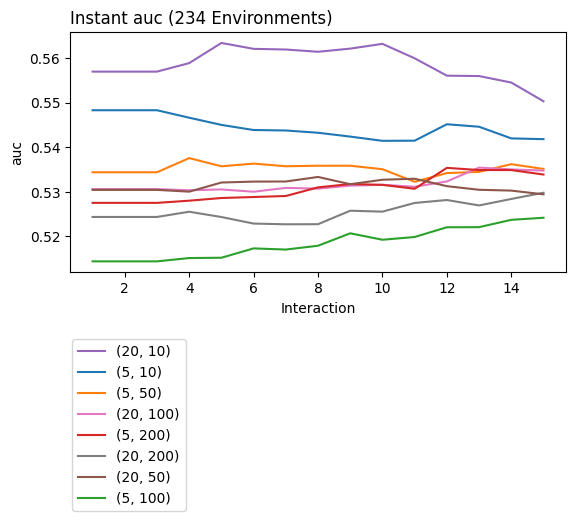

index                                                                1     2   \
specs1                       specs2 specs3        neg ws   ssl er               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  4   54.8  54.8   
                                                           50  4   53.4  53.4   
                                                           100 4   51.4  51.4   
                                                           200 4   52.8  52.8   
                                                  20  True 10  4   55.7  55.7   
                                                           50  4   53.0  53.0   
                                                           100 4   53.1  53.1   
                                                           200 4   52.4  52.4   

index                                                                3     4   \
specs1                       specs2 specs3        neg ws   ssl er               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  4   54.8  54.7   
                                                           50  4   53.4  53.8   
                                                           100 4   51.4  51.5   
                                                           200 4   52.8  52.8   
                                                  20  True 10  4   55.7  55.9   
                                                           50  4   53.0  53.0   
                                                           100 4   53.1  53.0   
                                                           200 4   52.4  52.6   

index                                                                5     6   \
specs1                       specs2 specs3        neg ws   ssl er               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  4   54.5  54.4   
                                                           50  4   53.6  53.6   
                                                           100 4   51.5  51.7   
                                                           200 4   52.9  52.9   
                                                  20  True 10  4   56.3  56.2   
                                                           50  4   53.2  53.2   
                                                           100 4   53.1  53.0   
                                                           200 4   52.4  52.3   

index                                                                7     8   \
specs1                       specs2 specs3        neg ws   ssl er               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  4   54.4  54.3   
                                                           50  4   53.6  53.6   
                                                           100 4   51.7  51.8   
                                                           200 4   52.9  53.1   
                                                  20  True 10  4   56.2  56.1   
                                                           50  4   53.2  53.3   
                                                           100 4   53.1  53.1   
                                                           200 4   52.3  52.3   

index                                                                9     10  \
specs1                       specs2 specs3        neg ws   ssl er               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  4   54.2  54.1   
                                                           50  4   53.6  53.5   
                                                           100 4   52.1  51.9   
                                                           200 4   53.2  53.2   
                                                  20  True 10  4   56.2  56.3   
                                                           50  4   53.2  53.3   
                                                           100 4   53.1  53.2   
                           

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28g.log")

res = res.filter_fin(l=['neg','ssl'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

#out[(out['index']==15) & (out["pid"] == 450)]

res.plot_learners('index','auc',l=['neg','ssl'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','er','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','er'],columns='index',values='auc').round(3)*100


In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28g.log")

res = res.filter_fin(l=['neg','ssl'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

#out[(out['index']==15) & (out["pid"] == 450)]

res.plot_learners('index','auc',l=['neg','ssl'],xlim=(0,15))
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl'],columns='index',values='auc').round(3)*100


We removed 15 ['pid', 'rng'] because they did not exist for every ['neg', 'ssl', 'sr'].


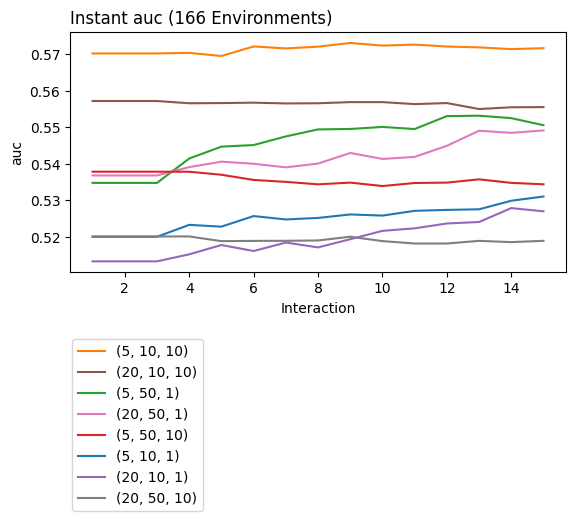

index                                                                1     2   \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   52.0  52.0   
                                                               10  57.0  57.0   
                                                           50  1   53.5  53.5   
                                                               10  53.8  53.8   
                                                  20  True 10  1   51.3  51.3   
                                                               10  55.7  55.7   
                                                           50  1   53.7  53.7   
                                                               10  52.0  52.0   

index                                                                3     4   \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   52.0  52.3   
                                                               10  57.0  57.0   
                                                           50  1   53.5  54.1   
                                                               10  53.8  53.8   
                                                  20  True 10  1   51.3  51.5   
                                                               10  55.7  55.7   
                                                           50  1   53.7  53.9   
                                                               10  52.0  52.0   

index                                                                5     6   \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   52.3  52.6   
                                                               10  57.0  57.2   
                                                           50  1   54.5  54.5   
                                                               10  53.7  53.6   
                                                  20  True 10  1   51.8  51.6   
                                                               10  55.7  55.7   
                                                           50  1   54.1  54.0   
                                                               10  51.9  51.9   

index                                                                7     8   \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   52.5  52.5   
                                                               10  57.2  57.2   
                                                           50  1   54.8  54.9   
                                                               10  53.5  53.4   
                                                  20  True 10  1   51.8  51.7   
                                                               10  55.7  55.7   
                                                           50  1   53.9  54.0   
                                                               10  51.9  51.9   

index                                                                9     10  \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 5   True 10  1   52.6  52.6   
                                                               10  57.3  57.2   
                                                           50  1   55.0  55.0   
                                                               10  53.5  53.4   
                                                  20  True 10  1   51.9  52.2   
                                                               10  55.7  55.7   
                                                           50  1   54.3  54.1   
                           

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28h.log")

res = res.filter_fin(l=['neg','ssl','sr'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

#out[(out['index']==15) & (out["pid"] == 450)]

res.plot_learners('index','auc',l=['neg','ssl','sr'],p=['pid','rng'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


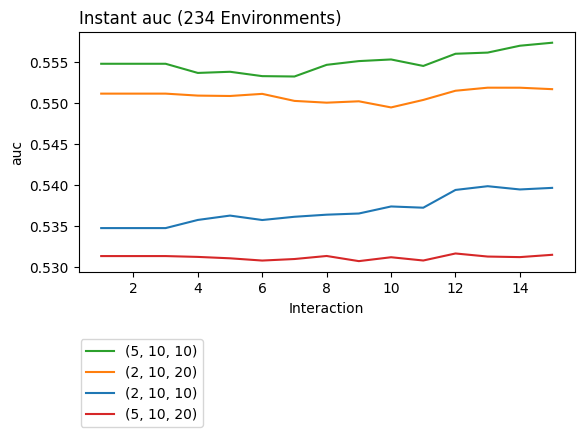

index                                                                1     2   \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 2   True 10  10  53.5  53.5   
                                                               20  55.1  55.1   
                                                  5   True 10  10  55.5  55.5   
                                                               20  53.1  53.1   

index                                                                3     4   \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 2   True 10  10  53.5  53.6   
                                                               20  55.1  55.1   
                                                  5   True 10  10  55.5  55.4   
                                                               20  53.1  53.1   

index                                                                5     6   \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 2   True 10  10  53.6  53.6   
                                                               20  55.1  55.1   
                                                  5   True 10  10  55.4  55.3   
                                                               20  53.1  53.1   

index                                                                7     8   \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 2   True 10  10  53.6  53.6   
                                                               20  55.0  55.0   
                                                  5   True 10  10  55.3  55.5   
                                                               20  53.1  53.1   

index                                                                9     10  \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 2   True 10  10  53.7  53.7   
                                                               20  55.0  54.9   
                                                  5   True 10  10  55.5  55.5   
                                                               20  53.1  53.1   

index                                                                11    12  \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 2   True 10  10  53.7  53.9   
                                                               20  55.0  55.1   
                                                  5   True 10  10  55.4  55.6   
                                                               20  53.1  53.2   

index                                                                13    14  \
specs1                       specs2 specs3        neg ws   ssl sr               
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 2   True 10  10  54.0  53.9   
                                                               20  55.2  55.2   
                                                  5   True 10  10  55.6  55.7   
                                                               20  53.1  53.1   

index                                                                15  
specs1                       specs2 specs3        neg ws   ssl sr        
(29, 10, l, r, 20, l, r, 20) ()     (20, l, r, 1) 2   True 10  10  54.0  
                                                               20  55.2  
                                                  5   True 10  10  55.7  
                                                               20  53.2

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28i.log")

res = res.filter_fin(l=['neg','ssl','sr'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

#out[(out['index']==15) & (out["pid"] == 450)]

res.plot_learners('index','auc',l=['neg','ssl','sr'],p=['pid','rng'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


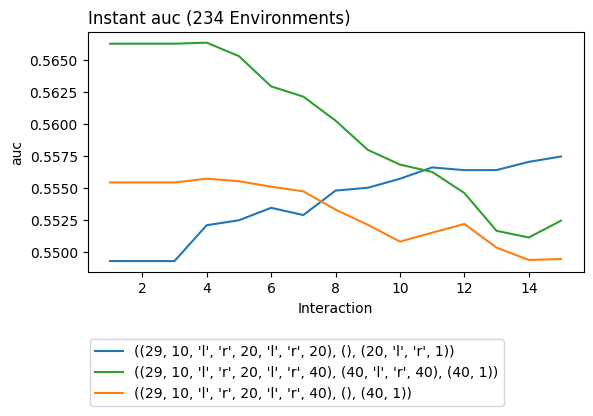

index                                                                        1   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.9   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.5   
                             (40, l, r, 40) (40, 1)       5   True 10  10  56.6   

index                                                                        2   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.9   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.5   
                             (40, l, r, 40) (40, 1)       5   True 10  10  56.6   

index                                                                        3   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.9   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.5   
                             (40, l, r, 40) (40, 1)       5   True 10  10  56.6   

index                                                                        4   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  55.2   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.6   
                             (40, l, r, 40) (40, 1)       5   True 10  10  56.6   

index                                                                        5   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  55.2   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.6   
                             (40, l, r, 40) (40, 1)       5   True 10  10  56.5   

index                                                                        6   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  55.3   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.5   
                             (40, l, r, 40) (40, 1)       5   True 10  10  56.3   

index                                                                        7   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  55.3   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.5   
                             (40, l, r, 40) (40, 1)       5   True 10  10  56.2   

index                                                                        8   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  55.5   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.3   
                             (40, l, r, 40) (40, 1)       5   True 10  10  56.0   

index                                                                        9   \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  55.5   
(29, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.2   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.8   

index                                                                        10  \
specs1                       specs2         specs3        neg ws   ssl sr         
(29, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  55.6   
(29, 10

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28j.log")

res = res.filter_fin(l=['specs1','specs2','specs3'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3'],p=['pid','rng'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


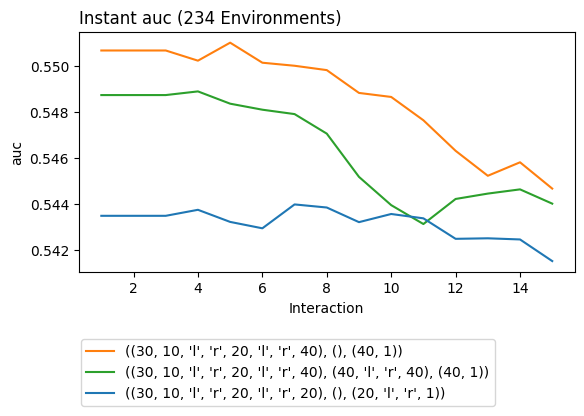

index                                                                        1   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.3   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.9   

index                                                                        2   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.3   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.9   

index                                                                        3   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.3   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.9   

index                                                                        4   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.4   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.0   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.9   

index                                                                        5   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.3   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.8   

index                                                                        6   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.3   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.0   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.8   

index                                                                        7   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.4   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.0   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.8   

index                                                                        8   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.4   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  55.0   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.7   

index                                                                        9   \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.3   
(30, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.9   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.5   

index                                                                        10  \
specs1                       specs2         specs3        neg ws   ssl sr         
(30, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  54.4   
(30, 10

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28k.log")

res = res.filter_fin(l=['specs1','specs2','specs3'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3'],p=['pid','rng'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


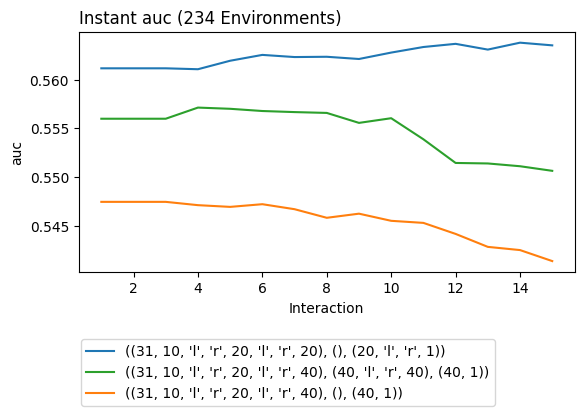

index                                                                        1   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.1   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.7   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.6   

index                                                                        2   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.1   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.7   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.6   

index                                                                        3   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.1   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.7   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.6   

index                                                                        4   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.1   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.7   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.7   

index                                                                        5   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.2   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.7   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.7   

index                                                                        6   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.7   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.7   

index                                                                        7   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.2   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.7   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.7   

index                                                                        8   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.2   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.6   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.7   

index                                                                        9   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.2   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  54.6   
                             (40, l, r, 40) (40, 1)       5   True 10  10  55.6   

index                                                                        10  \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  56.3   
(31, 10

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28l.log")

res = res.filter_fin(l=['specs1','specs2','specs3'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3'],p=['pid','rng'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


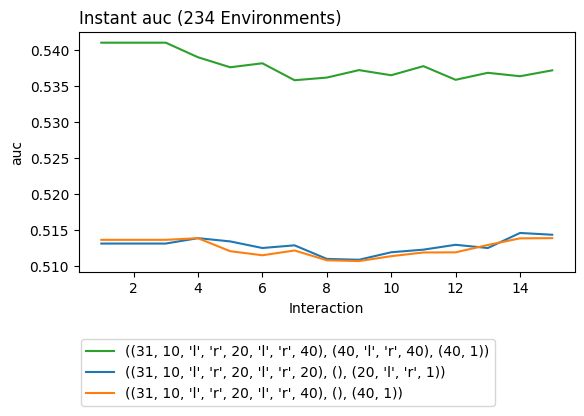

index                                                                        1   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.4   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.1   

index                                                                        2   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.4   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.1   

index                                                                        3   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.4   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.1   

index                                                                        4   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.4   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.4   
                             (40, l, r, 40) (40, 1)       5   True 10  10  53.9   

index                                                                        5   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.2   
                             (40, l, r, 40) (40, 1)       5   True 10  10  53.8   

index                                                                        6   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.2   
                             (40, l, r, 40) (40, 1)       5   True 10  10  53.8   

index                                                                        7   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.2   
                             (40, l, r, 40) (40, 1)       5   True 10  10  53.6   

index                                                                        8   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.1   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  53.6   

index                                                                        9   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.1   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  53.7   

index                                                                        10  \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.2   
(31, 10

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28m.log")

res = res.filter_fin(l=['specs1','specs2','specs3'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3'],p=['pid','rng'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


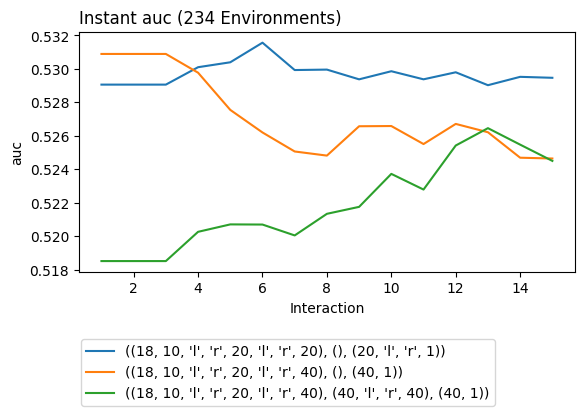

index                                                                        1   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  52.9   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  53.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  51.9   

index                                                                        2   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  52.9   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  53.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  51.9   

index                                                                        3   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  52.9   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  53.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  51.9   

index                                                                        4   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  53.0   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  53.0   
                             (40, l, r, 40) (40, 1)       5   True 10  10  52.0   

index                                                                        5   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  53.0   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  52.8   
                             (40, l, r, 40) (40, 1)       5   True 10  10  52.1   

index                                                                        6   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  53.2   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  52.6   
                             (40, l, r, 40) (40, 1)       5   True 10  10  52.1   

index                                                                        7   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  53.0   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  52.5   
                             (40, l, r, 40) (40, 1)       5   True 10  10  52.0   

index                                                                        8   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  53.0   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  52.5   
                             (40, l, r, 40) (40, 1)       5   True 10  10  52.1   

index                                                                        9   \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  52.9   
(18, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  52.7   
                             (40, l, r, 40) (40, 1)       5   True 10  10  52.2   

index                                                                        10  \
specs1                       specs2         specs3        neg ws   ssl sr         
(18, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  53.0   
(18, 10

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28n.log")

res = res.filter_fin(l=['specs1','specs2','specs3'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3'],p=['pid','rng'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


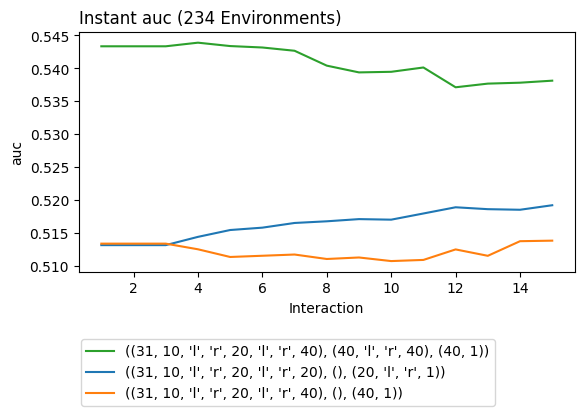

index                                                                        1   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.3   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.3   

index                                                                        2   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.3   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.3   

index                                                                        3   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.3   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.3   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.3   

index                                                                        4   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.4   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.3   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.4   

index                                                                        5   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.5   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.3   

index                                                                        6   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.6   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.2   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.3   

index                                                                        7   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.7   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.2   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.3   

index                                                                        8   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.7   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  54.0   

index                                                                        9   \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.7   
(31, 10, l, r, 20, l, r, 40) ()             (40, 1)       5   True 10  10  51.1   
                             (40, l, r, 40) (40, 1)       5   True 10  10  53.9   

index                                                                        10  \
specs1                       specs2         specs3        neg ws   ssl sr         
(31, 10, l, r, 20, l, r, 20) ()             (20, l, r, 1) 5   True 10  10  51.7   
(31, 10

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28o.log")

res = res.filter_fin(l=['specs1','specs2','specs3'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3'],p=['pid','rng'],xlim=(0,15),span=1)
o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


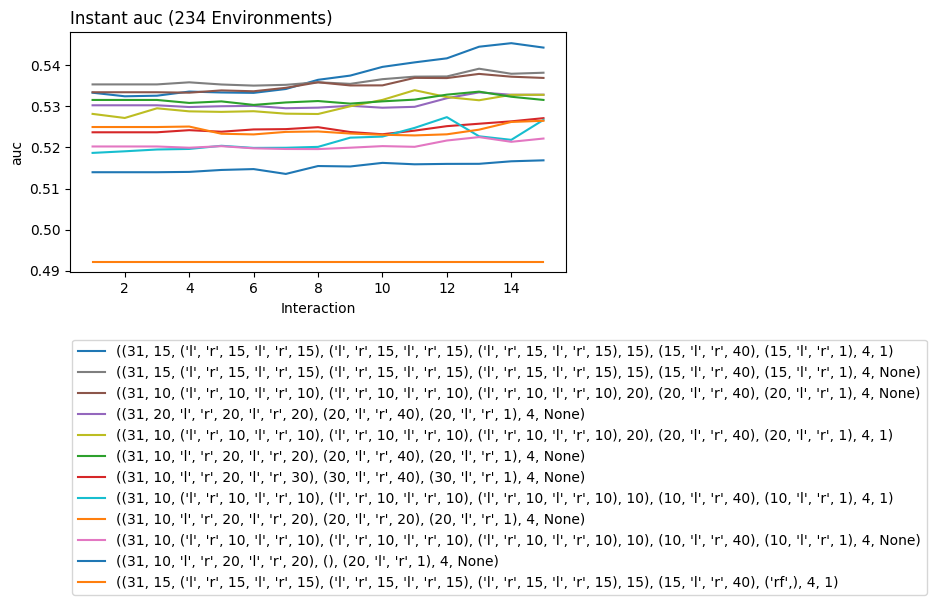

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28p.log")

res = res.filter_fin(l=['specs1','specs2','specs3','er','lr'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3','er','lr'],p=['pid','rng'],xlim=(0,15),span=1)
#o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
#o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


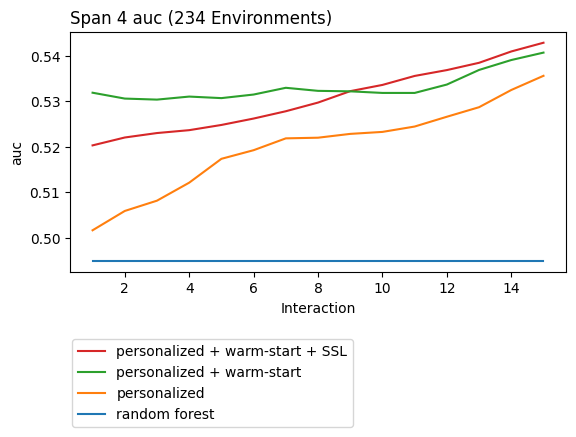

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28q.log")
res = res.where(evaluator_id=[0,1,2,7]).filter_fin(l=['specs1','specs2','specs3','ws','er','lr'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3','ws','er','lr'],p=['pid','rng'],xlim=(0,15),span=4,labels=[
    "random forest",
    "personalized",
    "personalized + warm-start",
    "personalized + warm-start + SSL"
])
#o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
#o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


We removed 4 ['pid', 'rng'] because they did not exist for every ['specs1', 'specs2', 'specs3', 'ws', 'er', 'lr'].


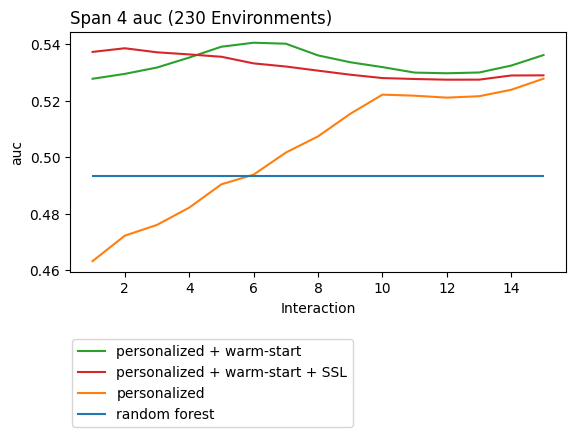

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28r.log")
res = res.where(evaluator_id=[0,1,2,7]).filter_fin(l=['specs1','specs2','specs3','ws','er','lr'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3','ws','er','lr'],p=['pid','rng'],xlim=(0,15),span=4,labels=[
    "random forest",
    "personalized",
    "personalized + warm-start",
    "personalized + warm-start + SSL"
])
#o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
#o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


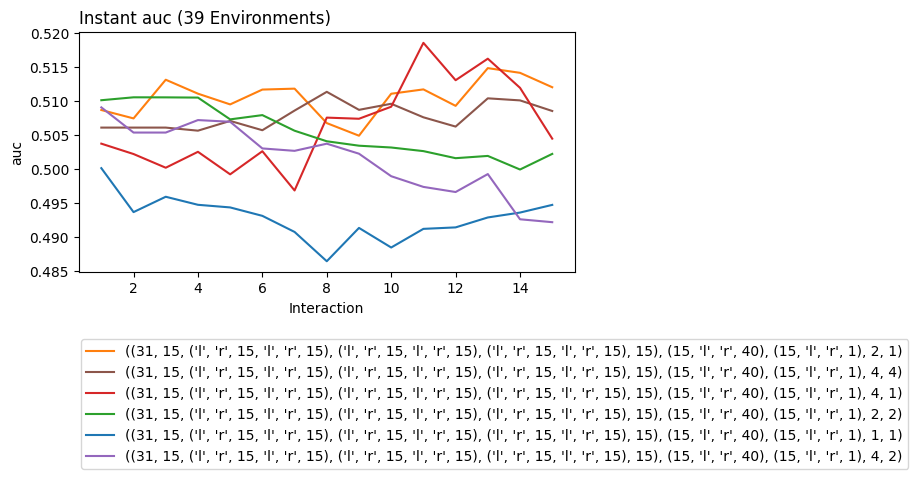

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28r.log")

res = res.filter_fin(l=['specs1','specs2','specs3','er','lr'],p=['pid','rng'])

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

res.plot_learners('index','auc',l=['specs1','specs2','specs3','er','lr'],p=['pid','rng'],xlim=(0,15),span=1)
#o = out.groupby(['specs1','specs2','specs3','neg','ws','ssl','sr','index'])[['auc']].mean().reset_index()
#o.pivot(index=['specs1','specs2','specs3','neg','ws','ssl','sr'],columns='index',values='auc').round(3)*100


<Axes: >

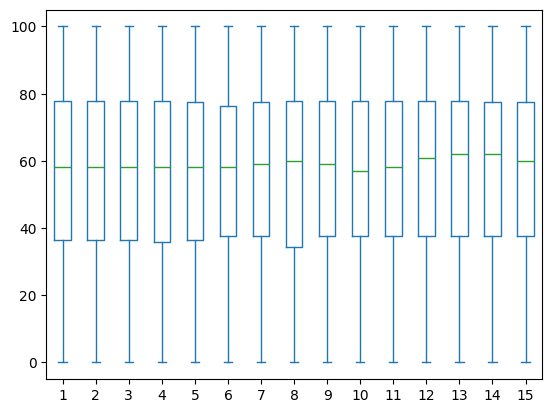

In [ ]:
import coba as cb
import pandas as pd

res = cb.Result.from_file("../logs/out28.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)


(out[out.evaluator_id==2].pivot(index=['environment_id'],columns='index',values='auc').round(3)*100).plot.box()
plt.show()
#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


Pandas(Index=0, lrn=1, er=0)


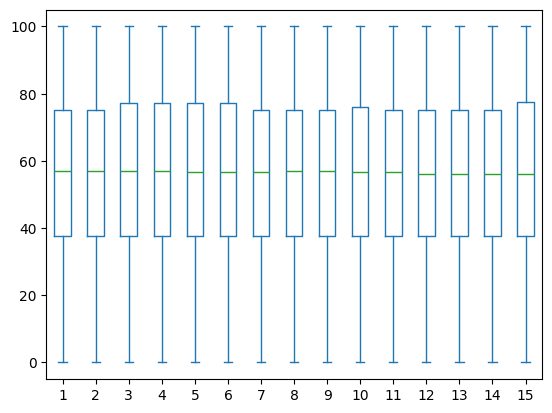

Pandas(Index=1, lrn=2, er=0)


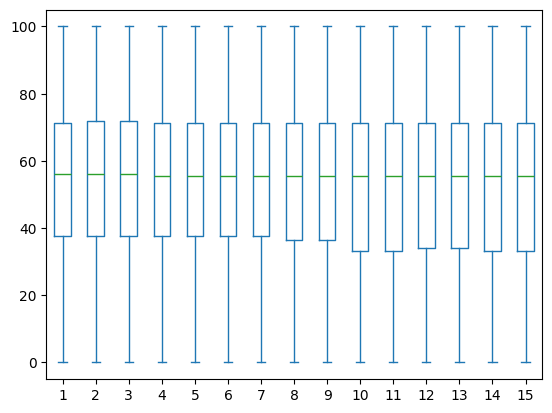

Pandas(Index=2, lrn=2, er=2)


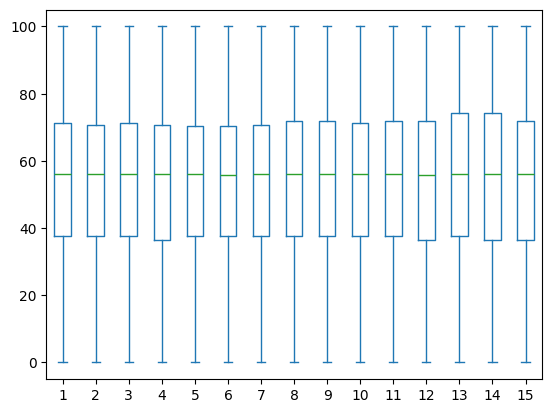

Pandas(Index=3, lrn=3, er=3)


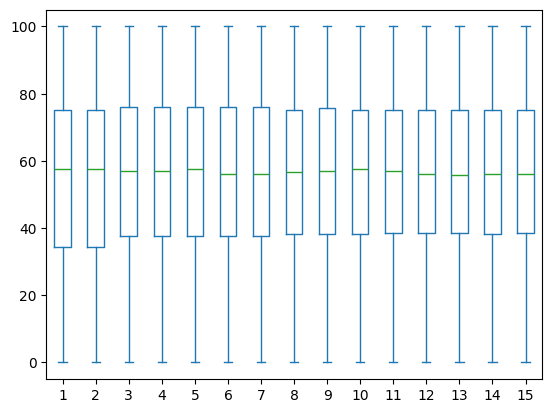

Pandas(Index=4, lrn=4, er=4)


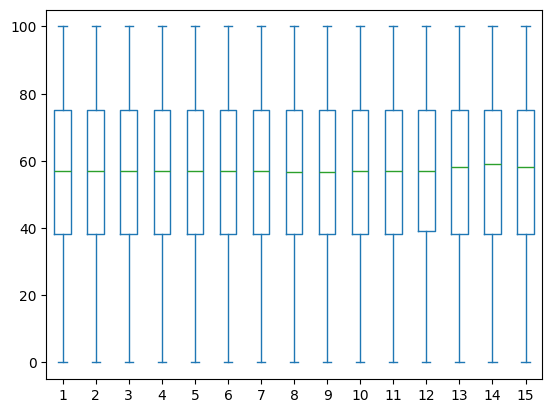

Pandas(Index=5, lrn=2, er=4)


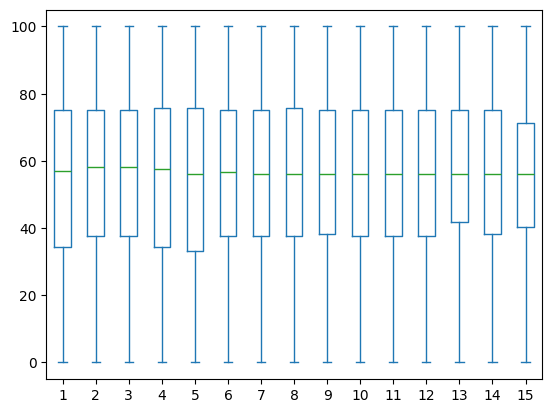

Pandas(Index=6, lrn=3, er=0)


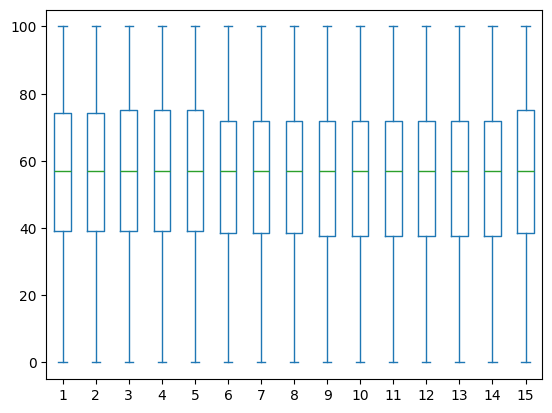

Pandas(Index=7, lrn=4, er=0)


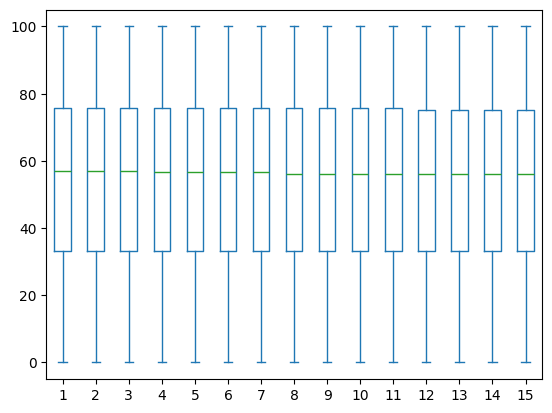

In [ ]:
import coba as cb
import pandas as pd
import matplotlib.pyplot as plt

res = cb.Result.from_file("../logs/out28b.log")

out  = res.interactions.to_pandas()
envs = res.environments.to_pandas()
lrns = res.learners.to_pandas()
vals = res.evaluators.to_pandas()
out = pd.merge(pd.merge(out,envs),vals)

for evaluator_id in set(out['evaluator_id']):
    print(next(vals[vals.evaluator_id==evaluator_id][['lrn','er']].itertuples()))
    (out[out.evaluator_id==evaluator_id].pivot(index=['environment_id','evaluator_id'],columns='index',values='auc').round(3)*100).plot.box()
    plt.show()

#out.groupby(['specs1','specs2','specs3','neg','ws','ssl'])[['auc']].mean().reset_index()


In [2]:
import coba as cb

res = cb.Result.from_file("../logs/out29.log")

out  = res.interactions.to_pandas()

out.groupby(['index'])[['auc']].mean().reset_index()

#o.pivot(columns='index',values='auc').round(3)


index       auc
0       1  0.537002
1       2  0.537002
2       3  0.537002
3       4  0.537002
4       5  0.537002
5       6  0.537002
6       7  0.537002
7       8  0.537002
8       9  0.537002
9      10  0.537002
10     11  0.537002
11     12  0.537002
12     13  0.537002
13     14  0.537002
14     15  0.537002